In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
import sys
#PATH = '/content/drive/My Drive/PPM_Stability/'
PATH = "C:/Users/velmurug/Documents/Stability Experiments/benchmark_interpretability/PPM_Stability/"
#PATH = "C:/Users/Mythreyi/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
#PATH = "C:/Users/mythr/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
sys.path.append(PATH)

In [2]:
#!pip install lime==0.2.0.1
#!pip install shap==0.35.0
#!pip install pandas==0.19.2
#!pip install xgboost==1.0.0

In [3]:
import EncoderFactory
from DatasetManager_for_colab import DatasetManager
import BucketFactory
import stability as st #Nogueira, Sechidis, Brown.

import pandas as pd
import numpy as np
from scipy import stats
import math

from sklearn.metrics import roc_auc_score
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler

import time
import os
import sys
from sys import argv
import pickle
from collections import defaultdict, Counter
import random
import joblib

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import lime
import lime.lime_tabular
from lime import submodular_pick;

import shap

import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def imp_df(column_names, importances):
        df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
        return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title, num_feat):
        imp_df.columns = ['feature', 'feature_importance']
        b= sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df.head(num_feat), orient = 'h', palette="Blues_r")

In [5]:
def generate_global_explanations(train_X,train_Y, cls, feature_combiner):
    
    print("The number of testing instances is ",len(train_Y))
    print("The total number of columns is",train_X.shape[1]);
    print("The total accuracy is ",cls.score(train_X,train_Y));
       
    sns.set(rc={'figure.figsize':(10,10), "font.size":18,"axes.titlesize":18,"axes.labelsize":18})
    sns.set
    feat_names = feature_combiner.get_feature_names()
    base_imp = imp_df(feat_names, cls.feature_importances_)
    base_imp.head(15)
    var_imp_plot(base_imp, 'Feature importance using XGBoost', 15)
    return base_imp

In [6]:
from lime import submodular_pick
def generate_lime_explanations(explainer,test_xi, cls,test_y, submod=False, test_all_data=None, max_feat = 10):
    
    #print("Actual value ", test_y)
    exp = explainer.explain_instance(test_xi, 
                                 cls.predict_proba, num_features=max_feat, labels=[0,1])
    
    return exp
        
    if submod==True:
        sp_obj=submodular_pick.SubmodularPick(explainer, test_all_data, cls.predict_proba, 
                                      sample_size=20, num_features=num_features,num_exps_desired=4)
        [exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations];

In [7]:
def create_samples(shap_explainer, iterations, row, features, top = None):
    length = len(features)
    
    exp = []
    rel_exp = []
    
    for j in range(iterations):
        
        #if shap_type == "kernel":
        #    shap_explainer = shap.KernelExplainer(cls.predict, trainingsample)
        #elif shap_type == "tree":
        #    shap_explainer = shap.TreeExplainer(cls)
        #elif shap_type == "deep":
        #    shap_explainer = shap.DeepExplainer(cls, background)
        
        #print(X_test_frame.loc[row])
        shap_values = shap_explainer.shap_values(row)
        #print(shap_values)

        importances = []
        
        if type(shap_explainer) == shap.explainers.kernel.KernelExplainer:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][i]
                abs_val = abs(shap_values[0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
                
        elif type(shap_explainer) == shap.explainers.tree.TreeExplainer:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][i]
                abs_val = abs(shap_values[0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
        
        elif type(shap_explainer) == shap.explainers.deep.DeepExplainer:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][0][i]
                abs_val = abs(shap_values[0][0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
        
        importances.sort(key=lambda tup: tup[2], reverse = True)
        
        exp.append(importances)

        rel_feat = []

        if top != None:
            for i in range(top):
                feat = importances[i]
                if feat[2] > 0:
                    rel_feat.append(feat)

            rel_exp.append(rel_feat)
        else:
            rel_exp = exp
        
    return exp, rel_exp

In [8]:
def generate_distributions(explainer, features, test_x, bin_min = -1, bin_max = 1, bin_width = 0.05):
    
    #generate shap values for entire test set
    shap_values = explainer.shap_values(test_x, check_additivity = False)
#    print(shap_values)
    shap_val_feat = np.transpose(shap_values)
#    print(shap_val_feat)
    feats = np.transpose(test_x)
    
    shap_distribs = []
    
    #For each feature
    for i in range(len(features)):
        print (i+1, "of", len(features), "features")
        shap_vals = shap_val_feat[i]
#        print(shap_vals)

        #create bins based on shap value ranges
        bins = np.arange(bin_min, bin_max, bin_width)

        feat_vals = []
        for sbin in range(len(bins)):
            nl = []
            feat_vals.append(nl)

        #place relevant feature values into each bin
        for j in range(len(shap_vals)):
            val = shap_vals[j]
            b = 0
            cur_bin = bins[b]
            idx = b

            while val > cur_bin and b < len(bins)-1:
                #print(cur_bin)
                idx = b
                b+=1
                #print(b)
                cur_bin = bins[b]

            #print(val, idx)
            feat_vals[idx].append(feats[i][j])

        #Remove feature values that are outliers
        #for each in feat_vals:
        #    zscore = stats.zscore(each)
            #print(each)
        #    for n in range(len(zscore)):
        #        if zscore[n] > 3 or zscore[n] < -3:
        #            np.delete(zscore, n)
        #            del each[n]
            #print(each)
            
        #Find min and max values for each shap value bin
        mins = []
        maxes = []
        #width = []
        #print(feat_vals)
        #n = 0
        for each in feat_vals:
            if each != []:
                mins.append(min(each))
                maxes.append(max(each))
         #       width.append("Bin "+str(n))
         #       n+=1
        #plt.bar(width, maxes, bottom = mins)
        #plt.show()

        #Create dictionary with list of bins and max and min feature values for each bin
        feat_name = features[i]

        feat_dict = {'Feature Name': feat_name}
        for each in feat_vals:
            if each != []:
                mins.append(min(each))
                maxes.append(max(each))
            else:
                mins.append(None)
                maxes.append(None)

        feat_dict['bins'] = bins
        feat_dict['mins'] = mins
        feat_dict['maxes'] = maxes
       
        shap_distribs.append(feat_dict)
        
    return shap_distribs

In [9]:
dataset_ref = "production"
params_dir = PATH + "params"
results_dir = "results"
bucket_method = "prefix"
cls_encoding = "index"
cls_method = "xgboost"

gap = 1
n_iter = 1

method_name = "%s_%s"%(bucket_method, cls_encoding)

generate_samples = False
generate_lime = True
generate_kernel_shap = False
generate_model_shap = True

sample_size = 2
exp_iter = 10
#max_feat = 10
max_prefix = 20

dataset_ref_to_datasets = {
    #"bpic2011": ["bpic2011_f%s"%formula for formula in range(1,5)],
    "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(5,6)],
    "bpic2017" : ["bpic2017_accepted"],
    "bpic2012" : ["bpic2012_accepted"],
    #"insurance": ["insurance_activity", "insurance_followup"],
    "sepsis_cases": ["sepsis_cases_1"],#, "sepsis_cases_2", "sepsis_cases_4"]
    "production": ["production"]
}

datasets = [dataset_ref] if dataset_ref not in dataset_ref_to_datasets else dataset_ref_to_datasets[dataset_ref]

datasets

['production']

20
Bucket 1
Generating distributions for bucket
1 of 100 features
2 of 100 features
3 of 100 features
4 of 100 features
5 of 100 features
6 of 100 features
7 of 100 features
8 of 100 features
9 of 100 features
10 of 100 features
11 of 100 features
12 of 100 features
13 of 100 features
14 of 100 features
15 of 100 features
16 of 100 features
17 of 100 features
18 of 100 features
19 of 100 features
20 of 100 features
21 of 100 features
22 of 100 features
23 of 100 features
24 of 100 features
25 of 100 features
26 of 100 features
27 of 100 features
28 of 100 features
29 of 100 features
30 of 100 features
31 of 100 features
32 of 100 features
33 of 100 features
34 of 100 features
35 of 100 features
36 of 100 features
37 of 100 features
38 of 100 features
39 of 100 features
40 of 100 features
41 of 100 features
42 of 100 features
43 of 100 features
44 of 100 features
45 of 100 features
46 of 100 features
47 of 100 features
48 of 100 features
49 of 100 features
50 of 100 features
51 of 100 f

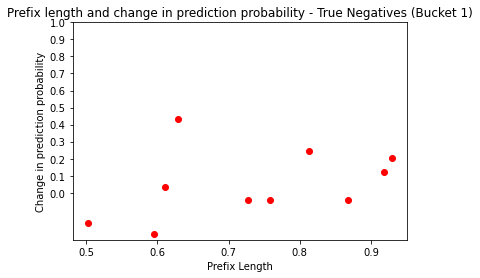

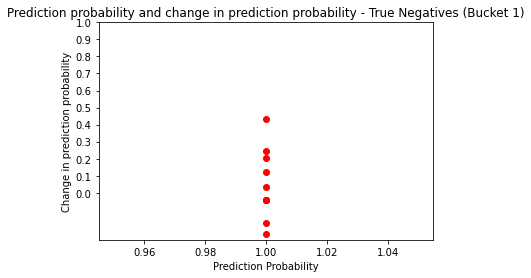

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 10
Creating distribution for feature 2 of 10
Creating distribution for feature 3 of 10
Creating distribution for feature 4 of 10
Creating distribution for feature 5 of 10
Creating distribution for feature 6 of 10
Creating distribution for feature 7 of 10
Creating distribution for feature 8 of 10
Creating distribution for feature 9 of 10
Creating distribution for feature 10 of 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 10
Creating distribution for feature 2 of 10
Creating distribution for feature 3 of 10
Creating distribution for feature 4 of 10
Creating distribution for feature 5 of 10
Creating distrib

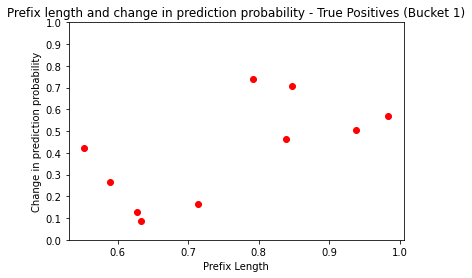

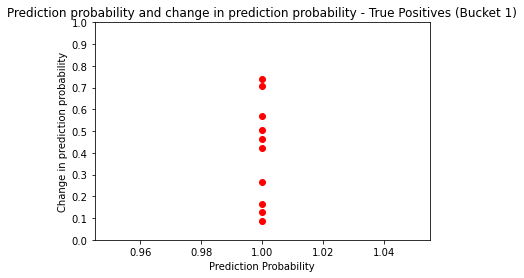

Category 3 of 4. Instance 1 of 8
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 10
Creating distribution for feature 2 of 10
Creating distribution for feature 3 of 10
Creating distribution for feature 4 of 10
Creating distribution for feature 5 of 10
Creating distribution for feature 6 of 10
Creating distribution for feature 7 of 10
Creating distribution for feature 8 of 10
Creating distribution for feature 9 of 10
Creating distribution for feature 10 of 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 8
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 10
Creating distribution for feature 2 of 10
Creating distribution for feature 3 of 10
Creating distribution for feature 4 of 10
Creating distribution for feature 5 of 10
Creating distribut

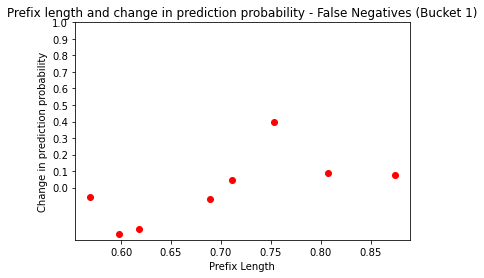

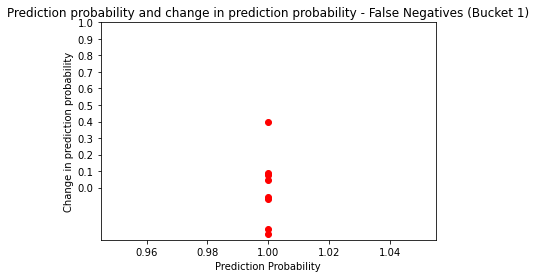

Category 4 of 4. Instance 1 of 8
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 10
Creating distribution for feature 2 of 10
Creating distribution for feature 3 of 10
Creating distribution for feature 4 of 10
Creating distribution for feature 5 of 10
Creating distribution for feature 6 of 10
Creating distribution for feature 7 of 10
Creating distribution for feature 8 of 10
Creating distribution for feature 9 of 10
Creating distribution for feature 10 of 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 8
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 10
Creating distribution for feature 2 of 10
Creating distribution for feature 3 of 10
Creating distribution for feature 4 of 10
Creating distribution for feature 5 of 10
Creating distribut

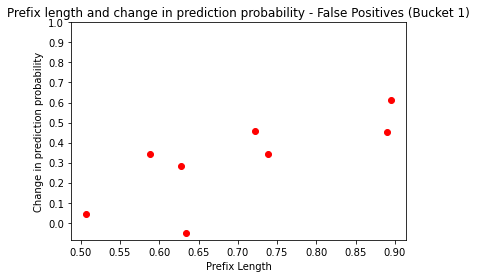

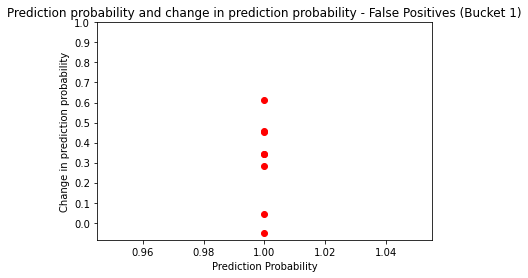

Bucket 2
Generating distributions for bucket
1 of 173 features
2 of 173 features
3 of 173 features
4 of 173 features
5 of 173 features
6 of 173 features
7 of 173 features
8 of 173 features
9 of 173 features
10 of 173 features
11 of 173 features
12 of 173 features
13 of 173 features
14 of 173 features
15 of 173 features
16 of 173 features
17 of 173 features
18 of 173 features
19 of 173 features
20 of 173 features
21 of 173 features
22 of 173 features
23 of 173 features
24 of 173 features
25 of 173 features
26 of 173 features
27 of 173 features
28 of 173 features
29 of 173 features
30 of 173 features
31 of 173 features
32 of 173 features
33 of 173 features
34 of 173 features
35 of 173 features
36 of 173 features
37 of 173 features
38 of 173 features
39 of 173 features
40 of 173 features
41 of 173 features
42 of 173 features
43 of 173 features
44 of 173 features
45 of 173 features
46 of 173 features
47 of 173 features
48 of 173 features
49 of 173 features
50 of 173 features
51 of 173 feat

Identifying relevant features
Creating distribution for feature 1 of 17
Creating distribution for feature 2 of 17
Creating distribution for feature 3 of 17
Creating distribution for feature 4 of 17
Creating distribution for feature 5 of 17
Creating distribution for feature 6 of 17
Creating distribution for feature 7 of 17
Creating distribution for feature 8 of 17
Creating distribution for feature 9 of 17
Creating distribution for feature 10 of 17
Creating distribution for feature 11 of 17
Creating distribution for feature 12 of 17
Creating distribution for feature 13 of 17
Creating distribution for feature 14 of 17
Creating distribution for feature 15 of 17
Creating distribution for feature 16 of 17
Creating distribution for feature 17 of 17
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 7 of 10
Creating explanations
Identifying

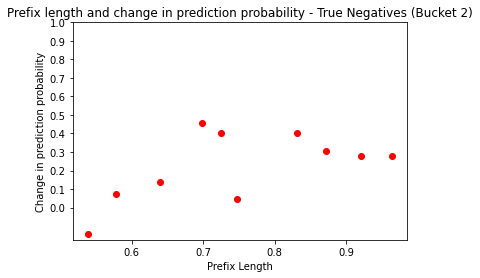

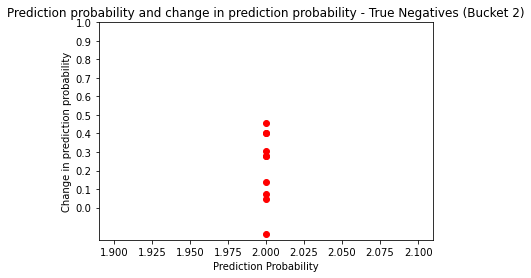

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 17
Creating distribution for feature 2 of 17
Creating distribution for feature 3 of 17
Creating distribution for feature 4 of 17
Creating distribution for feature 5 of 17
Creating distribution for feature 6 of 17
Creating distribution for feature 7 of 17
Creating distribution for feature 8 of 17
Creating distribution for feature 9 of 17
Creating distribution for feature 10 of 17
Creating distribution for feature 11 of 17
Creating distribution for feature 12 of 17
Creating distribution for feature 13 of 17
Creating distribution for feature 14 of 17
Creating distribution for feature 15 of 17
Creating distribution for feature 16 of 17
Creating distribution for feature 17 of 17
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 

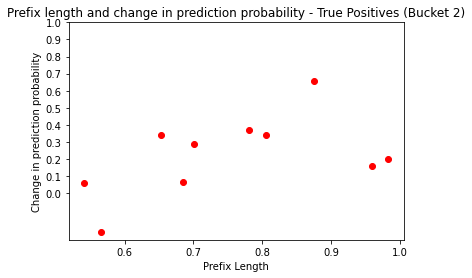

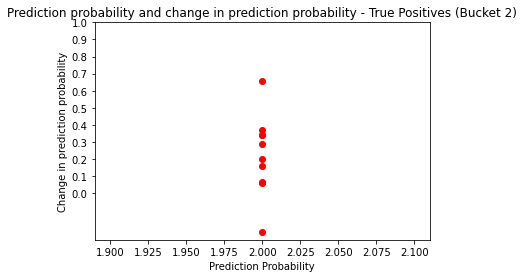

Category 3 of 4. Instance 1 of 8
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 17
Creating distribution for feature 2 of 17
Creating distribution for feature 3 of 17
Creating distribution for feature 4 of 17
Creating distribution for feature 5 of 17
Creating distribution for feature 6 of 17
Creating distribution for feature 7 of 17
Creating distribution for feature 8 of 17
Creating distribution for feature 9 of 17
Creating distribution for feature 10 of 17
Creating distribution for feature 11 of 17
Creating distribution for feature 12 of 17
Creating distribution for feature 13 of 17
Creating distribution for feature 14 of 17
Creating distribution for feature 15 of 17
Creating distribution for feature 16 of 17
Creating distribution for feature 17 of 17
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 o

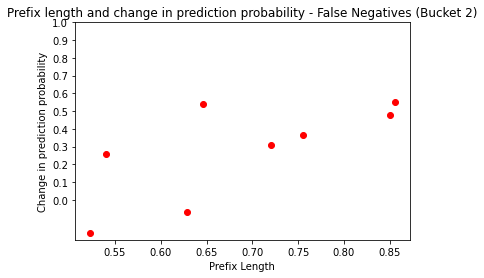

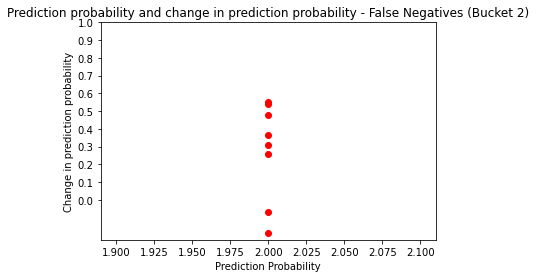

Category 4 of 4. Instance 1 of 8
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 17
Creating distribution for feature 2 of 17
Creating distribution for feature 3 of 17
Creating distribution for feature 4 of 17
Creating distribution for feature 5 of 17
Creating distribution for feature 6 of 17
Creating distribution for feature 7 of 17
Creating distribution for feature 8 of 17
Creating distribution for feature 9 of 17
Creating distribution for feature 10 of 17
Creating distribution for feature 11 of 17
Creating distribution for feature 12 of 17
Creating distribution for feature 13 of 17
Creating distribution for feature 14 of 17
Creating distribution for feature 15 of 17
Creating distribution for feature 16 of 17
Creating distribution for feature 17 of 17
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 o

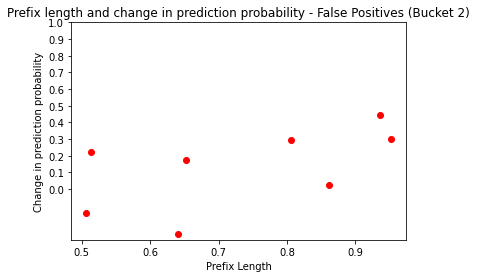

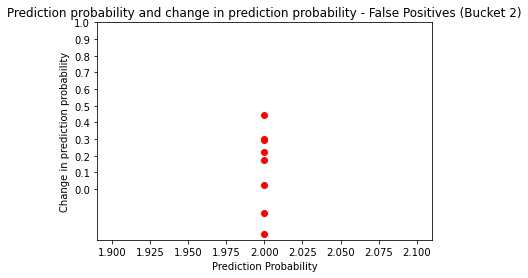

Bucket 3
Generating distributions for bucket
1 of 250 features
2 of 250 features
3 of 250 features
4 of 250 features
5 of 250 features
6 of 250 features
7 of 250 features
8 of 250 features
9 of 250 features
10 of 250 features
11 of 250 features
12 of 250 features
13 of 250 features
14 of 250 features
15 of 250 features
16 of 250 features
17 of 250 features
18 of 250 features
19 of 250 features
20 of 250 features
21 of 250 features
22 of 250 features
23 of 250 features
24 of 250 features
25 of 250 features
26 of 250 features
27 of 250 features
28 of 250 features
29 of 250 features
30 of 250 features
31 of 250 features
32 of 250 features
33 of 250 features
34 of 250 features
35 of 250 features
36 of 250 features
37 of 250 features
38 of 250 features
39 of 250 features
40 of 250 features
41 of 250 features
42 of 250 features
43 of 250 features
44 of 250 features
45 of 250 features
46 of 250 features
47 of 250 features
48 of 250 features
49 of 250 features
50 of 250 features
51 of 250 feat

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 25
Creating distribution for feature 2 of 25
Creating distribution for feature 3 of 25
Creating distribution for feature 4 of 25
Creating distribution for feature 5 of 25
Creating distribution for feature 6 of 25
Creating distribution for feature 7 of 25
Creating distribution for feature 8 of 25
Creating distribution for feature 9 of 25
Creating distribution for feature 10 of 25
Creating distribution for feature 11 of 25
Creating distribution for feature 12 of 25
Creating distribution for feature 13 of 25
Creating distribution for feature 14 of 25
Creating distribution for feature 15 of 25
Creating distribution for feature 16 of 25
Creating distribution for feature 17 of 25
Creating distribution for feature 18 of 25
Creating distribution for feature 19 of 25
Creating distribution for feature 20 of 25
Creating distribution for feature 21 of 25
Creating distribution for feature 22 of 25
Creating di

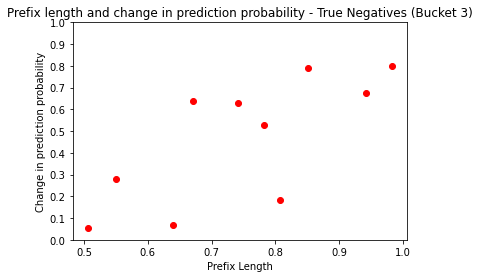

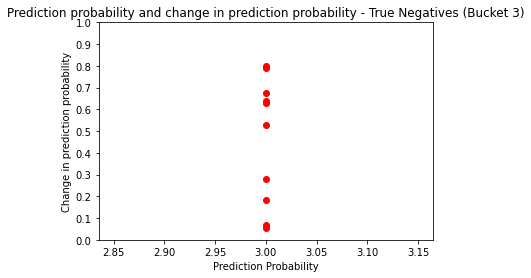

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 25
Creating distribution for feature 2 of 25
Creating distribution for feature 3 of 25
Creating distribution for feature 4 of 25
Creating distribution for feature 5 of 25
Creating distribution for feature 6 of 25
Creating distribution for feature 7 of 25
Creating distribution for feature 8 of 25
Creating distribution for feature 9 of 25
Creating distribution for feature 10 of 25
Creating distribution for feature 11 of 25
Creating distribution for feature 12 of 25
Creating distribution for feature 13 of 25
Creating distribution for feature 14 of 25
Creating distribution for feature 15 of 25
Creating distribution for feature 16 of 25
Creating distribution for feature 17 of 25
Creating distribution for feature 18 of 25
Creating distribution for feature 19 of 25
Creating distribution for feature 20 of 25
Creating distribution for feature 21 of 25
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 25
Creating distribution for feature 2 of 25
Creating distribution for feature 3 of 25
Creating distribution for feature 4 of 25
Creating distribution for feature 5 of 25
Creating distribution for feature 6 of 25
Creating distribution for feature 7 of 25
Creating distribution for feature 8 of 25
Creating distribution for feature 9 of 25
Creating distribution for feature 10 of 25
Creating distribution for feature 11 of 25
Creating distribution for feature 12 of 25
Creating distribution for feature 13 of 25
Creating distribution for feature 14 of 25
Creating distribution for feature 15 of 25
Creating distribution for feature 16 of 25
Creating distribution for feature 17 of 25
Creating distribution for feature 18 of 25
Creating distribution for feature 19 of 25
Creating distribution for feature 20 of 25
Creating distribution for feature 21 of 25
Creating distribution for feature 22 of 25
Creating di

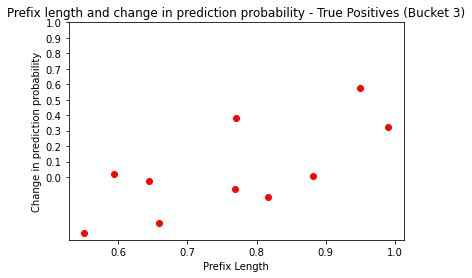

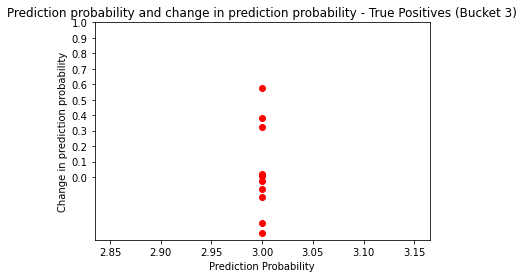

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 25
Creating distribution for feature 2 of 25
Creating distribution for feature 3 of 25
Creating distribution for feature 4 of 25
Creating distribution for feature 5 of 25
Creating distribution for feature 6 of 25
Creating distribution for feature 7 of 25
Creating distribution for feature 8 of 25
Creating distribution for feature 9 of 25
Creating distribution for feature 10 of 25
Creating distribution for feature 11 of 25
Creating distribution for feature 12 of 25
Creating distribution for feature 13 of 25
Creating distribution for feature 14 of 25
Creating distribution for feature 15 of 25
Creating distribution for feature 16 of 25
Creating distribution for feature 17 of 25
Creating distribution for feature 18 of 25
Creating distribution for feature 19 of 25
Creating distribution for feature 20 of 25
Creating distribution for feature 21 of 25
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 25
Creating distribution for feature 2 of 25
Creating distribution for feature 3 of 25
Creating distribution for feature 4 of 25
Creating distribution for feature 5 of 25
Creating distribution for feature 6 of 25
Creating distribution for feature 7 of 25
Creating distribution for feature 8 of 25
Creating distribution for feature 9 of 25
Creating distribution for feature 10 of 25
Creating distribution for feature 11 of 25
Creating distribution for feature 12 of 25
Creating distribution for feature 13 of 25
Creating distribution for feature 14 of 25
Creating distribution for feature 15 of 25
Creating distribution for feature 16 of 25
Creating distribution for feature 17 of 25
Creating distribution for feature 18 of 25
Creating distribution for feature 19 of 25
Creating distribution for feature 20 of 25
Creating distribution for feature 21 of 25
Creating distribution for feature 22 of 25
Creating di

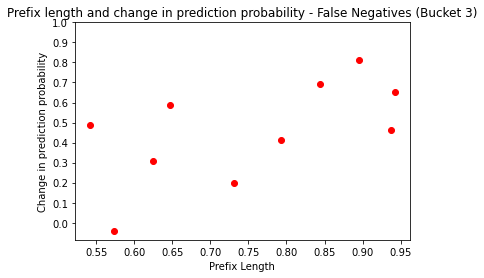

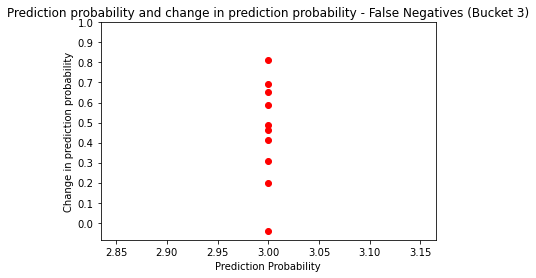

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 25
Creating distribution for feature 2 of 25
Creating distribution for feature 3 of 25
Creating distribution for feature 4 of 25
Creating distribution for feature 5 of 25
Creating distribution for feature 6 of 25
Creating distribution for feature 7 of 25
Creating distribution for feature 8 of 25
Creating distribution for feature 9 of 25
Creating distribution for feature 10 of 25
Creating distribution for feature 11 of 25
Creating distribution for feature 12 of 25
Creating distribution for feature 13 of 25
Creating distribution for feature 14 of 25
Creating distribution for feature 15 of 25
Creating distribution for feature 16 of 25
Creating distribution for feature 17 of 25
Creating distribution for feature 18 of 25
Creating distribution for feature 19 of 25
Creating distribution for feature 20 of 25
Creating distribution for feature 21 of 25
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 25
Creating distribution for feature 2 of 25
Creating distribution for feature 3 of 25
Creating distribution for feature 4 of 25
Creating distribution for feature 5 of 25
Creating distribution for feature 6 of 25
Creating distribution for feature 7 of 25
Creating distribution for feature 8 of 25
Creating distribution for feature 9 of 25
Creating distribution for feature 10 of 25
Creating distribution for feature 11 of 25
Creating distribution for feature 12 of 25
Creating distribution for feature 13 of 25
Creating distribution for feature 14 of 25
Creating distribution for feature 15 of 25
Creating distribution for feature 16 of 25
Creating distribution for feature 17 of 25
Creating distribution for feature 18 of 25
Creating distribution for feature 19 of 25
Creating distribution for feature 20 of 25
Creating distribution for feature 21 of 25
Creating distribution for feature 22 of 25
Creating di

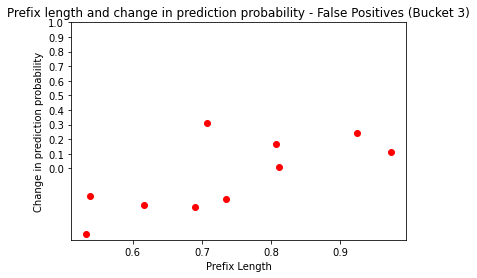

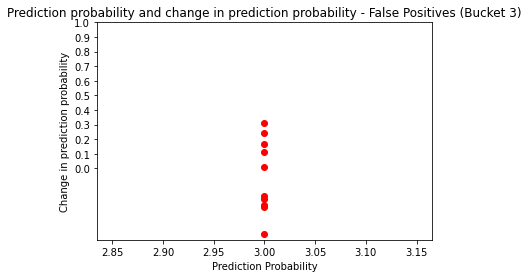

Bucket 4
Generating distributions for bucket
1 of 324 features
2 of 324 features
3 of 324 features
4 of 324 features
5 of 324 features
6 of 324 features
7 of 324 features
8 of 324 features
9 of 324 features
10 of 324 features
11 of 324 features
12 of 324 features
13 of 324 features
14 of 324 features
15 of 324 features
16 of 324 features
17 of 324 features
18 of 324 features
19 of 324 features
20 of 324 features
21 of 324 features
22 of 324 features
23 of 324 features
24 of 324 features
25 of 324 features
26 of 324 features
27 of 324 features
28 of 324 features
29 of 324 features
30 of 324 features
31 of 324 features
32 of 324 features
33 of 324 features
34 of 324 features
35 of 324 features
36 of 324 features
37 of 324 features
38 of 324 features
39 of 324 features
40 of 324 features
41 of 324 features
42 of 324 features
43 of 324 features
44 of 324 features
45 of 324 features
46 of 324 features
47 of 324 features
48 of 324 features
49 of 324 features
50 of 324 features
51 of 324 feat

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 32
Creating distribution for feature 2 of 32
Creating distribution for feature 3 of 32
Creating distribution for feature 4 of 32
Creating distribution for feature 5 of 32
Creating distribution for feature 6 of 32
Creating distribution for feature 7 of 32
Creating distribution for feature 8 of 32
Creating distribution for feature 9 of 32
Creating distribution for feature 10 of 32
Creating distribution for feature 11 of 32
Creating distribution for feature 12 of 32
Creating distribution for feature 13 of 32
Creating distribution for feature 14 of 32
Creating distribution for feature 15 of 32
Creating distribution for feature 16 of 32
Creating distribution for feature 17 of 32
Creating distribution for feature 18 of 32
Creating distribution for feature 19 of 32
Creating distribution for feature 20 of 32
Creating distribution for feature 21 of 32
Creating distribution for feature 22 of 32
Creating di

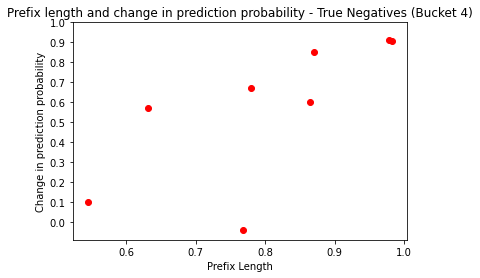

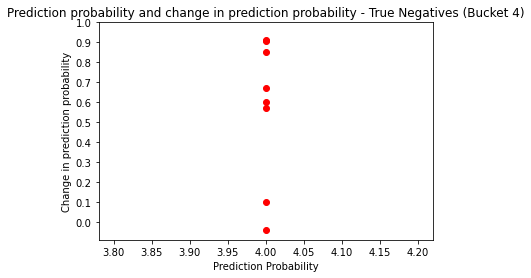

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 32
Creating distribution for feature 2 of 32
Creating distribution for feature 3 of 32
Creating distribution for feature 4 of 32
Creating distribution for feature 5 of 32
Creating distribution for feature 6 of 32
Creating distribution for feature 7 of 32
Creating distribution for feature 8 of 32
Creating distribution for feature 9 of 32
Creating distribution for feature 10 of 32
Creating distribution for feature 11 of 32
Creating distribution for feature 12 of 32
Creating distribution for feature 13 of 32
Creating distribution for feature 14 of 32
Creating distribution for feature 15 of 32
Creating distribution for feature 16 of 32
Creating distribution for feature 17 of 32
Creating distribution for feature 18 of 32
Creating distribution for feature 19 of 32
Creating distribution for feature 20 of 32
Creating distribution for feature 21 of 32
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 32
Creating distribution for feature 2 of 32
Creating distribution for feature 3 of 32
Creating distribution for feature 4 of 32
Creating distribution for feature 5 of 32
Creating distribution for feature 6 of 32
Creating distribution for feature 7 of 32
Creating distribution for feature 8 of 32
Creating distribution for feature 9 of 32
Creating distribution for feature 10 of 32
Creating distribution for feature 11 of 32
Creating distribution for feature 12 of 32
Creating distribution for feature 13 of 32
Creating distribution for feature 14 of 32
Creating distribution for feature 15 of 32
Creating distribution for feature 16 of 32
Creating distribution for feature 17 of 32
Creating distribution for feature 18 of 32
Creating distribution for feature 19 of 32
Creating distribution for feature 20 of 32
Creating distribution for feature 21 of 32
Creating distribution for feature 22 of 32
Creating di

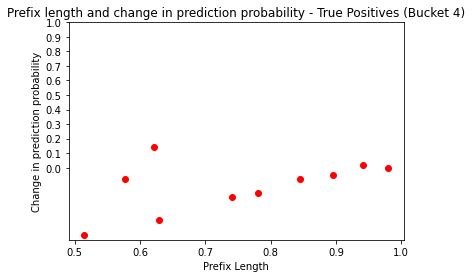

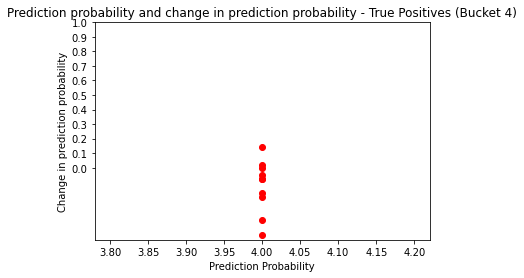

Category 3 of 4. Instance 1 of 8
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 32
Creating distribution for feature 2 of 32
Creating distribution for feature 3 of 32
Creating distribution for feature 4 of 32
Creating distribution for feature 5 of 32
Creating distribution for feature 6 of 32
Creating distribution for feature 7 of 32
Creating distribution for feature 8 of 32
Creating distribution for feature 9 of 32
Creating distribution for feature 10 of 32
Creating distribution for feature 11 of 32
Creating distribution for feature 12 of 32
Creating distribution for feature 13 of 32
Creating distribution for feature 14 of 32
Creating distribution for feature 15 of 32
Creating distribution for feature 16 of 32
Creating distribution for feature 17 of 32
Creating distribution for feature 18 of 32
Creating distribution for feature 19 of 32
Creating distribution for feature 20 of 32
Creating distribution for feature 21 of 32
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 32
Creating distribution for feature 2 of 32
Creating distribution for feature 3 of 32
Creating distribution for feature 4 of 32
Creating distribution for feature 5 of 32
Creating distribution for feature 6 of 32
Creating distribution for feature 7 of 32
Creating distribution for feature 8 of 32
Creating distribution for feature 9 of 32
Creating distribution for feature 10 of 32
Creating distribution for feature 11 of 32
Creating distribution for feature 12 of 32
Creating distribution for feature 13 of 32
Creating distribution for feature 14 of 32
Creating distribution for feature 15 of 32
Creating distribution for feature 16 of 32
Creating distribution for feature 17 of 32
Creating distribution for feature 18 of 32
Creating distribution for feature 19 of 32
Creating distribution for feature 20 of 32
Creating distribution for feature 21 of 32
Creating distribution for feature 22 of 32
Creating di

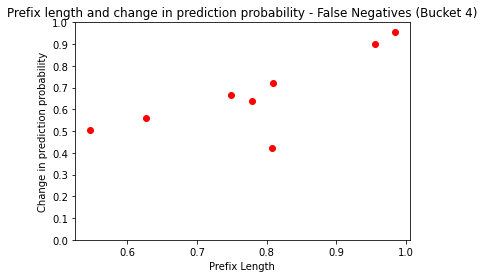

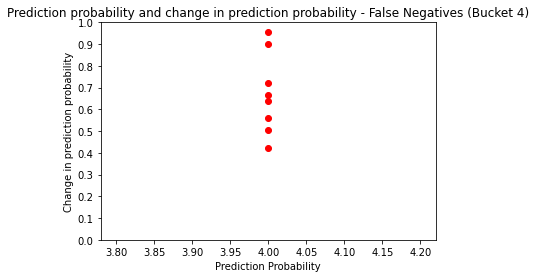

Category 4 of 4. Instance 1 of 7
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 32
Creating distribution for feature 2 of 32
Creating distribution for feature 3 of 32
Creating distribution for feature 4 of 32
Creating distribution for feature 5 of 32
Creating distribution for feature 6 of 32
Creating distribution for feature 7 of 32
Creating distribution for feature 8 of 32
Creating distribution for feature 9 of 32
Creating distribution for feature 10 of 32
Creating distribution for feature 11 of 32
Creating distribution for feature 12 of 32
Creating distribution for feature 13 of 32
Creating distribution for feature 14 of 32
Creating distribution for feature 15 of 32
Creating distribution for feature 16 of 32
Creating distribution for feature 17 of 32
Creating distribution for feature 18 of 32
Creating distribution for feature 19 of 32
Creating distribution for feature 20 of 32
Creating distribution for feature 21 of 32
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 32
Creating distribution for feature 2 of 32
Creating distribution for feature 3 of 32
Creating distribution for feature 4 of 32
Creating distribution for feature 5 of 32
Creating distribution for feature 6 of 32
Creating distribution for feature 7 of 32
Creating distribution for feature 8 of 32
Creating distribution for feature 9 of 32
Creating distribution for feature 10 of 32
Creating distribution for feature 11 of 32
Creating distribution for feature 12 of 32
Creating distribution for feature 13 of 32
Creating distribution for feature 14 of 32
Creating distribution for feature 15 of 32
Creating distribution for feature 16 of 32
Creating distribution for feature 17 of 32
Creating distribution for feature 18 of 32
Creating distribution for feature 19 of 32
Creating distribution for feature 20 of 32
Creating distribution for feature 21 of 32
Creating distribution for feature 22 of 32
Creating di

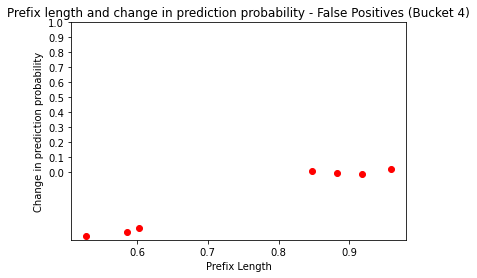

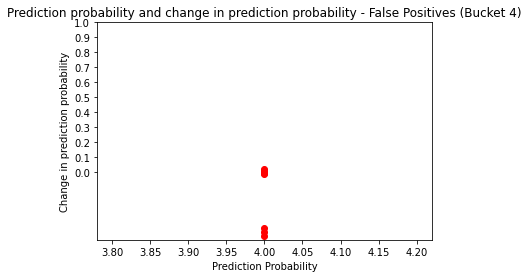

Bucket 5
Generating distributions for bucket
1 of 397 features
2 of 397 features
3 of 397 features
4 of 397 features
5 of 397 features
6 of 397 features
7 of 397 features
8 of 397 features
9 of 397 features
10 of 397 features
11 of 397 features
12 of 397 features
13 of 397 features
14 of 397 features
15 of 397 features
16 of 397 features
17 of 397 features
18 of 397 features
19 of 397 features
20 of 397 features
21 of 397 features
22 of 397 features
23 of 397 features
24 of 397 features
25 of 397 features
26 of 397 features
27 of 397 features
28 of 397 features
29 of 397 features
30 of 397 features
31 of 397 features
32 of 397 features
33 of 397 features
34 of 397 features
35 of 397 features
36 of 397 features
37 of 397 features
38 of 397 features
39 of 397 features
40 of 397 features
41 of 397 features
42 of 397 features
43 of 397 features
44 of 397 features
45 of 397 features
46 of 397 features
47 of 397 features
48 of 397 features
49 of 397 features
50 of 397 features
51 of 397 feat

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 40
Creating distribution for feature 2 of 40
Creating distribution for feature 3 of 40
Creating distribution for feature 4 of 40
Creating distribution for feature 5 of 40
Creating distribution for feature 6 of 40
Creating distribution for feature 7 of 40
Creating distribution for feature 8 of 40
Creating distribution for feature 9 of 40
Creating distribution for feature 10 of 40
Creating distribution for feature 11 of 40
Creating distribution for feature 12 of 40
Creating distribution for feature 13 of 40
Creating distribution for feature 14 of 40
Creating distribution for feature 15 of 40
Creating distribution for feature 16 of 40
Creating distribution for feature 17 of 40
Creating distribution for feature 18 of 40
Creating distribution for feature 19 of 40
Creating distribution for feature 20 of 40
Creating distribution for feature 21 of 40
Creating distribution for feature 22 of 40
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 40
Creating distribution for feature 2 of 40
Creating distribution for feature 3 of 40
Creating distribution for feature 4 of 40
Creating distribution for feature 5 of 40
Creating distribution for feature 6 of 40
Creating distribution for feature 7 of 40
Creating distribution for feature 8 of 40
Creating distribution for feature 9 of 40
Creating distribution for feature 10 of 40
Creating distribution for feature 11 of 40
Creating distribution for feature 12 of 40
Creating distribution for feature 13 of 40
Creating distribution for feature 14 of 40
Creating distribution for feature 15 of 40
Creating distribution for feature 16 of 40
Creating distribution for feature 17 of 40
Creating distribution for feature 18 of 40
Creating distribution for feature 19 of 40
Creating distribution for feature 20 of 40
Creating distribution for feature 21 of 40
Creating distribution for feature 22 of 40
Creating di

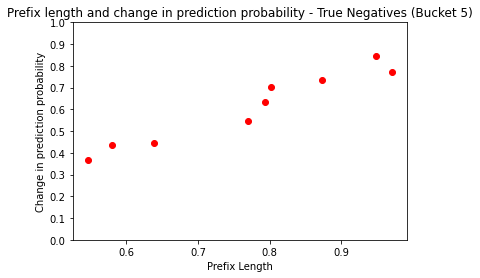

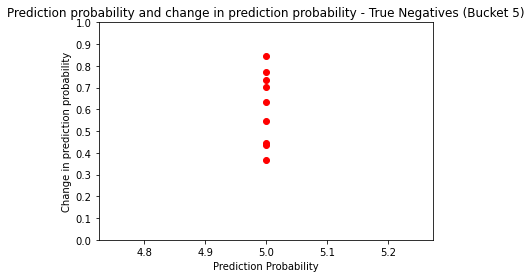

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 40
Creating distribution for feature 2 of 40
Creating distribution for feature 3 of 40
Creating distribution for feature 4 of 40
Creating distribution for feature 5 of 40
Creating distribution for feature 6 of 40
Creating distribution for feature 7 of 40
Creating distribution for feature 8 of 40
Creating distribution for feature 9 of 40
Creating distribution for feature 10 of 40
Creating distribution for feature 11 of 40
Creating distribution for feature 12 of 40
Creating distribution for feature 13 of 40
Creating distribution for feature 14 of 40
Creating distribution for feature 15 of 40
Creating distribution for feature 16 of 40
Creating distribution for feature 17 of 40
Creating distribution for feature 18 of 40
Creating distribution for feature 19 of 40
Creating distribution for feature 20 of 40
Creating distribution for feature 21 of 40
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 40
Creating distribution for feature 2 of 40
Creating distribution for feature 3 of 40
Creating distribution for feature 4 of 40
Creating distribution for feature 5 of 40
Creating distribution for feature 6 of 40
Creating distribution for feature 7 of 40
Creating distribution for feature 8 of 40
Creating distribution for feature 9 of 40
Creating distribution for feature 10 of 40
Creating distribution for feature 11 of 40
Creating distribution for feature 12 of 40
Creating distribution for feature 13 of 40
Creating distribution for feature 14 of 40
Creating distribution for feature 15 of 40
Creating distribution for feature 16 of 40
Creating distribution for feature 17 of 40
Creating distribution for feature 18 of 40
Creating distribution for feature 19 of 40
Creating distribution for feature 20 of 40
Creating distribution for feature 21 of 40
Creating distribution for feature 22 of 40
Creating di

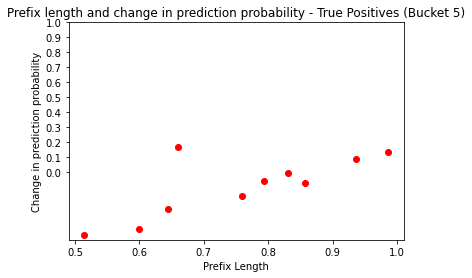

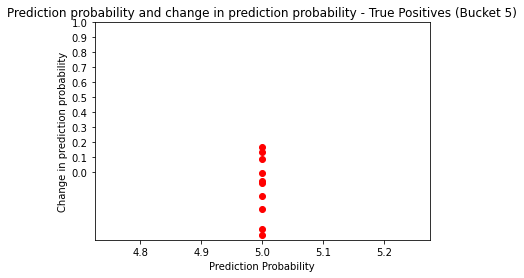

Category 3 of 4. Instance 1 of 7
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 40
Creating distribution for feature 2 of 40
Creating distribution for feature 3 of 40
Creating distribution for feature 4 of 40
Creating distribution for feature 5 of 40
Creating distribution for feature 6 of 40
Creating distribution for feature 7 of 40
Creating distribution for feature 8 of 40
Creating distribution for feature 9 of 40
Creating distribution for feature 10 of 40
Creating distribution for feature 11 of 40
Creating distribution for feature 12 of 40
Creating distribution for feature 13 of 40
Creating distribution for feature 14 of 40
Creating distribution for feature 15 of 40
Creating distribution for feature 16 of 40
Creating distribution for feature 17 of 40
Creating distribution for feature 18 of 40
Creating distribution for feature 19 of 40
Creating distribution for feature 20 of 40
Creating distribution for feature 21 of 40
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 40
Creating distribution for feature 2 of 40
Creating distribution for feature 3 of 40
Creating distribution for feature 4 of 40
Creating distribution for feature 5 of 40
Creating distribution for feature 6 of 40
Creating distribution for feature 7 of 40
Creating distribution for feature 8 of 40
Creating distribution for feature 9 of 40
Creating distribution for feature 10 of 40
Creating distribution for feature 11 of 40
Creating distribution for feature 12 of 40
Creating distribution for feature 13 of 40
Creating distribution for feature 14 of 40
Creating distribution for feature 15 of 40
Creating distribution for feature 16 of 40
Creating distribution for feature 17 of 40
Creating distribution for feature 18 of 40
Creating distribution for feature 19 of 40
Creating distribution for feature 20 of 40
Creating distribution for feature 21 of 40
Creating distribution for feature 22 of 40
Creating di

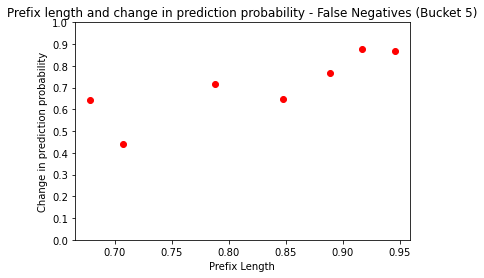

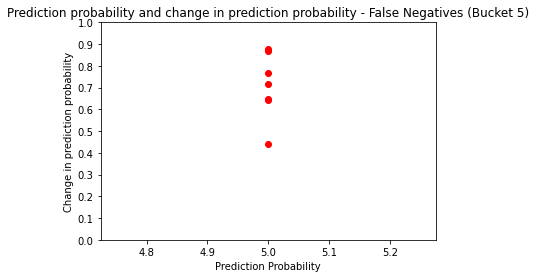

Category 4 of 4. Instance 1 of 9
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 40
Creating distribution for feature 2 of 40
Creating distribution for feature 3 of 40
Creating distribution for feature 4 of 40
Creating distribution for feature 5 of 40
Creating distribution for feature 6 of 40
Creating distribution for feature 7 of 40
Creating distribution for feature 8 of 40
Creating distribution for feature 9 of 40
Creating distribution for feature 10 of 40
Creating distribution for feature 11 of 40
Creating distribution for feature 12 of 40
Creating distribution for feature 13 of 40
Creating distribution for feature 14 of 40
Creating distribution for feature 15 of 40
Creating distribution for feature 16 of 40
Creating distribution for feature 17 of 40
Creating distribution for feature 18 of 40
Creating distribution for feature 19 of 40
Creating distribution for feature 20 of 40
Creating distribution for feature 21 of 40
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 40
Creating distribution for feature 2 of 40
Creating distribution for feature 3 of 40
Creating distribution for feature 4 of 40
Creating distribution for feature 5 of 40
Creating distribution for feature 6 of 40
Creating distribution for feature 7 of 40
Creating distribution for feature 8 of 40
Creating distribution for feature 9 of 40
Creating distribution for feature 10 of 40
Creating distribution for feature 11 of 40
Creating distribution for feature 12 of 40
Creating distribution for feature 13 of 40
Creating distribution for feature 14 of 40
Creating distribution for feature 15 of 40
Creating distribution for feature 16 of 40
Creating distribution for feature 17 of 40
Creating distribution for feature 18 of 40
Creating distribution for feature 19 of 40
Creating distribution for feature 20 of 40
Creating distribution for feature 21 of 40
Creating distribution for feature 22 of 40
Creating di

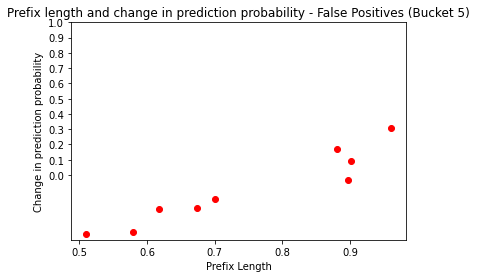

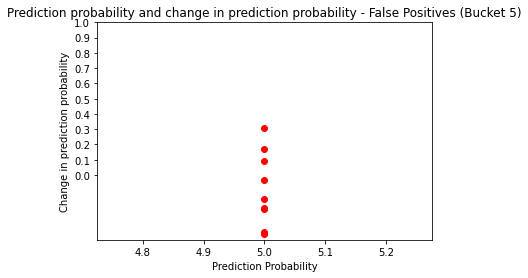

Bucket 6
Generating distributions for bucket
1 of 470 features
2 of 470 features
3 of 470 features
4 of 470 features
5 of 470 features
6 of 470 features
7 of 470 features
8 of 470 features
9 of 470 features
10 of 470 features
11 of 470 features
12 of 470 features
13 of 470 features
14 of 470 features
15 of 470 features
16 of 470 features
17 of 470 features
18 of 470 features
19 of 470 features
20 of 470 features
21 of 470 features
22 of 470 features
23 of 470 features
24 of 470 features
25 of 470 features
26 of 470 features
27 of 470 features
28 of 470 features
29 of 470 features
30 of 470 features
31 of 470 features
32 of 470 features
33 of 470 features
34 of 470 features
35 of 470 features
36 of 470 features
37 of 470 features
38 of 470 features
39 of 470 features
40 of 470 features
41 of 470 features
42 of 470 features
43 of 470 features
44 of 470 features
45 of 470 features
46 of 470 features
47 of 470 features
48 of 470 features
49 of 470 features
50 of 470 features
51 of 470 feat

418 of 470 features
419 of 470 features
420 of 470 features
421 of 470 features
422 of 470 features
423 of 470 features
424 of 470 features
425 of 470 features
426 of 470 features
427 of 470 features
428 of 470 features
429 of 470 features
430 of 470 features
431 of 470 features
432 of 470 features
433 of 470 features
434 of 470 features
435 of 470 features
436 of 470 features
437 of 470 features
438 of 470 features
439 of 470 features
440 of 470 features
441 of 470 features
442 of 470 features
443 of 470 features
444 of 470 features
445 of 470 features
446 of 470 features
447 of 470 features
448 of 470 features
449 of 470 features
450 of 470 features
451 of 470 features
452 of 470 features
453 of 470 features
454 of 470 features
455 of 470 features
456 of 470 features
457 of 470 features
458 of 470 features
459 of 470 features
460 of 470 features
461 of 470 features
462 of 470 features
463 of 470 features
464 of 470 features
465 of 470 features
466 of 470 features
467 of 470 features


Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 47
Creating distribution for feature 2 of 47
Creating distribution for feature 3 of 47
Creating distribution for feature 4 of 47
Creating distribution for feature 5 of 47
Creating distribution for feature 6 of 47
Creating distribution for feature 7 of 47
Creating distribution for feature 8 of 47
Creating distribution for feature 9 of 47
Creating distribution for feature 10 of 47
Creating distribution for feature 11 of 47
Creating distribution for feature 12 of 47
Creating distribution for feature 13 of 47
Creating distribution for feature 14 of 47
Creating distribution for feature 15 of 47
Creating distribution for feature 16 of 47
Creating distribution for feature 17 of 47
Creating distribution for feature 18 of 47
Creating distribution for feature 19 of 47
Creating distribution for feature 20 of 47
Creating distribution for feature 21 of 47
Creating distribution for feature 22 of 47
Creating di

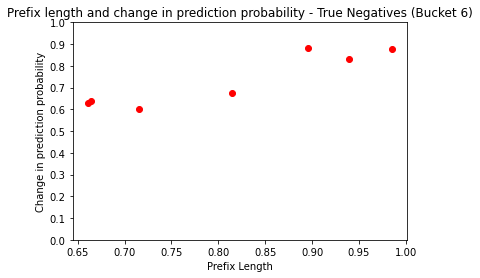

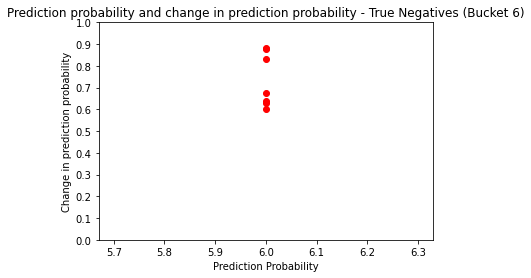

Category 2 of 4. Instance 1 of 7
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 47
Creating distribution for feature 2 of 47
Creating distribution for feature 3 of 47
Creating distribution for feature 4 of 47
Creating distribution for feature 5 of 47
Creating distribution for feature 6 of 47
Creating distribution for feature 7 of 47
Creating distribution for feature 8 of 47
Creating distribution for feature 9 of 47
Creating distribution for feature 10 of 47
Creating distribution for feature 11 of 47
Creating distribution for feature 12 of 47
Creating distribution for feature 13 of 47
Creating distribution for feature 14 of 47
Creating distribution for feature 15 of 47
Creating distribution for feature 16 of 47
Creating distribution for feature 17 of 47
Creating distribution for feature 18 of 47
Creating distribution for feature 19 of 47
Creating distribution for feature 20 of 47
Creating distribution for feature 21 of 47
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 47
Creating distribution for feature 2 of 47
Creating distribution for feature 3 of 47
Creating distribution for feature 4 of 47
Creating distribution for feature 5 of 47
Creating distribution for feature 6 of 47
Creating distribution for feature 7 of 47
Creating distribution for feature 8 of 47
Creating distribution for feature 9 of 47
Creating distribution for feature 10 of 47
Creating distribution for feature 11 of 47
Creating distribution for feature 12 of 47
Creating distribution for feature 13 of 47
Creating distribution for feature 14 of 47
Creating distribution for feature 15 of 47
Creating distribution for feature 16 of 47
Creating distribution for feature 17 of 47
Creating distribution for feature 18 of 47
Creating distribution for feature 19 of 47
Creating distribution for feature 20 of 47
Creating distribution for feature 21 of 47
Creating distribution for feature 22 of 47
Creating di

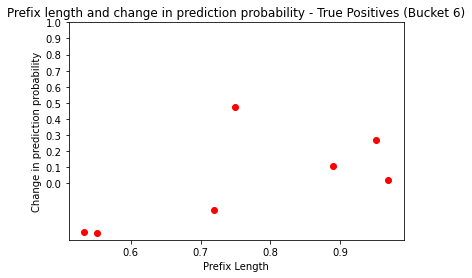

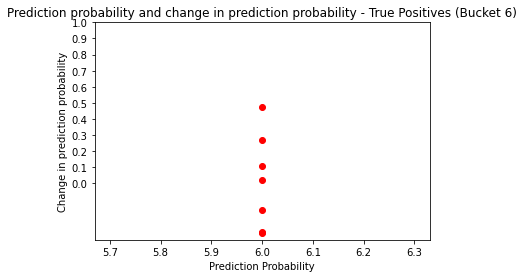

Category 3 of 4. Instance 1 of 9
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 47
Creating distribution for feature 2 of 47
Creating distribution for feature 3 of 47
Creating distribution for feature 4 of 47
Creating distribution for feature 5 of 47
Creating distribution for feature 6 of 47
Creating distribution for feature 7 of 47
Creating distribution for feature 8 of 47
Creating distribution for feature 9 of 47
Creating distribution for feature 10 of 47
Creating distribution for feature 11 of 47
Creating distribution for feature 12 of 47
Creating distribution for feature 13 of 47
Creating distribution for feature 14 of 47
Creating distribution for feature 15 of 47
Creating distribution for feature 16 of 47
Creating distribution for feature 17 of 47
Creating distribution for feature 18 of 47
Creating distribution for feature 19 of 47
Creating distribution for feature 20 of 47
Creating distribution for feature 21 of 47
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 47
Creating distribution for feature 2 of 47
Creating distribution for feature 3 of 47
Creating distribution for feature 4 of 47
Creating distribution for feature 5 of 47
Creating distribution for feature 6 of 47
Creating distribution for feature 7 of 47
Creating distribution for feature 8 of 47
Creating distribution for feature 9 of 47
Creating distribution for feature 10 of 47
Creating distribution for feature 11 of 47
Creating distribution for feature 12 of 47
Creating distribution for feature 13 of 47
Creating distribution for feature 14 of 47
Creating distribution for feature 15 of 47
Creating distribution for feature 16 of 47
Creating distribution for feature 17 of 47
Creating distribution for feature 18 of 47
Creating distribution for feature 19 of 47
Creating distribution for feature 20 of 47
Creating distribution for feature 21 of 47
Creating distribution for feature 22 of 47
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 47
Creating distribution for feature 2 of 47
Creating distribution for feature 3 of 47
Creating distribution for feature 4 of 47
Creating distribution for feature 5 of 47
Creating distribution for feature 6 of 47
Creating distribution for feature 7 of 47
Creating distribution for feature 8 of 47
Creating distribution for feature 9 of 47
Creating distribution for feature 10 of 47
Creating distribution for feature 11 of 47
Creating distribution for feature 12 of 47
Creating distribution for feature 13 of 47
Creating distribution for feature 14 of 47
Creating distribution for feature 15 of 47
Creating distribution for feature 16 of 47
Creating distribution for feature 17 of 47
Creating distribution for feature 18 of 47
Creating distribution for feature 19 of 47
Creating distribution for feature 20 of 47
Creating distribution for feature 21 of 47
Creating distribution for feature 22 of 47
Creating di

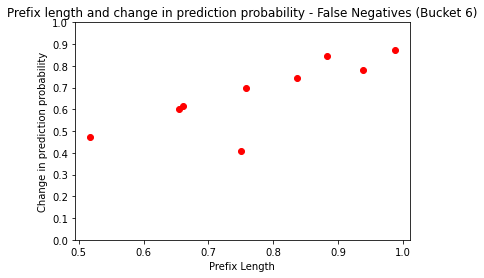

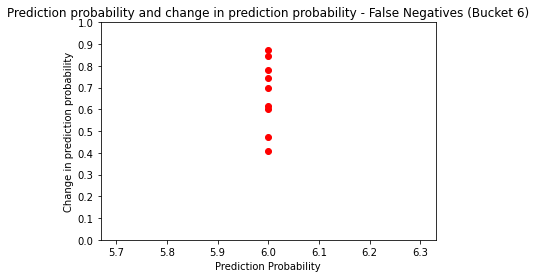

Category 4 of 4. Instance 1 of 8
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 47
Creating distribution for feature 2 of 47
Creating distribution for feature 3 of 47
Creating distribution for feature 4 of 47
Creating distribution for feature 5 of 47
Creating distribution for feature 6 of 47
Creating distribution for feature 7 of 47
Creating distribution for feature 8 of 47
Creating distribution for feature 9 of 47
Creating distribution for feature 10 of 47
Creating distribution for feature 11 of 47
Creating distribution for feature 12 of 47
Creating distribution for feature 13 of 47
Creating distribution for feature 14 of 47
Creating distribution for feature 15 of 47
Creating distribution for feature 16 of 47
Creating distribution for feature 17 of 47
Creating distribution for feature 18 of 47
Creating distribution for feature 19 of 47
Creating distribution for feature 20 of 47
Creating distribution for feature 21 of 47
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 47
Creating distribution for feature 2 of 47
Creating distribution for feature 3 of 47
Creating distribution for feature 4 of 47
Creating distribution for feature 5 of 47
Creating distribution for feature 6 of 47
Creating distribution for feature 7 of 47
Creating distribution for feature 8 of 47
Creating distribution for feature 9 of 47
Creating distribution for feature 10 of 47
Creating distribution for feature 11 of 47
Creating distribution for feature 12 of 47
Creating distribution for feature 13 of 47
Creating distribution for feature 14 of 47
Creating distribution for feature 15 of 47
Creating distribution for feature 16 of 47
Creating distribution for feature 17 of 47
Creating distribution for feature 18 of 47
Creating distribution for feature 19 of 47
Creating distribution for feature 20 of 47
Creating distribution for feature 21 of 47
Creating distribution for feature 22 of 47
Creating di

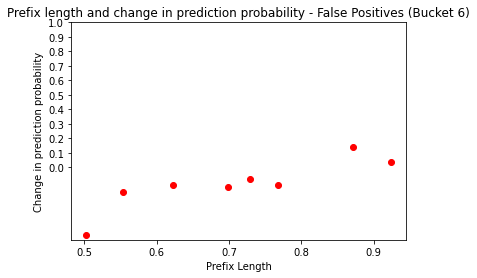

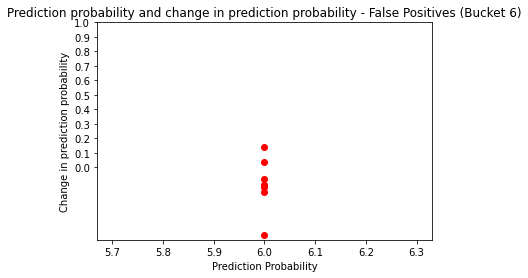

Bucket 7
Generating distributions for bucket
1 of 521 features
2 of 521 features
3 of 521 features
4 of 521 features
5 of 521 features
6 of 521 features
7 of 521 features
8 of 521 features
9 of 521 features
10 of 521 features
11 of 521 features
12 of 521 features
13 of 521 features
14 of 521 features
15 of 521 features
16 of 521 features
17 of 521 features
18 of 521 features
19 of 521 features
20 of 521 features
21 of 521 features
22 of 521 features
23 of 521 features
24 of 521 features
25 of 521 features
26 of 521 features
27 of 521 features
28 of 521 features
29 of 521 features
30 of 521 features
31 of 521 features
32 of 521 features
33 of 521 features
34 of 521 features
35 of 521 features
36 of 521 features
37 of 521 features
38 of 521 features
39 of 521 features
40 of 521 features
41 of 521 features
42 of 521 features
43 of 521 features
44 of 521 features
45 of 521 features
46 of 521 features
47 of 521 features
48 of 521 features
49 of 521 features
50 of 521 features
51 of 521 feat

456 of 521 features
457 of 521 features
458 of 521 features
459 of 521 features
460 of 521 features
461 of 521 features
462 of 521 features
463 of 521 features
464 of 521 features
465 of 521 features
466 of 521 features
467 of 521 features
468 of 521 features
469 of 521 features
470 of 521 features
471 of 521 features
472 of 521 features
473 of 521 features
474 of 521 features
475 of 521 features
476 of 521 features
477 of 521 features
478 of 521 features
479 of 521 features
480 of 521 features
481 of 521 features
482 of 521 features
483 of 521 features
484 of 521 features
485 of 521 features
486 of 521 features
487 of 521 features
488 of 521 features
489 of 521 features
490 of 521 features
491 of 521 features
492 of 521 features
493 of 521 features
494 of 521 features
495 of 521 features
496 of 521 features
497 of 521 features
498 of 521 features
499 of 521 features
500 of 521 features
501 of 521 features
502 of 521 features
503 of 521 features
504 of 521 features
505 of 521 features


Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 52
Creating distribution for feature 2 of 52
Creating distribution for feature 3 of 52
Creating distribution for feature 4 of 52
Creating distribution for feature 5 of 52
Creating distribution for feature 6 of 52
Creating distribution for feature 7 of 52
Creating distribution for feature 8 of 52
Creating distribution for feature 9 of 52
Creating distribution for feature 10 of 52
Creating distribution for feature 11 of 52
Creating distribution for feature 12 of 52
Creating distribution for feature 13 of 52
Creating distribution for feature 14 of 52
Creating distribution for feature 15 of 52
Creating distribution for feature 16 of 52
Creating distribution for feature 17 of 52
Creating distribution for feature 18 of 52
Creating distribution for feature 19 of 52
Creating distribution for feature 20 of 52
Creating distribution for feature 21 of 52
Creating distribution for feature 22 of 52
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 52
Creating distribution for feature 2 of 52
Creating distribution for feature 3 of 52
Creating distribution for feature 4 of 52
Creating distribution for feature 5 of 52
Creating distribution for feature 6 of 52
Creating distribution for feature 7 of 52
Creating distribution for feature 8 of 52
Creating distribution for feature 9 of 52
Creating distribution for feature 10 of 52
Creating distribution for feature 11 of 52
Creating distribution for feature 12 of 52
Creating distribution for feature 13 of 52
Creating distribution for feature 14 of 52
Creating distribution for feature 15 of 52
Creating distribution for feature 16 of 52
Creating distribution for feature 17 of 52
Creating distribution for feature 18 of 52
Creating distribution for feature 19 of 52
Creating distribution for feature 20 of 52
Creating distribution for feature 21 of 52
Creating distribution for feature 22 of 52
Creating di

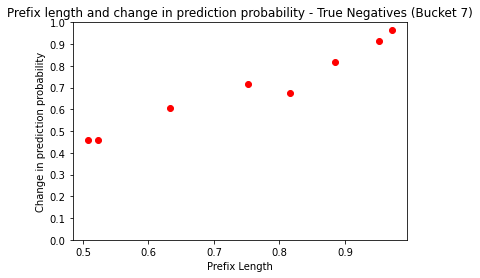

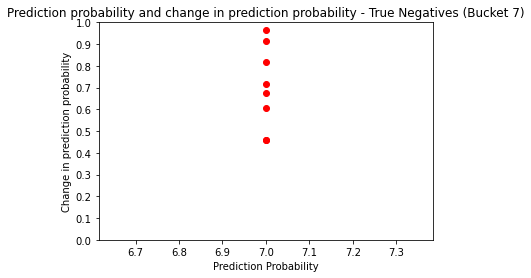

Category 2 of 4. Instance 1 of 8
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 52
Creating distribution for feature 2 of 52
Creating distribution for feature 3 of 52
Creating distribution for feature 4 of 52
Creating distribution for feature 5 of 52
Creating distribution for feature 6 of 52
Creating distribution for feature 7 of 52
Creating distribution for feature 8 of 52
Creating distribution for feature 9 of 52
Creating distribution for feature 10 of 52
Creating distribution for feature 11 of 52
Creating distribution for feature 12 of 52
Creating distribution for feature 13 of 52
Creating distribution for feature 14 of 52
Creating distribution for feature 15 of 52
Creating distribution for feature 16 of 52
Creating distribution for feature 17 of 52
Creating distribution for feature 18 of 52
Creating distribution for feature 19 of 52
Creating distribution for feature 20 of 52
Creating distribution for feature 21 of 52
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 52
Creating distribution for feature 2 of 52
Creating distribution for feature 3 of 52
Creating distribution for feature 4 of 52
Creating distribution for feature 5 of 52
Creating distribution for feature 6 of 52
Creating distribution for feature 7 of 52
Creating distribution for feature 8 of 52
Creating distribution for feature 9 of 52
Creating distribution for feature 10 of 52
Creating distribution for feature 11 of 52
Creating distribution for feature 12 of 52
Creating distribution for feature 13 of 52
Creating distribution for feature 14 of 52
Creating distribution for feature 15 of 52
Creating distribution for feature 16 of 52
Creating distribution for feature 17 of 52
Creating distribution for feature 18 of 52
Creating distribution for feature 19 of 52
Creating distribution for feature 20 of 52
Creating distribution for feature 21 of 52
Creating distribution for feature 22 of 52
Creating di

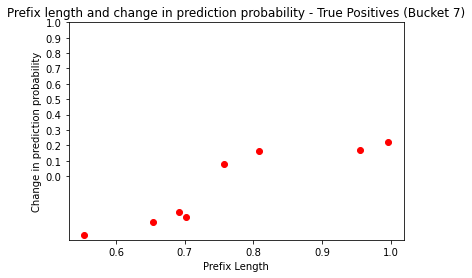

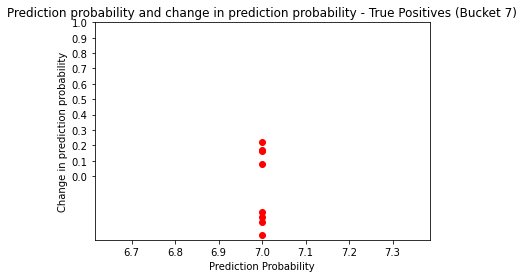

Category 3 of 4. Instance 1 of 8
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 52
Creating distribution for feature 2 of 52
Creating distribution for feature 3 of 52
Creating distribution for feature 4 of 52
Creating distribution for feature 5 of 52
Creating distribution for feature 6 of 52
Creating distribution for feature 7 of 52
Creating distribution for feature 8 of 52
Creating distribution for feature 9 of 52
Creating distribution for feature 10 of 52
Creating distribution for feature 11 of 52
Creating distribution for feature 12 of 52
Creating distribution for feature 13 of 52
Creating distribution for feature 14 of 52
Creating distribution for feature 15 of 52
Creating distribution for feature 16 of 52
Creating distribution for feature 17 of 52
Creating distribution for feature 18 of 52
Creating distribution for feature 19 of 52
Creating distribution for feature 20 of 52
Creating distribution for feature 21 of 52
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 52
Creating distribution for feature 2 of 52
Creating distribution for feature 3 of 52
Creating distribution for feature 4 of 52
Creating distribution for feature 5 of 52
Creating distribution for feature 6 of 52
Creating distribution for feature 7 of 52
Creating distribution for feature 8 of 52
Creating distribution for feature 9 of 52
Creating distribution for feature 10 of 52
Creating distribution for feature 11 of 52
Creating distribution for feature 12 of 52
Creating distribution for feature 13 of 52
Creating distribution for feature 14 of 52
Creating distribution for feature 15 of 52
Creating distribution for feature 16 of 52
Creating distribution for feature 17 of 52
Creating distribution for feature 18 of 52
Creating distribution for feature 19 of 52
Creating distribution for feature 20 of 52
Creating distribution for feature 21 of 52
Creating distribution for feature 22 of 52
Creating di

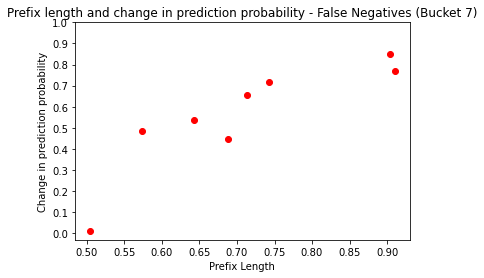

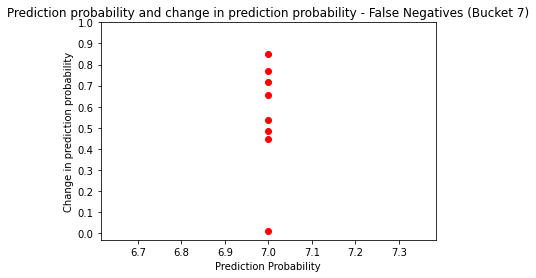

Category 4 of 4. Instance 1 of 7
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 52
Creating distribution for feature 2 of 52
Creating distribution for feature 3 of 52
Creating distribution for feature 4 of 52
Creating distribution for feature 5 of 52
Creating distribution for feature 6 of 52
Creating distribution for feature 7 of 52
Creating distribution for feature 8 of 52
Creating distribution for feature 9 of 52
Creating distribution for feature 10 of 52
Creating distribution for feature 11 of 52
Creating distribution for feature 12 of 52
Creating distribution for feature 13 of 52
Creating distribution for feature 14 of 52
Creating distribution for feature 15 of 52
Creating distribution for feature 16 of 52
Creating distribution for feature 17 of 52
Creating distribution for feature 18 of 52
Creating distribution for feature 19 of 52
Creating distribution for feature 20 of 52
Creating distribution for feature 21 of 52
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 52
Creating distribution for feature 2 of 52
Creating distribution for feature 3 of 52
Creating distribution for feature 4 of 52
Creating distribution for feature 5 of 52
Creating distribution for feature 6 of 52
Creating distribution for feature 7 of 52
Creating distribution for feature 8 of 52
Creating distribution for feature 9 of 52
Creating distribution for feature 10 of 52
Creating distribution for feature 11 of 52
Creating distribution for feature 12 of 52
Creating distribution for feature 13 of 52
Creating distribution for feature 14 of 52
Creating distribution for feature 15 of 52
Creating distribution for feature 16 of 52
Creating distribution for feature 17 of 52
Creating distribution for feature 18 of 52
Creating distribution for feature 19 of 52
Creating distribution for feature 20 of 52
Creating distribution for feature 21 of 52
Creating distribution for feature 22 of 52
Creating di

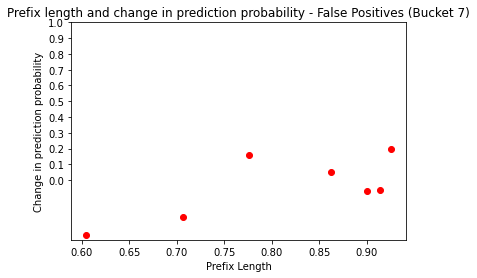

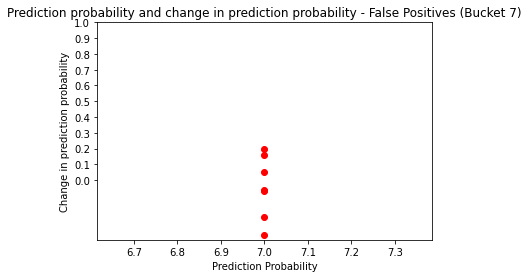

Bucket 8
Generating distributions for bucket
1 of 593 features
2 of 593 features
3 of 593 features
4 of 593 features
5 of 593 features
6 of 593 features
7 of 593 features
8 of 593 features
9 of 593 features
10 of 593 features
11 of 593 features
12 of 593 features
13 of 593 features
14 of 593 features
15 of 593 features
16 of 593 features
17 of 593 features
18 of 593 features
19 of 593 features
20 of 593 features
21 of 593 features
22 of 593 features
23 of 593 features
24 of 593 features
25 of 593 features
26 of 593 features
27 of 593 features
28 of 593 features
29 of 593 features
30 of 593 features
31 of 593 features
32 of 593 features
33 of 593 features
34 of 593 features
35 of 593 features
36 of 593 features
37 of 593 features
38 of 593 features
39 of 593 features
40 of 593 features
41 of 593 features
42 of 593 features
43 of 593 features
44 of 593 features
45 of 593 features
46 of 593 features
47 of 593 features
48 of 593 features
49 of 593 features
50 of 593 features
51 of 593 feat

478 of 593 features
479 of 593 features
480 of 593 features
481 of 593 features
482 of 593 features
483 of 593 features
484 of 593 features
485 of 593 features
486 of 593 features
487 of 593 features
488 of 593 features
489 of 593 features
490 of 593 features
491 of 593 features
492 of 593 features
493 of 593 features
494 of 593 features
495 of 593 features
496 of 593 features
497 of 593 features
498 of 593 features
499 of 593 features
500 of 593 features
501 of 593 features
502 of 593 features
503 of 593 features
504 of 593 features
505 of 593 features
506 of 593 features
507 of 593 features
508 of 593 features
509 of 593 features
510 of 593 features
511 of 593 features
512 of 593 features
513 of 593 features
514 of 593 features
515 of 593 features
516 of 593 features
517 of 593 features
518 of 593 features
519 of 593 features
520 of 593 features
521 of 593 features
522 of 593 features
523 of 593 features
524 of 593 features
525 of 593 features
526 of 593 features
527 of 593 features


Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 59
Creating distribution for feature 2 of 59
Creating distribution for feature 3 of 59
Creating distribution for feature 4 of 59
Creating distribution for feature 5 of 59
Creating distribution for feature 6 of 59
Creating distribution for feature 7 of 59
Creating distribution for feature 8 of 59
Creating distribution for feature 9 of 59
Creating distribution for feature 10 of 59
Creating distribution for feature 11 of 59
Creating distribution for feature 12 of 59
Creating distribution for feature 13 of 59
Creating distribution for feature 14 of 59
Creating distribution for feature 15 of 59
Creating distribution for feature 16 of 59
Creating distribution for feature 17 of 59
Creating distribution for feature 18 of 59
Creating distribution for feature 19 of 59
Creating distribution for feature 20 of 59
Creating distribution for feature 21 of 59
Creating distribution for feature 22 of 59
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 59
Creating distribution for feature 2 of 59
Creating distribution for feature 3 of 59
Creating distribution for feature 4 of 59
Creating distribution for feature 5 of 59
Creating distribution for feature 6 of 59
Creating distribution for feature 7 of 59
Creating distribution for feature 8 of 59
Creating distribution for feature 9 of 59
Creating distribution for feature 10 of 59
Creating distribution for feature 11 of 59
Creating distribution for feature 12 of 59
Creating distribution for feature 13 of 59
Creating distribution for feature 14 of 59
Creating distribution for feature 15 of 59
Creating distribution for feature 16 of 59
Creating distribution for feature 17 of 59
Creating distribution for feature 18 of 59
Creating distribution for feature 19 of 59
Creating distribution for feature 20 of 59
Creating distribution for feature 21 of 59
Creating distribution for feature 22 of 59
Creating di

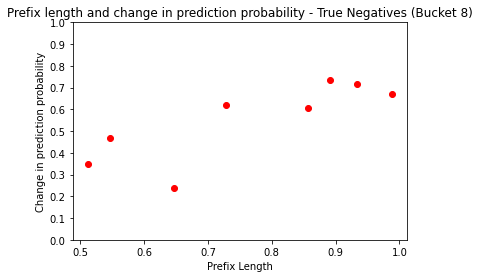

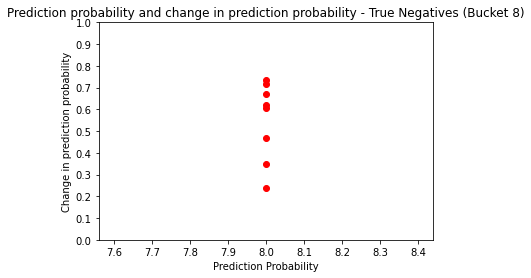

Category 2 of 4. Instance 1 of 6
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 59
Creating distribution for feature 2 of 59
Creating distribution for feature 3 of 59
Creating distribution for feature 4 of 59
Creating distribution for feature 5 of 59
Creating distribution for feature 6 of 59
Creating distribution for feature 7 of 59
Creating distribution for feature 8 of 59
Creating distribution for feature 9 of 59
Creating distribution for feature 10 of 59
Creating distribution for feature 11 of 59
Creating distribution for feature 12 of 59
Creating distribution for feature 13 of 59
Creating distribution for feature 14 of 59
Creating distribution for feature 15 of 59
Creating distribution for feature 16 of 59
Creating distribution for feature 17 of 59
Creating distribution for feature 18 of 59
Creating distribution for feature 19 of 59
Creating distribution for feature 20 of 59
Creating distribution for feature 21 of 59
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 59
Creating distribution for feature 2 of 59
Creating distribution for feature 3 of 59
Creating distribution for feature 4 of 59
Creating distribution for feature 5 of 59
Creating distribution for feature 6 of 59
Creating distribution for feature 7 of 59
Creating distribution for feature 8 of 59
Creating distribution for feature 9 of 59
Creating distribution for feature 10 of 59
Creating distribution for feature 11 of 59
Creating distribution for feature 12 of 59
Creating distribution for feature 13 of 59
Creating distribution for feature 14 of 59
Creating distribution for feature 15 of 59
Creating distribution for feature 16 of 59
Creating distribution for feature 17 of 59
Creating distribution for feature 18 of 59
Creating distribution for feature 19 of 59
Creating distribution for feature 20 of 59
Creating distribution for feature 21 of 59
Creating distribution for feature 22 of 59
Creating di

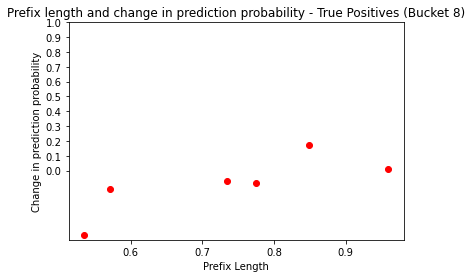

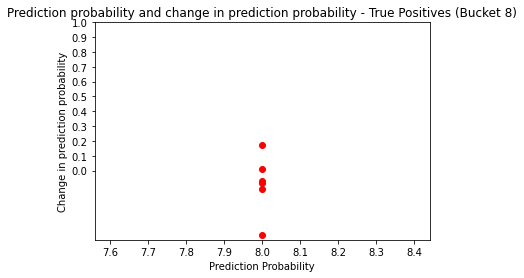

Category 3 of 4. Instance 1 of 9
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 59
Creating distribution for feature 2 of 59
Creating distribution for feature 3 of 59
Creating distribution for feature 4 of 59
Creating distribution for feature 5 of 59
Creating distribution for feature 6 of 59
Creating distribution for feature 7 of 59
Creating distribution for feature 8 of 59
Creating distribution for feature 9 of 59
Creating distribution for feature 10 of 59
Creating distribution for feature 11 of 59
Creating distribution for feature 12 of 59
Creating distribution for feature 13 of 59
Creating distribution for feature 14 of 59
Creating distribution for feature 15 of 59
Creating distribution for feature 16 of 59
Creating distribution for feature 17 of 59
Creating distribution for feature 18 of 59
Creating distribution for feature 19 of 59
Creating distribution for feature 20 of 59
Creating distribution for feature 21 of 59
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 59
Creating distribution for feature 2 of 59
Creating distribution for feature 3 of 59
Creating distribution for feature 4 of 59
Creating distribution for feature 5 of 59
Creating distribution for feature 6 of 59
Creating distribution for feature 7 of 59
Creating distribution for feature 8 of 59
Creating distribution for feature 9 of 59
Creating distribution for feature 10 of 59
Creating distribution for feature 11 of 59
Creating distribution for feature 12 of 59
Creating distribution for feature 13 of 59
Creating distribution for feature 14 of 59
Creating distribution for feature 15 of 59
Creating distribution for feature 16 of 59
Creating distribution for feature 17 of 59
Creating distribution for feature 18 of 59
Creating distribution for feature 19 of 59
Creating distribution for feature 20 of 59
Creating distribution for feature 21 of 59
Creating distribution for feature 22 of 59
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 59
Creating distribution for feature 2 of 59
Creating distribution for feature 3 of 59
Creating distribution for feature 4 of 59
Creating distribution for feature 5 of 59
Creating distribution for feature 6 of 59
Creating distribution for feature 7 of 59
Creating distribution for feature 8 of 59
Creating distribution for feature 9 of 59
Creating distribution for feature 10 of 59
Creating distribution for feature 11 of 59
Creating distribution for feature 12 of 59
Creating distribution for feature 13 of 59
Creating distribution for feature 14 of 59
Creating distribution for feature 15 of 59
Creating distribution for feature 16 of 59
Creating distribution for feature 17 of 59
Creating distribution for feature 18 of 59
Creating distribution for feature 19 of 59
Creating distribution for feature 20 of 59
Creating distribution for feature 21 of 59
Creating distribution for feature 22 of 59
Creating di

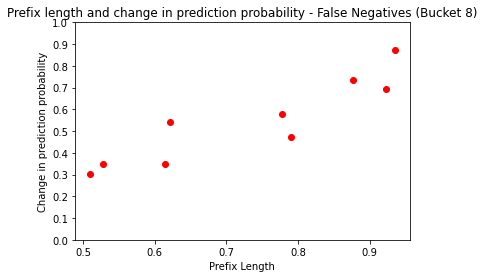

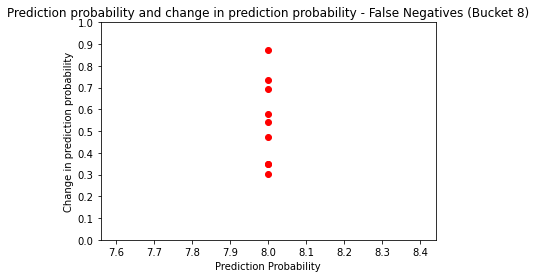

Category 4 of 4. Instance 1 of 5
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 59
Creating distribution for feature 2 of 59
Creating distribution for feature 3 of 59
Creating distribution for feature 4 of 59
Creating distribution for feature 5 of 59
Creating distribution for feature 6 of 59
Creating distribution for feature 7 of 59
Creating distribution for feature 8 of 59
Creating distribution for feature 9 of 59
Creating distribution for feature 10 of 59
Creating distribution for feature 11 of 59
Creating distribution for feature 12 of 59
Creating distribution for feature 13 of 59
Creating distribution for feature 14 of 59
Creating distribution for feature 15 of 59
Creating distribution for feature 16 of 59
Creating distribution for feature 17 of 59
Creating distribution for feature 18 of 59
Creating distribution for feature 19 of 59
Creating distribution for feature 20 of 59
Creating distribution for feature 21 of 59
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 59
Creating distribution for feature 2 of 59
Creating distribution for feature 3 of 59
Creating distribution for feature 4 of 59
Creating distribution for feature 5 of 59
Creating distribution for feature 6 of 59
Creating distribution for feature 7 of 59
Creating distribution for feature 8 of 59
Creating distribution for feature 9 of 59
Creating distribution for feature 10 of 59
Creating distribution for feature 11 of 59
Creating distribution for feature 12 of 59
Creating distribution for feature 13 of 59
Creating distribution for feature 14 of 59
Creating distribution for feature 15 of 59
Creating distribution for feature 16 of 59
Creating distribution for feature 17 of 59
Creating distribution for feature 18 of 59
Creating distribution for feature 19 of 59
Creating distribution for feature 20 of 59
Creating distribution for feature 21 of 59
Creating distribution for feature 22 of 59
Creating di

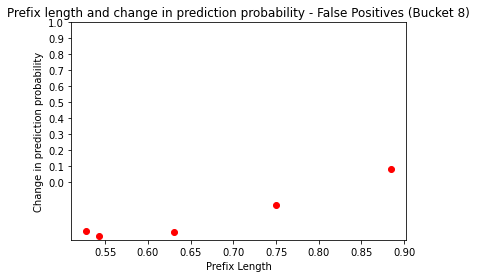

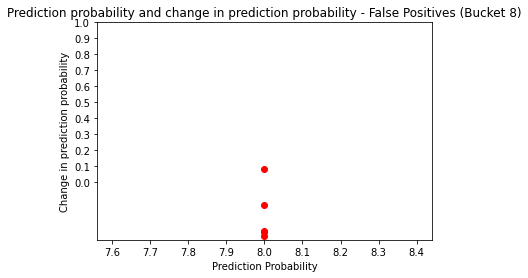

Bucket 9
Generating distributions for bucket
1 of 623 features
2 of 623 features
3 of 623 features
4 of 623 features
5 of 623 features
6 of 623 features
7 of 623 features
8 of 623 features
9 of 623 features
10 of 623 features
11 of 623 features
12 of 623 features
13 of 623 features
14 of 623 features
15 of 623 features
16 of 623 features
17 of 623 features
18 of 623 features
19 of 623 features
20 of 623 features
21 of 623 features
22 of 623 features
23 of 623 features
24 of 623 features
25 of 623 features
26 of 623 features
27 of 623 features
28 of 623 features
29 of 623 features
30 of 623 features
31 of 623 features
32 of 623 features
33 of 623 features
34 of 623 features
35 of 623 features
36 of 623 features
37 of 623 features
38 of 623 features
39 of 623 features
40 of 623 features
41 of 623 features
42 of 623 features
43 of 623 features
44 of 623 features
45 of 623 features
46 of 623 features
47 of 623 features
48 of 623 features
49 of 623 features
50 of 623 features
51 of 623 feat

482 of 623 features
483 of 623 features
484 of 623 features
485 of 623 features
486 of 623 features
487 of 623 features
488 of 623 features
489 of 623 features
490 of 623 features
491 of 623 features
492 of 623 features
493 of 623 features
494 of 623 features
495 of 623 features
496 of 623 features
497 of 623 features
498 of 623 features
499 of 623 features
500 of 623 features
501 of 623 features
502 of 623 features
503 of 623 features
504 of 623 features
505 of 623 features
506 of 623 features
507 of 623 features
508 of 623 features
509 of 623 features
510 of 623 features
511 of 623 features
512 of 623 features
513 of 623 features
514 of 623 features
515 of 623 features
516 of 623 features
517 of 623 features
518 of 623 features
519 of 623 features
520 of 623 features
521 of 623 features
522 of 623 features
523 of 623 features
524 of 623 features
525 of 623 features
526 of 623 features
527 of 623 features
528 of 623 features
529 of 623 features
530 of 623 features
531 of 623 features


Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 62
Creating distribution for feature 2 of 62
Creating distribution for feature 3 of 62
Creating distribution for feature 4 of 62
Creating distribution for feature 5 of 62
Creating distribution for feature 6 of 62
Creating distribution for feature 7 of 62
Creating distribution for feature 8 of 62
Creating distribution for feature 9 of 62
Creating distribution for feature 10 of 62
Creating distribution for feature 11 of 62
Creating distribution for feature 12 of 62
Creating distribution for feature 13 of 62
Creating distribution for feature 14 of 62
Creating distribution for feature 15 of 62
Creating distribution for feature 16 of 62
Creating distribution for feature 17 of 62
Creating distribution for feature 18 of 62
Creating distribution for feature 19 of 62
Creating distribution for feature 20 of 62
Creating distribution for feature 21 of 62
Creating distribution for feature 22 of 62
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 62
Creating distribution for feature 2 of 62
Creating distribution for feature 3 of 62
Creating distribution for feature 4 of 62
Creating distribution for feature 5 of 62
Creating distribution for feature 6 of 62
Creating distribution for feature 7 of 62
Creating distribution for feature 8 of 62
Creating distribution for feature 9 of 62
Creating distribution for feature 10 of 62
Creating distribution for feature 11 of 62
Creating distribution for feature 12 of 62
Creating distribution for feature 13 of 62
Creating distribution for feature 14 of 62
Creating distribution for feature 15 of 62
Creating distribution for feature 16 of 62
Creating distribution for feature 17 of 62
Creating distribution for feature 18 of 62
Creating distribution for feature 19 of 62
Creating distribution for feature 20 of 62
Creating distribution for feature 21 of 62
Creating distribution for feature 22 of 62
Creating di

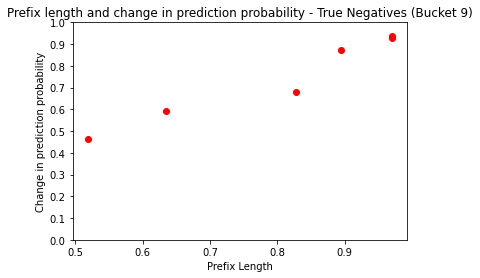

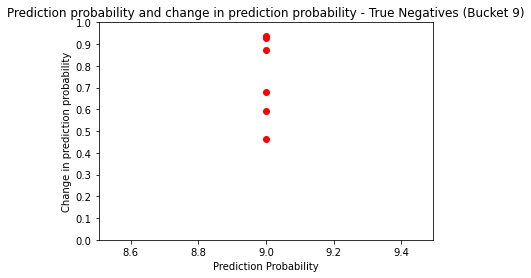

Category 2 of 4. Instance 1 of 8
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 62
Creating distribution for feature 2 of 62
Creating distribution for feature 3 of 62
Creating distribution for feature 4 of 62
Creating distribution for feature 5 of 62
Creating distribution for feature 6 of 62
Creating distribution for feature 7 of 62
Creating distribution for feature 8 of 62
Creating distribution for feature 9 of 62
Creating distribution for feature 10 of 62
Creating distribution for feature 11 of 62
Creating distribution for feature 12 of 62
Creating distribution for feature 13 of 62
Creating distribution for feature 14 of 62
Creating distribution for feature 15 of 62
Creating distribution for feature 16 of 62
Creating distribution for feature 17 of 62
Creating distribution for feature 18 of 62
Creating distribution for feature 19 of 62
Creating distribution for feature 20 of 62
Creating distribution for feature 21 of 62
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 62
Creating distribution for feature 2 of 62
Creating distribution for feature 3 of 62
Creating distribution for feature 4 of 62
Creating distribution for feature 5 of 62
Creating distribution for feature 6 of 62
Creating distribution for feature 7 of 62
Creating distribution for feature 8 of 62
Creating distribution for feature 9 of 62
Creating distribution for feature 10 of 62
Creating distribution for feature 11 of 62
Creating distribution for feature 12 of 62
Creating distribution for feature 13 of 62
Creating distribution for feature 14 of 62
Creating distribution for feature 15 of 62
Creating distribution for feature 16 of 62
Creating distribution for feature 17 of 62
Creating distribution for feature 18 of 62
Creating distribution for feature 19 of 62
Creating distribution for feature 20 of 62
Creating distribution for feature 21 of 62
Creating distribution for feature 22 of 62
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 62
Creating distribution for feature 2 of 62
Creating distribution for feature 3 of 62
Creating distribution for feature 4 of 62
Creating distribution for feature 5 of 62
Creating distribution for feature 6 of 62
Creating distribution for feature 7 of 62
Creating distribution for feature 8 of 62
Creating distribution for feature 9 of 62
Creating distribution for feature 10 of 62
Creating distribution for feature 11 of 62
Creating distribution for feature 12 of 62
Creating distribution for feature 13 of 62
Creating distribution for feature 14 of 62
Creating distribution for feature 15 of 62
Creating distribution for feature 16 of 62
Creating distribution for feature 17 of 62
Creating distribution for feature 18 of 62
Creating distribution for feature 19 of 62
Creating distribution for feature 20 of 62
Creating distribution for feature 21 of 62
Creating distribution for feature 22 of 62
Creating di

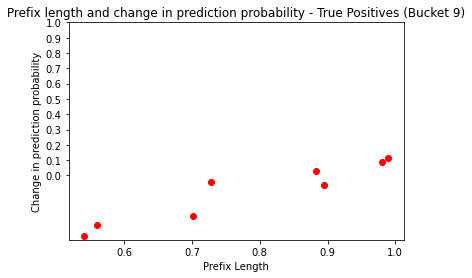

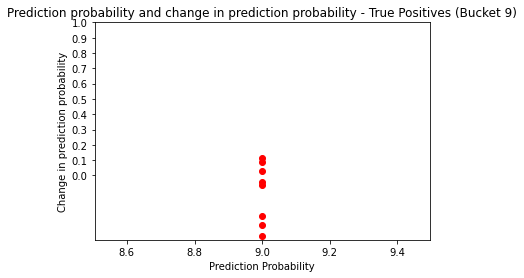

Category 3 of 4. Instance 1 of 5
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 62
Creating distribution for feature 2 of 62
Creating distribution for feature 3 of 62
Creating distribution for feature 4 of 62
Creating distribution for feature 5 of 62
Creating distribution for feature 6 of 62
Creating distribution for feature 7 of 62
Creating distribution for feature 8 of 62
Creating distribution for feature 9 of 62
Creating distribution for feature 10 of 62
Creating distribution for feature 11 of 62
Creating distribution for feature 12 of 62
Creating distribution for feature 13 of 62
Creating distribution for feature 14 of 62
Creating distribution for feature 15 of 62
Creating distribution for feature 16 of 62
Creating distribution for feature 17 of 62
Creating distribution for feature 18 of 62
Creating distribution for feature 19 of 62
Creating distribution for feature 20 of 62
Creating distribution for feature 21 of 62
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 62
Creating distribution for feature 2 of 62
Creating distribution for feature 3 of 62
Creating distribution for feature 4 of 62
Creating distribution for feature 5 of 62
Creating distribution for feature 6 of 62
Creating distribution for feature 7 of 62
Creating distribution for feature 8 of 62
Creating distribution for feature 9 of 62
Creating distribution for feature 10 of 62
Creating distribution for feature 11 of 62
Creating distribution for feature 12 of 62
Creating distribution for feature 13 of 62
Creating distribution for feature 14 of 62
Creating distribution for feature 15 of 62
Creating distribution for feature 16 of 62
Creating distribution for feature 17 of 62
Creating distribution for feature 18 of 62
Creating distribution for feature 19 of 62
Creating distribution for feature 20 of 62
Creating distribution for feature 21 of 62
Creating distribution for feature 22 of 62
Creating di

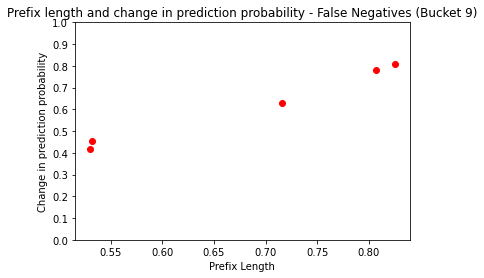

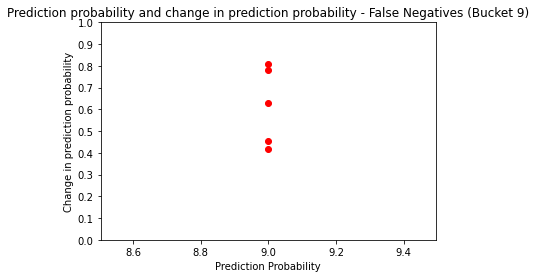

Category 4 of 4. Instance 1 of 5
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 62
Creating distribution for feature 2 of 62
Creating distribution for feature 3 of 62
Creating distribution for feature 4 of 62
Creating distribution for feature 5 of 62
Creating distribution for feature 6 of 62
Creating distribution for feature 7 of 62
Creating distribution for feature 8 of 62
Creating distribution for feature 9 of 62
Creating distribution for feature 10 of 62
Creating distribution for feature 11 of 62
Creating distribution for feature 12 of 62
Creating distribution for feature 13 of 62
Creating distribution for feature 14 of 62
Creating distribution for feature 15 of 62
Creating distribution for feature 16 of 62
Creating distribution for feature 17 of 62
Creating distribution for feature 18 of 62
Creating distribution for feature 19 of 62
Creating distribution for feature 20 of 62
Creating distribution for feature 21 of 62
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 62
Creating distribution for feature 2 of 62
Creating distribution for feature 3 of 62
Creating distribution for feature 4 of 62
Creating distribution for feature 5 of 62
Creating distribution for feature 6 of 62
Creating distribution for feature 7 of 62
Creating distribution for feature 8 of 62
Creating distribution for feature 9 of 62
Creating distribution for feature 10 of 62
Creating distribution for feature 11 of 62
Creating distribution for feature 12 of 62
Creating distribution for feature 13 of 62
Creating distribution for feature 14 of 62
Creating distribution for feature 15 of 62
Creating distribution for feature 16 of 62
Creating distribution for feature 17 of 62
Creating distribution for feature 18 of 62
Creating distribution for feature 19 of 62
Creating distribution for feature 20 of 62
Creating distribution for feature 21 of 62
Creating distribution for feature 22 of 62
Creating di

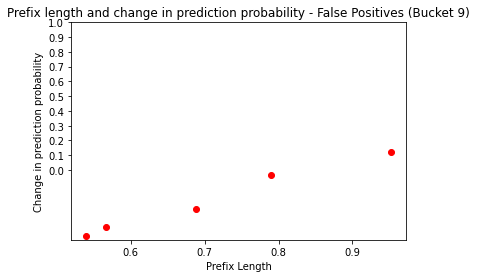

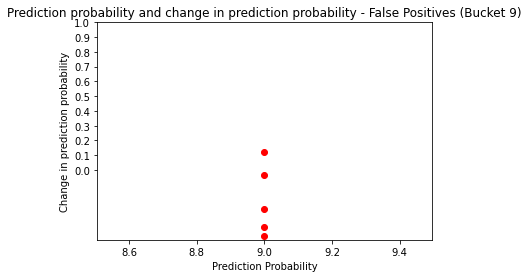

Bucket 10
Generating distributions for bucket
1 of 684 features
2 of 684 features
3 of 684 features
4 of 684 features
5 of 684 features
6 of 684 features
7 of 684 features
8 of 684 features
9 of 684 features
10 of 684 features
11 of 684 features
12 of 684 features
13 of 684 features
14 of 684 features
15 of 684 features
16 of 684 features
17 of 684 features
18 of 684 features
19 of 684 features
20 of 684 features
21 of 684 features
22 of 684 features
23 of 684 features
24 of 684 features
25 of 684 features
26 of 684 features
27 of 684 features
28 of 684 features
29 of 684 features
30 of 684 features
31 of 684 features
32 of 684 features
33 of 684 features
34 of 684 features
35 of 684 features
36 of 684 features
37 of 684 features
38 of 684 features
39 of 684 features
40 of 684 features
41 of 684 features
42 of 684 features
43 of 684 features
44 of 684 features
45 of 684 features
46 of 684 features
47 of 684 features
48 of 684 features
49 of 684 features
50 of 684 features
51 of 684 fea

431 of 684 features
432 of 684 features
433 of 684 features
434 of 684 features
435 of 684 features
436 of 684 features
437 of 684 features
438 of 684 features
439 of 684 features
440 of 684 features
441 of 684 features
442 of 684 features
443 of 684 features
444 of 684 features
445 of 684 features
446 of 684 features
447 of 684 features
448 of 684 features
449 of 684 features
450 of 684 features
451 of 684 features
452 of 684 features
453 of 684 features
454 of 684 features
455 of 684 features
456 of 684 features
457 of 684 features
458 of 684 features
459 of 684 features
460 of 684 features
461 of 684 features
462 of 684 features
463 of 684 features
464 of 684 features
465 of 684 features
466 of 684 features
467 of 684 features
468 of 684 features
469 of 684 features
470 of 684 features
471 of 684 features
472 of 684 features
473 of 684 features
474 of 684 features
475 of 684 features
476 of 684 features
477 of 684 features
478 of 684 features
479 of 684 features
480 of 684 features


Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 68
Creating distribution for feature 2 of 68
Creating distribution for feature 3 of 68
Creating distribution for feature 4 of 68
Creating distribution for feature 5 of 68
Creating distribution for feature 6 of 68
Creating distribution for feature 7 of 68
Creating distribution for feature 8 of 68
Creating distribution for feature 9 of 68
Creating distribution for feature 10 of 68
Creating distribution for feature 11 of 68
Creating distribution for feature 12 of 68
Creating distribution for feature 13 of 68
Creating distribution for feature 14 of 68
Creating distribution for feature 15 of 68
Creating distribution for feature 16 of 68
Creating distribution for feature 17 of 68
Creating distribution for feature 18 of 68
Creating distribution for feature 19 of 68
Creating distribution for feature 20 of 68
Creating distribution for feature 21 of 68
Creating distribution for feature 22 of 68
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 68
Creating distribution for feature 2 of 68
Creating distribution for feature 3 of 68
Creating distribution for feature 4 of 68
Creating distribution for feature 5 of 68
Creating distribution for feature 6 of 68
Creating distribution for feature 7 of 68
Creating distribution for feature 8 of 68
Creating distribution for feature 9 of 68
Creating distribution for feature 10 of 68
Creating distribution for feature 11 of 68
Creating distribution for feature 12 of 68
Creating distribution for feature 13 of 68
Creating distribution for feature 14 of 68
Creating distribution for feature 15 of 68
Creating distribution for feature 16 of 68
Creating distribution for feature 17 of 68
Creating distribution for feature 18 of 68
Creating distribution for feature 19 of 68
Creating distribution for feature 20 of 68
Creating distribution for feature 21 of 68
Creating distribution for feature 22 of 68
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 68
Creating distribution for feature 2 of 68
Creating distribution for feature 3 of 68
Creating distribution for feature 4 of 68
Creating distribution for feature 5 of 68
Creating distribution for feature 6 of 68
Creating distribution for feature 7 of 68
Creating distribution for feature 8 of 68
Creating distribution for feature 9 of 68
Creating distribution for feature 10 of 68
Creating distribution for feature 11 of 68
Creating distribution for feature 12 of 68
Creating distribution for feature 13 of 68
Creating distribution for feature 14 of 68
Creating distribution for feature 15 of 68
Creating distribution for feature 16 of 68
Creating distribution for feature 17 of 68
Creating distribution for feature 18 of 68
Creating distribution for feature 19 of 68
Creating distribution for feature 20 of 68
Creating distribution for feature 21 of 68
Creating distribution for feature 22 of 68
Creating di

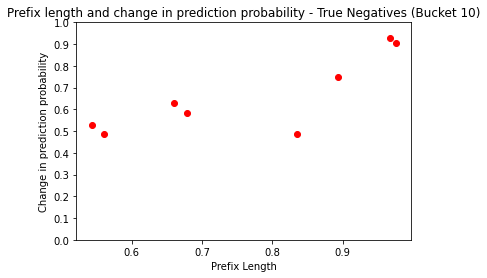

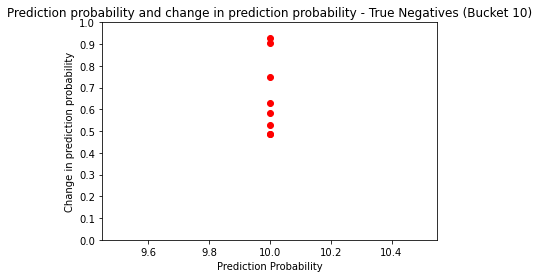

Category 2 of 4. Instance 1 of 6
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 68
Creating distribution for feature 2 of 68
Creating distribution for feature 3 of 68
Creating distribution for feature 4 of 68
Creating distribution for feature 5 of 68
Creating distribution for feature 6 of 68
Creating distribution for feature 7 of 68
Creating distribution for feature 8 of 68
Creating distribution for feature 9 of 68
Creating distribution for feature 10 of 68
Creating distribution for feature 11 of 68
Creating distribution for feature 12 of 68
Creating distribution for feature 13 of 68
Creating distribution for feature 14 of 68
Creating distribution for feature 15 of 68
Creating distribution for feature 16 of 68
Creating distribution for feature 17 of 68
Creating distribution for feature 18 of 68
Creating distribution for feature 19 of 68
Creating distribution for feature 20 of 68
Creating distribution for feature 21 of 68
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 68
Creating distribution for feature 2 of 68
Creating distribution for feature 3 of 68
Creating distribution for feature 4 of 68
Creating distribution for feature 5 of 68
Creating distribution for feature 6 of 68
Creating distribution for feature 7 of 68
Creating distribution for feature 8 of 68
Creating distribution for feature 9 of 68
Creating distribution for feature 10 of 68
Creating distribution for feature 11 of 68
Creating distribution for feature 12 of 68
Creating distribution for feature 13 of 68
Creating distribution for feature 14 of 68
Creating distribution for feature 15 of 68
Creating distribution for feature 16 of 68
Creating distribution for feature 17 of 68
Creating distribution for feature 18 of 68
Creating distribution for feature 19 of 68
Creating distribution for feature 20 of 68
Creating distribution for feature 21 of 68
Creating distribution for feature 22 of 68
Creating di

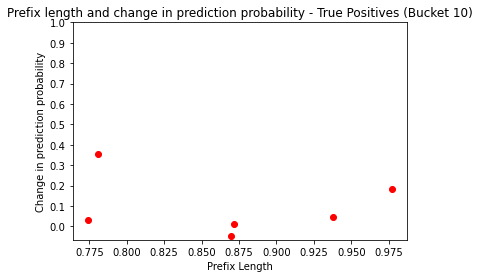

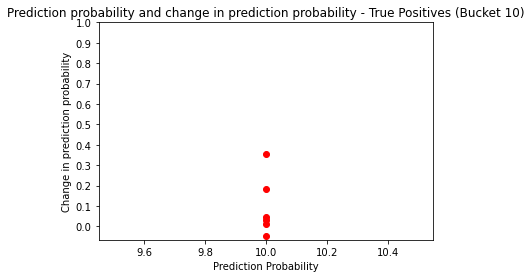

Category 3 of 4. Instance 1 of 5
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 68
Creating distribution for feature 2 of 68
Creating distribution for feature 3 of 68
Creating distribution for feature 4 of 68
Creating distribution for feature 5 of 68
Creating distribution for feature 6 of 68
Creating distribution for feature 7 of 68
Creating distribution for feature 8 of 68
Creating distribution for feature 9 of 68
Creating distribution for feature 10 of 68
Creating distribution for feature 11 of 68
Creating distribution for feature 12 of 68
Creating distribution for feature 13 of 68
Creating distribution for feature 14 of 68
Creating distribution for feature 15 of 68
Creating distribution for feature 16 of 68
Creating distribution for feature 17 of 68
Creating distribution for feature 18 of 68
Creating distribution for feature 19 of 68
Creating distribution for feature 20 of 68
Creating distribution for feature 21 of 68
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 68
Creating distribution for feature 2 of 68
Creating distribution for feature 3 of 68
Creating distribution for feature 4 of 68
Creating distribution for feature 5 of 68
Creating distribution for feature 6 of 68
Creating distribution for feature 7 of 68
Creating distribution for feature 8 of 68
Creating distribution for feature 9 of 68
Creating distribution for feature 10 of 68
Creating distribution for feature 11 of 68
Creating distribution for feature 12 of 68
Creating distribution for feature 13 of 68
Creating distribution for feature 14 of 68
Creating distribution for feature 15 of 68
Creating distribution for feature 16 of 68
Creating distribution for feature 17 of 68
Creating distribution for feature 18 of 68
Creating distribution for feature 19 of 68
Creating distribution for feature 20 of 68
Creating distribution for feature 21 of 68
Creating distribution for feature 22 of 68
Creating di

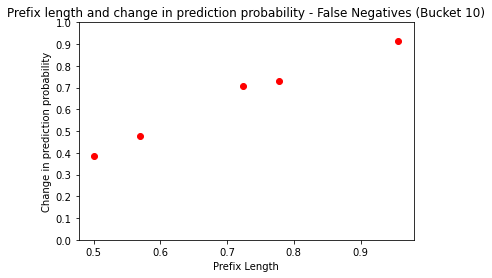

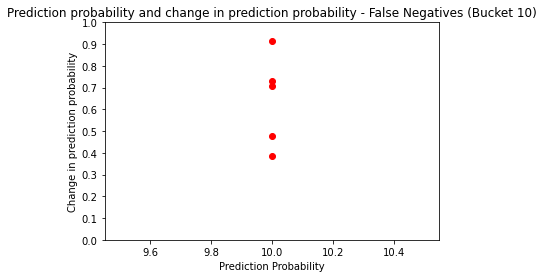

Category 4 of 4. Instance 1 of 5
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 68
Creating distribution for feature 2 of 68
Creating distribution for feature 3 of 68
Creating distribution for feature 4 of 68
Creating distribution for feature 5 of 68
Creating distribution for feature 6 of 68
Creating distribution for feature 7 of 68
Creating distribution for feature 8 of 68
Creating distribution for feature 9 of 68
Creating distribution for feature 10 of 68
Creating distribution for feature 11 of 68
Creating distribution for feature 12 of 68
Creating distribution for feature 13 of 68
Creating distribution for feature 14 of 68
Creating distribution for feature 15 of 68
Creating distribution for feature 16 of 68
Creating distribution for feature 17 of 68
Creating distribution for feature 18 of 68
Creating distribution for feature 19 of 68
Creating distribution for feature 20 of 68
Creating distribution for feature 21 of 68
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 68
Creating distribution for feature 2 of 68
Creating distribution for feature 3 of 68
Creating distribution for feature 4 of 68
Creating distribution for feature 5 of 68
Creating distribution for feature 6 of 68
Creating distribution for feature 7 of 68
Creating distribution for feature 8 of 68
Creating distribution for feature 9 of 68
Creating distribution for feature 10 of 68
Creating distribution for feature 11 of 68
Creating distribution for feature 12 of 68
Creating distribution for feature 13 of 68
Creating distribution for feature 14 of 68
Creating distribution for feature 15 of 68
Creating distribution for feature 16 of 68
Creating distribution for feature 17 of 68
Creating distribution for feature 18 of 68
Creating distribution for feature 19 of 68
Creating distribution for feature 20 of 68
Creating distribution for feature 21 of 68
Creating distribution for feature 22 of 68
Creating di

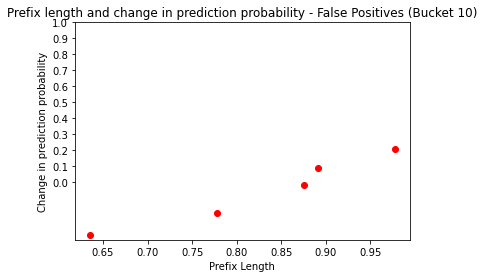

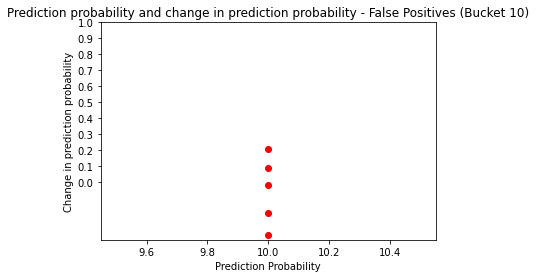

Bucket 11
Generating distributions for bucket
1 of 714 features
2 of 714 features
3 of 714 features
4 of 714 features
5 of 714 features
6 of 714 features
7 of 714 features
8 of 714 features
9 of 714 features
10 of 714 features
11 of 714 features
12 of 714 features
13 of 714 features
14 of 714 features
15 of 714 features
16 of 714 features
17 of 714 features
18 of 714 features
19 of 714 features
20 of 714 features
21 of 714 features
22 of 714 features
23 of 714 features
24 of 714 features
25 of 714 features
26 of 714 features
27 of 714 features
28 of 714 features
29 of 714 features
30 of 714 features
31 of 714 features
32 of 714 features
33 of 714 features
34 of 714 features
35 of 714 features
36 of 714 features
37 of 714 features
38 of 714 features
39 of 714 features
40 of 714 features
41 of 714 features
42 of 714 features
43 of 714 features
44 of 714 features
45 of 714 features
46 of 714 features
47 of 714 features
48 of 714 features
49 of 714 features
50 of 714 features
51 of 714 fea

462 of 714 features
463 of 714 features
464 of 714 features
465 of 714 features
466 of 714 features
467 of 714 features
468 of 714 features
469 of 714 features
470 of 714 features
471 of 714 features
472 of 714 features
473 of 714 features
474 of 714 features
475 of 714 features
476 of 714 features
477 of 714 features
478 of 714 features
479 of 714 features
480 of 714 features
481 of 714 features
482 of 714 features
483 of 714 features
484 of 714 features
485 of 714 features
486 of 714 features
487 of 714 features
488 of 714 features
489 of 714 features
490 of 714 features
491 of 714 features
492 of 714 features
493 of 714 features
494 of 714 features
495 of 714 features
496 of 714 features
497 of 714 features
498 of 714 features
499 of 714 features
500 of 714 features
501 of 714 features
502 of 714 features
503 of 714 features
504 of 714 features
505 of 714 features
506 of 714 features
507 of 714 features
508 of 714 features
509 of 714 features
510 of 714 features
511 of 714 features


Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 71
Creating distribution for feature 2 of 71
Creating distribution for feature 3 of 71
Creating distribution for feature 4 of 71
Creating distribution for feature 5 of 71
Creating distribution for feature 6 of 71
Creating distribution for feature 7 of 71
Creating distribution for feature 8 of 71
Creating distribution for feature 9 of 71
Creating distribution for feature 10 of 71
Creating distribution for feature 11 of 71
Creating distribution for feature 12 of 71
Creating distribution for feature 13 of 71
Creating distribution for feature 14 of 71
Creating distribution for feature 15 of 71
Creating distribution for feature 16 of 71
Creating distribution for feature 17 of 71
Creating distribution for feature 18 of 71
Creating distribution for feature 19 of 71
Creating distribution for feature 20 of 71
Creating distribution for feature 21 of 71
Creating distribution for feature 22 of 71
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 71
Creating distribution for feature 2 of 71
Creating distribution for feature 3 of 71
Creating distribution for feature 4 of 71
Creating distribution for feature 5 of 71
Creating distribution for feature 6 of 71
Creating distribution for feature 7 of 71
Creating distribution for feature 8 of 71
Creating distribution for feature 9 of 71
Creating distribution for feature 10 of 71
Creating distribution for feature 11 of 71
Creating distribution for feature 12 of 71
Creating distribution for feature 13 of 71
Creating distribution for feature 14 of 71
Creating distribution for feature 15 of 71
Creating distribution for feature 16 of 71
Creating distribution for feature 17 of 71
Creating distribution for feature 18 of 71
Creating distribution for feature 19 of 71
Creating distribution for feature 20 of 71
Creating distribution for feature 21 of 71
Creating distribution for feature 22 of 71
Creating di

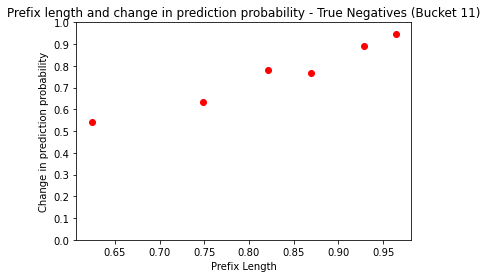

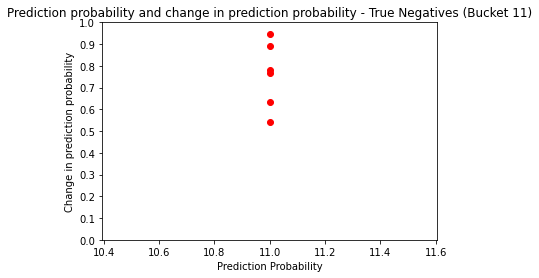

Category 2 of 4. Instance 1 of 7
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 71
Creating distribution for feature 2 of 71
Creating distribution for feature 3 of 71
Creating distribution for feature 4 of 71
Creating distribution for feature 5 of 71
Creating distribution for feature 6 of 71
Creating distribution for feature 7 of 71
Creating distribution for feature 8 of 71
Creating distribution for feature 9 of 71
Creating distribution for feature 10 of 71
Creating distribution for feature 11 of 71
Creating distribution for feature 12 of 71
Creating distribution for feature 13 of 71
Creating distribution for feature 14 of 71
Creating distribution for feature 15 of 71
Creating distribution for feature 16 of 71
Creating distribution for feature 17 of 71
Creating distribution for feature 18 of 71
Creating distribution for feature 19 of 71
Creating distribution for feature 20 of 71
Creating distribution for feature 21 of 71
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 71
Creating distribution for feature 2 of 71
Creating distribution for feature 3 of 71
Creating distribution for feature 4 of 71
Creating distribution for feature 5 of 71
Creating distribution for feature 6 of 71
Creating distribution for feature 7 of 71
Creating distribution for feature 8 of 71
Creating distribution for feature 9 of 71
Creating distribution for feature 10 of 71
Creating distribution for feature 11 of 71
Creating distribution for feature 12 of 71
Creating distribution for feature 13 of 71
Creating distribution for feature 14 of 71
Creating distribution for feature 15 of 71
Creating distribution for feature 16 of 71
Creating distribution for feature 17 of 71
Creating distribution for feature 18 of 71
Creating distribution for feature 19 of 71
Creating distribution for feature 20 of 71
Creating distribution for feature 21 of 71
Creating distribution for feature 22 of 71
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 71
Creating distribution for feature 2 of 71
Creating distribution for feature 3 of 71
Creating distribution for feature 4 of 71
Creating distribution for feature 5 of 71
Creating distribution for feature 6 of 71
Creating distribution for feature 7 of 71
Creating distribution for feature 8 of 71
Creating distribution for feature 9 of 71
Creating distribution for feature 10 of 71
Creating distribution for feature 11 of 71
Creating distribution for feature 12 of 71
Creating distribution for feature 13 of 71
Creating distribution for feature 14 of 71
Creating distribution for feature 15 of 71
Creating distribution for feature 16 of 71
Creating distribution for feature 17 of 71
Creating distribution for feature 18 of 71
Creating distribution for feature 19 of 71
Creating distribution for feature 20 of 71
Creating distribution for feature 21 of 71
Creating distribution for feature 22 of 71
Creating di

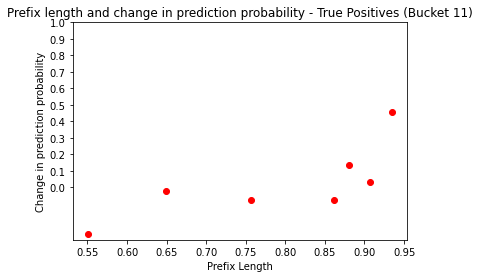

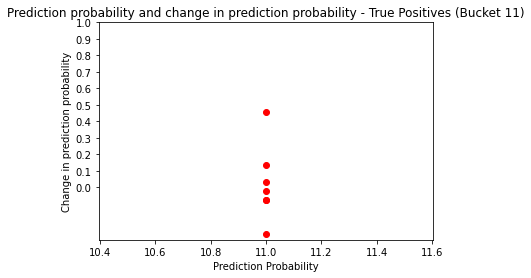

Category 3 of 4. Instance 1 of 5
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 71
Creating distribution for feature 2 of 71
Creating distribution for feature 3 of 71
Creating distribution for feature 4 of 71
Creating distribution for feature 5 of 71
Creating distribution for feature 6 of 71
Creating distribution for feature 7 of 71
Creating distribution for feature 8 of 71
Creating distribution for feature 9 of 71
Creating distribution for feature 10 of 71
Creating distribution for feature 11 of 71
Creating distribution for feature 12 of 71
Creating distribution for feature 13 of 71
Creating distribution for feature 14 of 71
Creating distribution for feature 15 of 71
Creating distribution for feature 16 of 71
Creating distribution for feature 17 of 71
Creating distribution for feature 18 of 71
Creating distribution for feature 19 of 71
Creating distribution for feature 20 of 71
Creating distribution for feature 21 of 71
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 71
Creating distribution for feature 2 of 71
Creating distribution for feature 3 of 71
Creating distribution for feature 4 of 71
Creating distribution for feature 5 of 71
Creating distribution for feature 6 of 71
Creating distribution for feature 7 of 71
Creating distribution for feature 8 of 71
Creating distribution for feature 9 of 71
Creating distribution for feature 10 of 71
Creating distribution for feature 11 of 71
Creating distribution for feature 12 of 71
Creating distribution for feature 13 of 71
Creating distribution for feature 14 of 71
Creating distribution for feature 15 of 71
Creating distribution for feature 16 of 71
Creating distribution for feature 17 of 71
Creating distribution for feature 18 of 71
Creating distribution for feature 19 of 71
Creating distribution for feature 20 of 71
Creating distribution for feature 21 of 71
Creating distribution for feature 22 of 71
Creating di

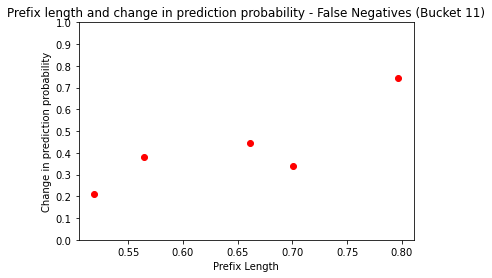

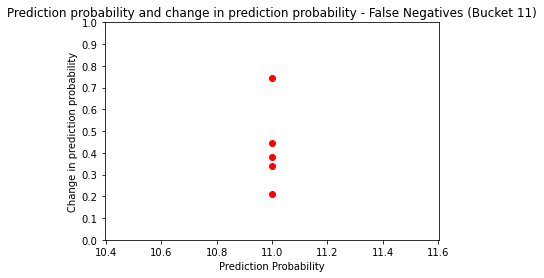

Category 4 of 4. Instance 1 of 4
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 71
Creating distribution for feature 2 of 71
Creating distribution for feature 3 of 71
Creating distribution for feature 4 of 71
Creating distribution for feature 5 of 71
Creating distribution for feature 6 of 71
Creating distribution for feature 7 of 71
Creating distribution for feature 8 of 71
Creating distribution for feature 9 of 71
Creating distribution for feature 10 of 71
Creating distribution for feature 11 of 71
Creating distribution for feature 12 of 71
Creating distribution for feature 13 of 71
Creating distribution for feature 14 of 71
Creating distribution for feature 15 of 71
Creating distribution for feature 16 of 71
Creating distribution for feature 17 of 71
Creating distribution for feature 18 of 71
Creating distribution for feature 19 of 71
Creating distribution for feature 20 of 71
Creating distribution for feature 21 of 71
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 71
Creating distribution for feature 2 of 71
Creating distribution for feature 3 of 71
Creating distribution for feature 4 of 71
Creating distribution for feature 5 of 71
Creating distribution for feature 6 of 71
Creating distribution for feature 7 of 71
Creating distribution for feature 8 of 71
Creating distribution for feature 9 of 71
Creating distribution for feature 10 of 71
Creating distribution for feature 11 of 71
Creating distribution for feature 12 of 71
Creating distribution for feature 13 of 71
Creating distribution for feature 14 of 71
Creating distribution for feature 15 of 71
Creating distribution for feature 16 of 71
Creating distribution for feature 17 of 71
Creating distribution for feature 18 of 71
Creating distribution for feature 19 of 71
Creating distribution for feature 20 of 71
Creating distribution for feature 21 of 71
Creating distribution for feature 22 of 71
Creating di

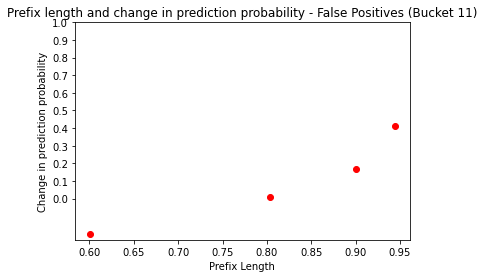

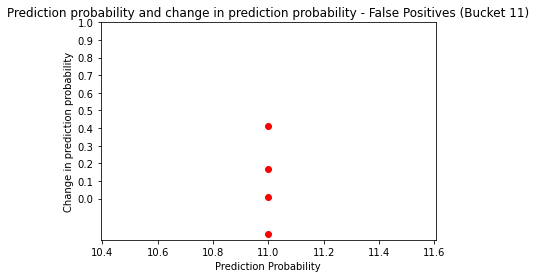

Bucket 12
Generating distributions for bucket
1 of 751 features
2 of 751 features
3 of 751 features
4 of 751 features
5 of 751 features
6 of 751 features
7 of 751 features
8 of 751 features
9 of 751 features
10 of 751 features
11 of 751 features
12 of 751 features
13 of 751 features
14 of 751 features
15 of 751 features
16 of 751 features
17 of 751 features
18 of 751 features
19 of 751 features
20 of 751 features
21 of 751 features
22 of 751 features
23 of 751 features
24 of 751 features
25 of 751 features
26 of 751 features
27 of 751 features
28 of 751 features
29 of 751 features
30 of 751 features
31 of 751 features
32 of 751 features
33 of 751 features
34 of 751 features
35 of 751 features
36 of 751 features
37 of 751 features
38 of 751 features
39 of 751 features
40 of 751 features
41 of 751 features
42 of 751 features
43 of 751 features
44 of 751 features
45 of 751 features
46 of 751 features
47 of 751 features
48 of 751 features
49 of 751 features
50 of 751 features
51 of 751 fea

540 of 751 features
541 of 751 features
542 of 751 features
543 of 751 features
544 of 751 features
545 of 751 features
546 of 751 features
547 of 751 features
548 of 751 features
549 of 751 features
550 of 751 features
551 of 751 features
552 of 751 features
553 of 751 features
554 of 751 features
555 of 751 features
556 of 751 features
557 of 751 features
558 of 751 features
559 of 751 features
560 of 751 features
561 of 751 features
562 of 751 features
563 of 751 features
564 of 751 features
565 of 751 features
566 of 751 features
567 of 751 features
568 of 751 features
569 of 751 features
570 of 751 features
571 of 751 features
572 of 751 features
573 of 751 features
574 of 751 features
575 of 751 features
576 of 751 features
577 of 751 features
578 of 751 features
579 of 751 features
580 of 751 features
581 of 751 features
582 of 751 features
583 of 751 features
584 of 751 features
585 of 751 features
586 of 751 features
587 of 751 features
588 of 751 features
589 of 751 features


Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 75
Creating distribution for feature 2 of 75
Creating distribution for feature 3 of 75
Creating distribution for feature 4 of 75
Creating distribution for feature 5 of 75
Creating distribution for feature 6 of 75
Creating distribution for feature 7 of 75
Creating distribution for feature 8 of 75
Creating distribution for feature 9 of 75
Creating distribution for feature 10 of 75
Creating distribution for feature 11 of 75
Creating distribution for feature 12 of 75
Creating distribution for feature 13 of 75
Creating distribution for feature 14 of 75
Creating distribution for feature 15 of 75
Creating distribution for feature 16 of 75
Creating distribution for feature 17 of 75
Creating distribution for feature 18 of 75
Creating distribution for feature 19 of 75
Creating distribution for feature 20 of 75
Creating distribution for feature 21 of 75
Creating distribution for feature 22 of 75
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 75
Creating distribution for feature 2 of 75
Creating distribution for feature 3 of 75
Creating distribution for feature 4 of 75
Creating distribution for feature 5 of 75
Creating distribution for feature 6 of 75
Creating distribution for feature 7 of 75
Creating distribution for feature 8 of 75
Creating distribution for feature 9 of 75
Creating distribution for feature 10 of 75
Creating distribution for feature 11 of 75
Creating distribution for feature 12 of 75
Creating distribution for feature 13 of 75
Creating distribution for feature 14 of 75
Creating distribution for feature 15 of 75
Creating distribution for feature 16 of 75
Creating distribution for feature 17 of 75
Creating distribution for feature 18 of 75
Creating distribution for feature 19 of 75
Creating distribution for feature 20 of 75
Creating distribution for feature 21 of 75
Creating distribution for feature 22 of 75
Creating di

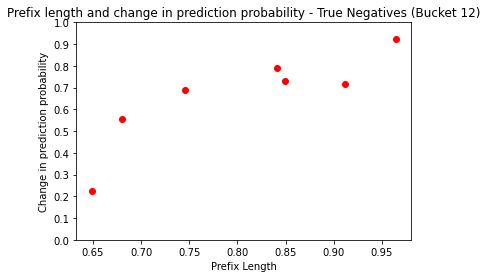

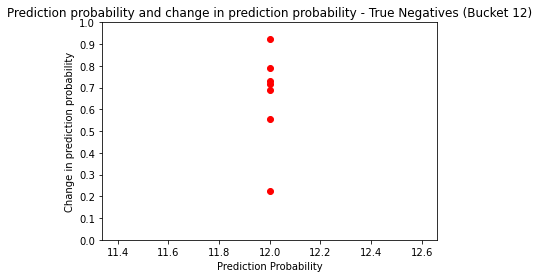

Category 2 of 4. Instance 1 of 6
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 75
Creating distribution for feature 2 of 75
Creating distribution for feature 3 of 75
Creating distribution for feature 4 of 75
Creating distribution for feature 5 of 75
Creating distribution for feature 6 of 75
Creating distribution for feature 7 of 75
Creating distribution for feature 8 of 75
Creating distribution for feature 9 of 75
Creating distribution for feature 10 of 75
Creating distribution for feature 11 of 75
Creating distribution for feature 12 of 75
Creating distribution for feature 13 of 75
Creating distribution for feature 14 of 75
Creating distribution for feature 15 of 75
Creating distribution for feature 16 of 75
Creating distribution for feature 17 of 75
Creating distribution for feature 18 of 75
Creating distribution for feature 19 of 75
Creating distribution for feature 20 of 75
Creating distribution for feature 21 of 75
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 75
Creating distribution for feature 2 of 75
Creating distribution for feature 3 of 75
Creating distribution for feature 4 of 75
Creating distribution for feature 5 of 75
Creating distribution for feature 6 of 75
Creating distribution for feature 7 of 75
Creating distribution for feature 8 of 75
Creating distribution for feature 9 of 75
Creating distribution for feature 10 of 75
Creating distribution for feature 11 of 75
Creating distribution for feature 12 of 75
Creating distribution for feature 13 of 75
Creating distribution for feature 14 of 75
Creating distribution for feature 15 of 75
Creating distribution for feature 16 of 75
Creating distribution for feature 17 of 75
Creating distribution for feature 18 of 75
Creating distribution for feature 19 of 75
Creating distribution for feature 20 of 75
Creating distribution for feature 21 of 75
Creating distribution for feature 22 of 75
Creating di

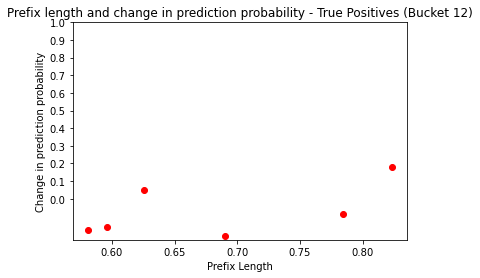

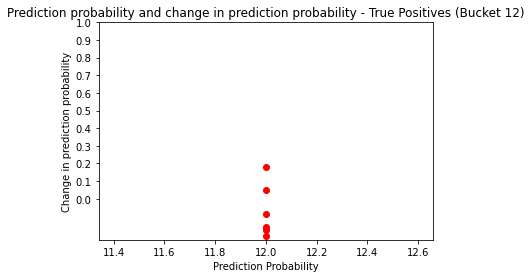

Category 3 of 4. Instance 1 of 6
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 75
Creating distribution for feature 2 of 75
Creating distribution for feature 3 of 75
Creating distribution for feature 4 of 75
Creating distribution for feature 5 of 75
Creating distribution for feature 6 of 75
Creating distribution for feature 7 of 75
Creating distribution for feature 8 of 75
Creating distribution for feature 9 of 75
Creating distribution for feature 10 of 75
Creating distribution for feature 11 of 75
Creating distribution for feature 12 of 75
Creating distribution for feature 13 of 75
Creating distribution for feature 14 of 75
Creating distribution for feature 15 of 75
Creating distribution for feature 16 of 75
Creating distribution for feature 17 of 75
Creating distribution for feature 18 of 75
Creating distribution for feature 19 of 75
Creating distribution for feature 20 of 75
Creating distribution for feature 21 of 75
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 75
Creating distribution for feature 2 of 75
Creating distribution for feature 3 of 75
Creating distribution for feature 4 of 75
Creating distribution for feature 5 of 75
Creating distribution for feature 6 of 75
Creating distribution for feature 7 of 75
Creating distribution for feature 8 of 75
Creating distribution for feature 9 of 75
Creating distribution for feature 10 of 75
Creating distribution for feature 11 of 75
Creating distribution for feature 12 of 75
Creating distribution for feature 13 of 75
Creating distribution for feature 14 of 75
Creating distribution for feature 15 of 75
Creating distribution for feature 16 of 75
Creating distribution for feature 17 of 75
Creating distribution for feature 18 of 75
Creating distribution for feature 19 of 75
Creating distribution for feature 20 of 75
Creating distribution for feature 21 of 75
Creating distribution for feature 22 of 75
Creating di

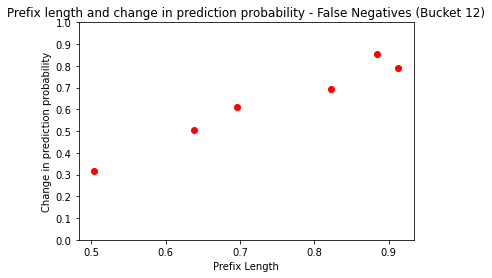

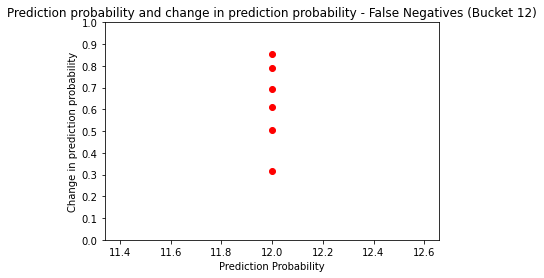

Category 4 of 4. Instance 1 of 1
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 75
Creating distribution for feature 2 of 75
Creating distribution for feature 3 of 75
Creating distribution for feature 4 of 75
Creating distribution for feature 5 of 75
Creating distribution for feature 6 of 75
Creating distribution for feature 7 of 75
Creating distribution for feature 8 of 75
Creating distribution for feature 9 of 75
Creating distribution for feature 10 of 75
Creating distribution for feature 11 of 75
Creating distribution for feature 12 of 75
Creating distribution for feature 13 of 75
Creating distribution for feature 14 of 75
Creating distribution for feature 15 of 75
Creating distribution for feature 16 of 75
Creating distribution for feature 17 of 75
Creating distribution for feature 18 of 75
Creating distribution for feature 19 of 75
Creating distribution for feature 20 of 75
Creating distribution for feature 21 of 75
Creating distribution

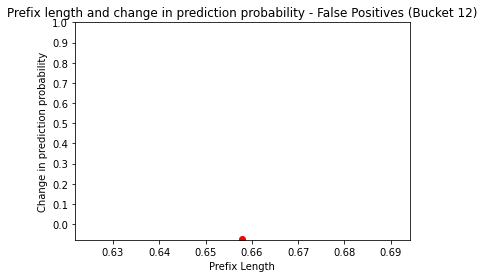

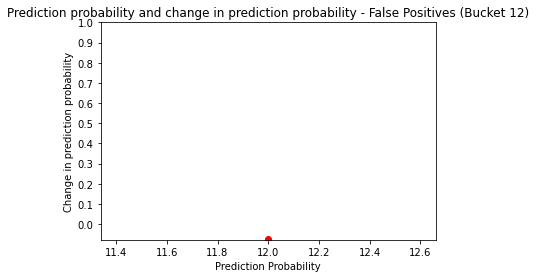

Bucket 13
Generating distributions for bucket
1 of 810 features
2 of 810 features
3 of 810 features
4 of 810 features
5 of 810 features
6 of 810 features
7 of 810 features
8 of 810 features
9 of 810 features
10 of 810 features
11 of 810 features
12 of 810 features
13 of 810 features
14 of 810 features
15 of 810 features
16 of 810 features
17 of 810 features
18 of 810 features
19 of 810 features
20 of 810 features
21 of 810 features
22 of 810 features
23 of 810 features
24 of 810 features
25 of 810 features
26 of 810 features
27 of 810 features
28 of 810 features
29 of 810 features
30 of 810 features
31 of 810 features
32 of 810 features
33 of 810 features
34 of 810 features
35 of 810 features
36 of 810 features
37 of 810 features
38 of 810 features
39 of 810 features
40 of 810 features
41 of 810 features
42 of 810 features
43 of 810 features
44 of 810 features
45 of 810 features
46 of 810 features
47 of 810 features
48 of 810 features
49 of 810 features
50 of 810 features
51 of 810 fea

560 of 810 features
561 of 810 features
562 of 810 features
563 of 810 features
564 of 810 features
565 of 810 features
566 of 810 features
567 of 810 features
568 of 810 features
569 of 810 features
570 of 810 features
571 of 810 features
572 of 810 features
573 of 810 features
574 of 810 features
575 of 810 features
576 of 810 features
577 of 810 features
578 of 810 features
579 of 810 features
580 of 810 features
581 of 810 features
582 of 810 features
583 of 810 features
584 of 810 features
585 of 810 features
586 of 810 features
587 of 810 features
588 of 810 features
589 of 810 features
590 of 810 features
591 of 810 features
592 of 810 features
593 of 810 features
594 of 810 features
595 of 810 features
596 of 810 features
597 of 810 features
598 of 810 features
599 of 810 features
600 of 810 features
601 of 810 features
602 of 810 features
603 of 810 features
604 of 810 features
605 of 810 features
606 of 810 features
607 of 810 features
608 of 810 features
609 of 810 features


Creating distribution for feature 79 of 81
Creating distribution for feature 80 of 81
Creating distribution for feature 81 of 81
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 4
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 81
Creating distribution for feature 2 of 81
Creating distribution for feature 3 of 81
Creating distribution for feature 4 of 81
Creating distribution for feature 5 of 81
Creating distribution for feature 6 of 81
Creating distribution for feature 7 of 81
Creating distribution for feature 8 of 81
Creating distribution for feature 9 of 81
Creating distribution for feature 10 of 81
Creating distribution for feature 11 of 81
Creating distribution for feature 12 of 81
Creating distribution for feature 13 of 81
Creating distribution for feature 14 of 81
Creating dis

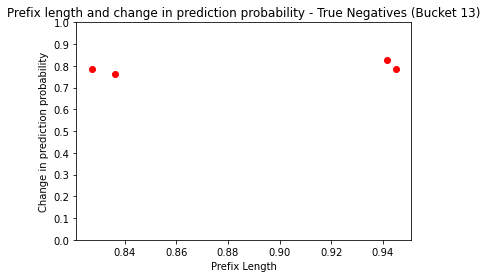

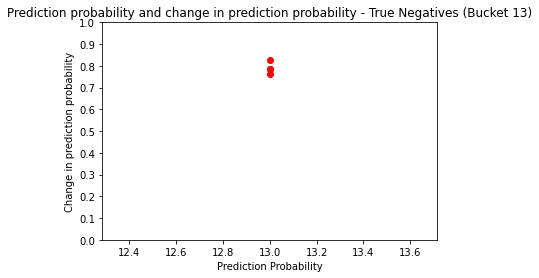

Category 2 of 4. Instance 1 of 2
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 81
Creating distribution for feature 2 of 81
Creating distribution for feature 3 of 81
Creating distribution for feature 4 of 81
Creating distribution for feature 5 of 81
Creating distribution for feature 6 of 81
Creating distribution for feature 7 of 81
Creating distribution for feature 8 of 81
Creating distribution for feature 9 of 81
Creating distribution for feature 10 of 81
Creating distribution for feature 11 of 81
Creating distribution for feature 12 of 81
Creating distribution for feature 13 of 81
Creating distribution for feature 14 of 81
Creating distribution for feature 15 of 81
Creating distribution for feature 16 of 81
Creating distribution for feature 17 of 81
Creating distribution for feature 18 of 81
Creating distribution for feature 19 of 81
Creating distribution for feature 20 of 81
Creating distribution for feature 21 of 81
Creating distribution

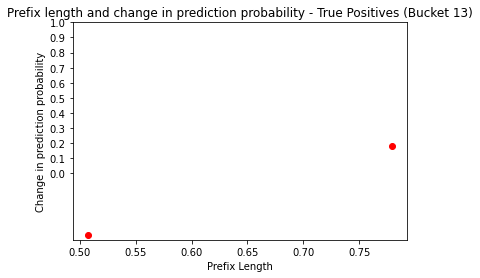

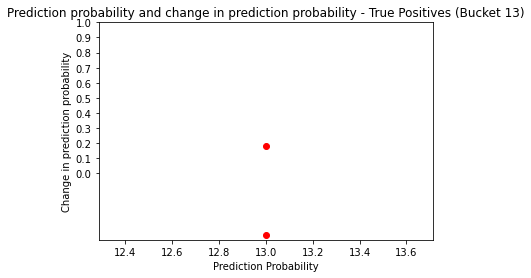

Category 3 of 4. Instance 1 of 5
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 81
Creating distribution for feature 2 of 81
Creating distribution for feature 3 of 81
Creating distribution for feature 4 of 81
Creating distribution for feature 5 of 81
Creating distribution for feature 6 of 81
Creating distribution for feature 7 of 81
Creating distribution for feature 8 of 81
Creating distribution for feature 9 of 81
Creating distribution for feature 10 of 81
Creating distribution for feature 11 of 81
Creating distribution for feature 12 of 81
Creating distribution for feature 13 of 81
Creating distribution for feature 14 of 81
Creating distribution for feature 15 of 81
Creating distribution for feature 16 of 81
Creating distribution for feature 17 of 81
Creating distribution for feature 18 of 81
Creating distribution for feature 19 of 81
Creating distribution for feature 20 of 81
Creating distribution for feature 21 of 81
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 81
Creating distribution for feature 2 of 81
Creating distribution for feature 3 of 81
Creating distribution for feature 4 of 81
Creating distribution for feature 5 of 81
Creating distribution for feature 6 of 81
Creating distribution for feature 7 of 81
Creating distribution for feature 8 of 81
Creating distribution for feature 9 of 81
Creating distribution for feature 10 of 81
Creating distribution for feature 11 of 81
Creating distribution for feature 12 of 81
Creating distribution for feature 13 of 81
Creating distribution for feature 14 of 81
Creating distribution for feature 15 of 81
Creating distribution for feature 16 of 81
Creating distribution for feature 17 of 81
Creating distribution for feature 18 of 81
Creating distribution for feature 19 of 81
Creating distribution for feature 20 of 81
Creating distribution for feature 21 of 81
Creating distribution for feature 22 of 81
Creating di

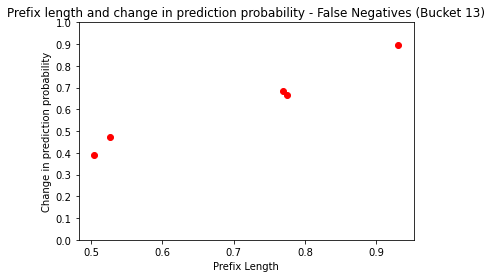

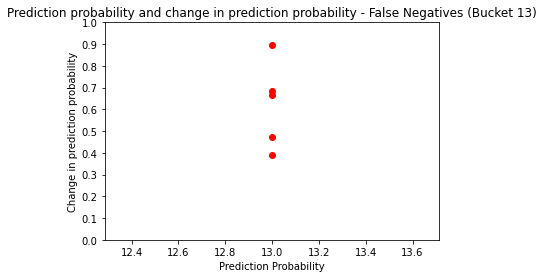

Category 4 of 4. Instance 1 of 3
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 81
Creating distribution for feature 2 of 81
Creating distribution for feature 3 of 81
Creating distribution for feature 4 of 81
Creating distribution for feature 5 of 81
Creating distribution for feature 6 of 81
Creating distribution for feature 7 of 81
Creating distribution for feature 8 of 81
Creating distribution for feature 9 of 81
Creating distribution for feature 10 of 81
Creating distribution for feature 11 of 81
Creating distribution for feature 12 of 81
Creating distribution for feature 13 of 81
Creating distribution for feature 14 of 81
Creating distribution for feature 15 of 81
Creating distribution for feature 16 of 81
Creating distribution for feature 17 of 81
Creating distribution for feature 18 of 81
Creating distribution for feature 19 of 81
Creating distribution for feature 20 of 81
Creating distribution for feature 21 of 81
Creating distribution

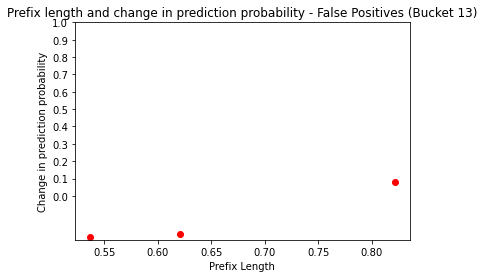

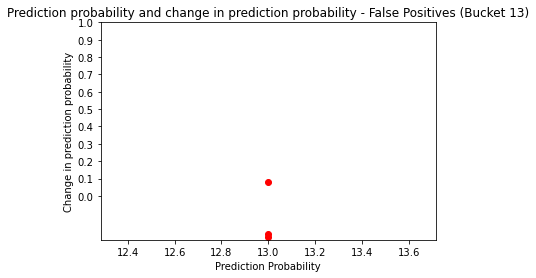

Bucket 14
Generating distributions for bucket
1 of 808 features
2 of 808 features
3 of 808 features
4 of 808 features
5 of 808 features
6 of 808 features
7 of 808 features
8 of 808 features
9 of 808 features
10 of 808 features
11 of 808 features
12 of 808 features
13 of 808 features
14 of 808 features
15 of 808 features
16 of 808 features
17 of 808 features
18 of 808 features
19 of 808 features
20 of 808 features
21 of 808 features
22 of 808 features
23 of 808 features
24 of 808 features
25 of 808 features
26 of 808 features
27 of 808 features
28 of 808 features
29 of 808 features
30 of 808 features
31 of 808 features
32 of 808 features
33 of 808 features
34 of 808 features
35 of 808 features
36 of 808 features
37 of 808 features
38 of 808 features
39 of 808 features
40 of 808 features
41 of 808 features
42 of 808 features
43 of 808 features
44 of 808 features
45 of 808 features
46 of 808 features
47 of 808 features
48 of 808 features
49 of 808 features
50 of 808 features
51 of 808 fea

456 of 808 features
457 of 808 features
458 of 808 features
459 of 808 features
460 of 808 features
461 of 808 features
462 of 808 features
463 of 808 features
464 of 808 features
465 of 808 features
466 of 808 features
467 of 808 features
468 of 808 features
469 of 808 features
470 of 808 features
471 of 808 features
472 of 808 features
473 of 808 features
474 of 808 features
475 of 808 features
476 of 808 features
477 of 808 features
478 of 808 features
479 of 808 features
480 of 808 features
481 of 808 features
482 of 808 features
483 of 808 features
484 of 808 features
485 of 808 features
486 of 808 features
487 of 808 features
488 of 808 features
489 of 808 features
490 of 808 features
491 of 808 features
492 of 808 features
493 of 808 features
494 of 808 features
495 of 808 features
496 of 808 features
497 of 808 features
498 of 808 features
499 of 808 features
500 of 808 features
501 of 808 features
502 of 808 features
503 of 808 features
504 of 808 features
505 of 808 features


Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 81
Creating distribution for feature 2 of 81
Creating distribution for feature 3 of 81
Creating distribution for feature 4 of 81
Creating distribution for feature 5 of 81
Creating distribution for feature 6 of 81
Creating distribution for feature 7 of 81
Creating distribution for feature 8 of 81
Creating distribution for feature 9 of 81
Creating distribution for feature 10 of 81
Creating distribution for feature 11 of 81
Creating distribution for feature 12 of 81
Creating distribution for feature 13 of 81
Creating distribution for feature 14 of 81
Creating distribution for feature 15 of 81
Creating distribution for feature 16 of 81
Creating distribution for feature 17 of 81
Creating distribution for feature 18 of 81
Creating distribution for feature 19 of 81
Creating distribution for feature 20 of 81
Creating distribution for feature 21 of 81
Creating distribution for feature 22 of 81
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 81
Creating distribution for feature 2 of 81
Creating distribution for feature 3 of 81
Creating distribution for feature 4 of 81
Creating distribution for feature 5 of 81
Creating distribution for feature 6 of 81
Creating distribution for feature 7 of 81
Creating distribution for feature 8 of 81
Creating distribution for feature 9 of 81
Creating distribution for feature 10 of 81
Creating distribution for feature 11 of 81
Creating distribution for feature 12 of 81
Creating distribution for feature 13 of 81
Creating distribution for feature 14 of 81
Creating distribution for feature 15 of 81
Creating distribution for feature 16 of 81
Creating distribution for feature 17 of 81
Creating distribution for feature 18 of 81
Creating distribution for feature 19 of 81
Creating distribution for feature 20 of 81
Creating distribution for feature 21 of 81
Creating distribution for feature 22 of 81
Creating di

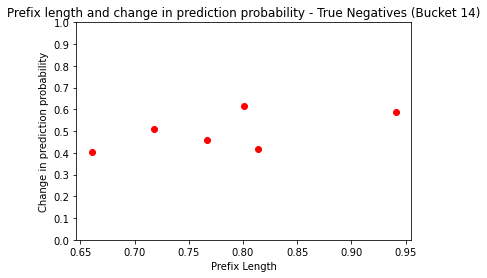

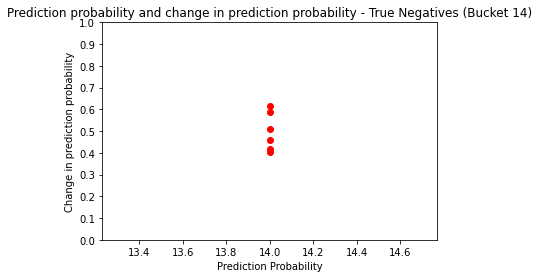

Category 2 of 4. Instance 1 of 6
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 81
Creating distribution for feature 2 of 81
Creating distribution for feature 3 of 81
Creating distribution for feature 4 of 81
Creating distribution for feature 5 of 81
Creating distribution for feature 6 of 81
Creating distribution for feature 7 of 81
Creating distribution for feature 8 of 81
Creating distribution for feature 9 of 81
Creating distribution for feature 10 of 81
Creating distribution for feature 11 of 81
Creating distribution for feature 12 of 81
Creating distribution for feature 13 of 81
Creating distribution for feature 14 of 81
Creating distribution for feature 15 of 81
Creating distribution for feature 16 of 81
Creating distribution for feature 17 of 81
Creating distribution for feature 18 of 81
Creating distribution for feature 19 of 81
Creating distribution for feature 20 of 81
Creating distribution for feature 21 of 81
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 81
Creating distribution for feature 2 of 81
Creating distribution for feature 3 of 81
Creating distribution for feature 4 of 81
Creating distribution for feature 5 of 81
Creating distribution for feature 6 of 81
Creating distribution for feature 7 of 81
Creating distribution for feature 8 of 81
Creating distribution for feature 9 of 81
Creating distribution for feature 10 of 81
Creating distribution for feature 11 of 81
Creating distribution for feature 12 of 81
Creating distribution for feature 13 of 81
Creating distribution for feature 14 of 81
Creating distribution for feature 15 of 81
Creating distribution for feature 16 of 81
Creating distribution for feature 17 of 81
Creating distribution for feature 18 of 81
Creating distribution for feature 19 of 81
Creating distribution for feature 20 of 81
Creating distribution for feature 21 of 81
Creating distribution for feature 22 of 81
Creating di

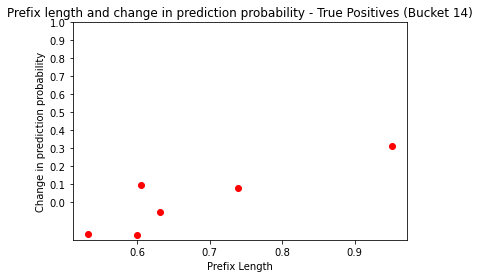

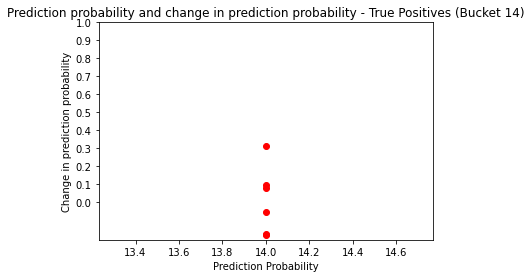

Category 3 of 4. Instance 1 of 3
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 81
Creating distribution for feature 2 of 81
Creating distribution for feature 3 of 81
Creating distribution for feature 4 of 81
Creating distribution for feature 5 of 81
Creating distribution for feature 6 of 81
Creating distribution for feature 7 of 81
Creating distribution for feature 8 of 81
Creating distribution for feature 9 of 81
Creating distribution for feature 10 of 81
Creating distribution for feature 11 of 81
Creating distribution for feature 12 of 81
Creating distribution for feature 13 of 81
Creating distribution for feature 14 of 81
Creating distribution for feature 15 of 81
Creating distribution for feature 16 of 81
Creating distribution for feature 17 of 81
Creating distribution for feature 18 of 81
Creating distribution for feature 19 of 81
Creating distribution for feature 20 of 81
Creating distribution for feature 21 of 81
Creating distribution

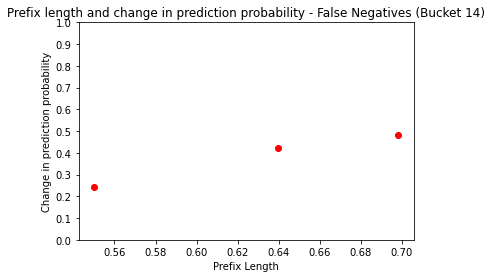

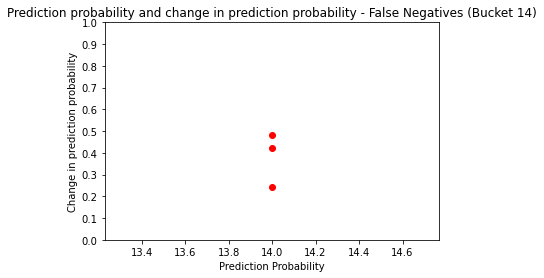

Category 4 of 4. Instance 1 of 2
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 81
Creating distribution for feature 2 of 81
Creating distribution for feature 3 of 81
Creating distribution for feature 4 of 81
Creating distribution for feature 5 of 81
Creating distribution for feature 6 of 81
Creating distribution for feature 7 of 81
Creating distribution for feature 8 of 81
Creating distribution for feature 9 of 81
Creating distribution for feature 10 of 81
Creating distribution for feature 11 of 81
Creating distribution for feature 12 of 81
Creating distribution for feature 13 of 81
Creating distribution for feature 14 of 81
Creating distribution for feature 15 of 81
Creating distribution for feature 16 of 81
Creating distribution for feature 17 of 81
Creating distribution for feature 18 of 81
Creating distribution for feature 19 of 81
Creating distribution for feature 20 of 81
Creating distribution for feature 21 of 81
Creating distribution

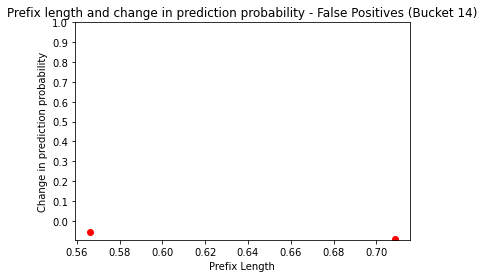

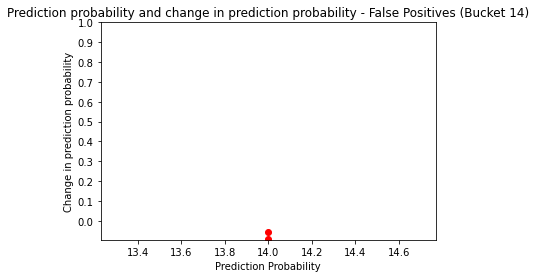

Bucket 15
Generating distributions for bucket
1 of 779 features
2 of 779 features
3 of 779 features
4 of 779 features
5 of 779 features
6 of 779 features
7 of 779 features
8 of 779 features
9 of 779 features
10 of 779 features
11 of 779 features
12 of 779 features
13 of 779 features
14 of 779 features
15 of 779 features
16 of 779 features
17 of 779 features
18 of 779 features
19 of 779 features
20 of 779 features
21 of 779 features
22 of 779 features
23 of 779 features
24 of 779 features
25 of 779 features
26 of 779 features
27 of 779 features
28 of 779 features
29 of 779 features
30 of 779 features
31 of 779 features
32 of 779 features
33 of 779 features
34 of 779 features
35 of 779 features
36 of 779 features
37 of 779 features
38 of 779 features
39 of 779 features
40 of 779 features
41 of 779 features
42 of 779 features
43 of 779 features
44 of 779 features
45 of 779 features
46 of 779 features
47 of 779 features
48 of 779 features
49 of 779 features
50 of 779 features
51 of 779 fea

465 of 779 features
466 of 779 features
467 of 779 features
468 of 779 features
469 of 779 features
470 of 779 features
471 of 779 features
472 of 779 features
473 of 779 features
474 of 779 features
475 of 779 features
476 of 779 features
477 of 779 features
478 of 779 features
479 of 779 features
480 of 779 features
481 of 779 features
482 of 779 features
483 of 779 features
484 of 779 features
485 of 779 features
486 of 779 features
487 of 779 features
488 of 779 features
489 of 779 features
490 of 779 features
491 of 779 features
492 of 779 features
493 of 779 features
494 of 779 features
495 of 779 features
496 of 779 features
497 of 779 features
498 of 779 features
499 of 779 features
500 of 779 features
501 of 779 features
502 of 779 features
503 of 779 features
504 of 779 features
505 of 779 features
506 of 779 features
507 of 779 features
508 of 779 features
509 of 779 features
510 of 779 features
511 of 779 features
512 of 779 features
513 of 779 features
514 of 779 features


Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 78
Creating distribution for feature 2 of 78
Creating distribution for feature 3 of 78
Creating distribution for feature 4 of 78
Creating distribution for feature 5 of 78
Creating distribution for feature 6 of 78
Creating distribution for feature 7 of 78
Creating distribution for feature 8 of 78
Creating distribution for feature 9 of 78
Creating distribution for feature 10 of 78
Creating distribution for feature 11 of 78
Creating distribution for feature 12 of 78
Creating distribution for feature 13 of 78
Creating distribution for feature 14 of 78
Creating distribution for feature 15 of 78
Creating distribution for feature 16 of 78
Creating distribution for feature 17 of 78
Creating distribution for feature 18 of 78
Creating distribution for feature 19 of 78
Creating distribution for feature 20 of 78
Creating distribution for feature 21 of 78
Creating distribution for feature 22 of 78
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 78
Creating distribution for feature 2 of 78
Creating distribution for feature 3 of 78
Creating distribution for feature 4 of 78
Creating distribution for feature 5 of 78
Creating distribution for feature 6 of 78
Creating distribution for feature 7 of 78
Creating distribution for feature 8 of 78
Creating distribution for feature 9 of 78
Creating distribution for feature 10 of 78
Creating distribution for feature 11 of 78
Creating distribution for feature 12 of 78
Creating distribution for feature 13 of 78
Creating distribution for feature 14 of 78
Creating distribution for feature 15 of 78
Creating distribution for feature 16 of 78
Creating distribution for feature 17 of 78
Creating distribution for feature 18 of 78
Creating distribution for feature 19 of 78
Creating distribution for feature 20 of 78
Creating distribution for feature 21 of 78
Creating distribution for feature 22 of 78
Creating di

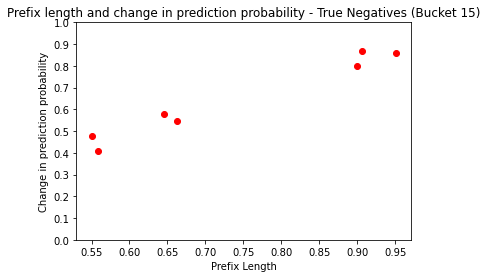

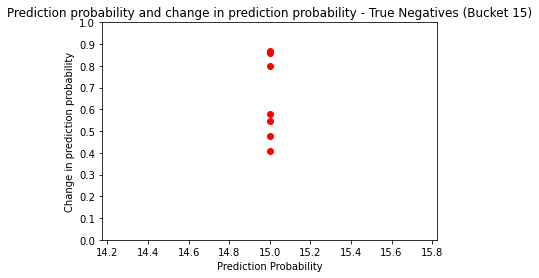

Category 2 of 4. Instance 1 of 7
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 78
Creating distribution for feature 2 of 78
Creating distribution for feature 3 of 78
Creating distribution for feature 4 of 78
Creating distribution for feature 5 of 78
Creating distribution for feature 6 of 78
Creating distribution for feature 7 of 78
Creating distribution for feature 8 of 78
Creating distribution for feature 9 of 78
Creating distribution for feature 10 of 78
Creating distribution for feature 11 of 78
Creating distribution for feature 12 of 78
Creating distribution for feature 13 of 78
Creating distribution for feature 14 of 78
Creating distribution for feature 15 of 78
Creating distribution for feature 16 of 78
Creating distribution for feature 17 of 78
Creating distribution for feature 18 of 78
Creating distribution for feature 19 of 78
Creating distribution for feature 20 of 78
Creating distribution for feature 21 of 78
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 78
Creating distribution for feature 2 of 78
Creating distribution for feature 3 of 78
Creating distribution for feature 4 of 78
Creating distribution for feature 5 of 78
Creating distribution for feature 6 of 78
Creating distribution for feature 7 of 78
Creating distribution for feature 8 of 78
Creating distribution for feature 9 of 78
Creating distribution for feature 10 of 78
Creating distribution for feature 11 of 78
Creating distribution for feature 12 of 78
Creating distribution for feature 13 of 78
Creating distribution for feature 14 of 78
Creating distribution for feature 15 of 78
Creating distribution for feature 16 of 78
Creating distribution for feature 17 of 78
Creating distribution for feature 18 of 78
Creating distribution for feature 19 of 78
Creating distribution for feature 20 of 78
Creating distribution for feature 21 of 78
Creating distribution for feature 22 of 78
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 78
Creating distribution for feature 2 of 78
Creating distribution for feature 3 of 78
Creating distribution for feature 4 of 78
Creating distribution for feature 5 of 78
Creating distribution for feature 6 of 78
Creating distribution for feature 7 of 78
Creating distribution for feature 8 of 78
Creating distribution for feature 9 of 78
Creating distribution for feature 10 of 78
Creating distribution for feature 11 of 78
Creating distribution for feature 12 of 78
Creating distribution for feature 13 of 78
Creating distribution for feature 14 of 78
Creating distribution for feature 15 of 78
Creating distribution for feature 16 of 78
Creating distribution for feature 17 of 78
Creating distribution for feature 18 of 78
Creating distribution for feature 19 of 78
Creating distribution for feature 20 of 78
Creating distribution for feature 21 of 78
Creating distribution for feature 22 of 78
Creating di

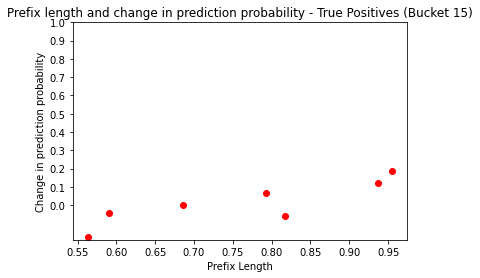

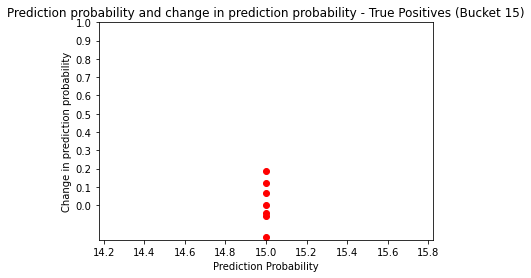

Category 3 of 4. Instance 1 of 1
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 78
Creating distribution for feature 2 of 78
Creating distribution for feature 3 of 78
Creating distribution for feature 4 of 78
Creating distribution for feature 5 of 78
Creating distribution for feature 6 of 78
Creating distribution for feature 7 of 78
Creating distribution for feature 8 of 78
Creating distribution for feature 9 of 78
Creating distribution for feature 10 of 78
Creating distribution for feature 11 of 78
Creating distribution for feature 12 of 78
Creating distribution for feature 13 of 78
Creating distribution for feature 14 of 78
Creating distribution for feature 15 of 78
Creating distribution for feature 16 of 78
Creating distribution for feature 17 of 78
Creating distribution for feature 18 of 78
Creating distribution for feature 19 of 78
Creating distribution for feature 20 of 78
Creating distribution for feature 21 of 78
Creating distribution

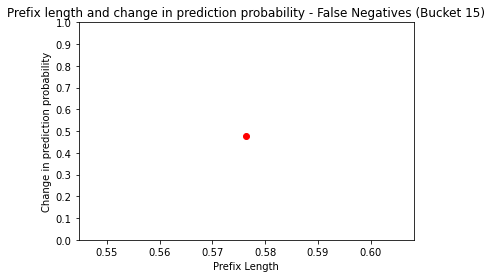

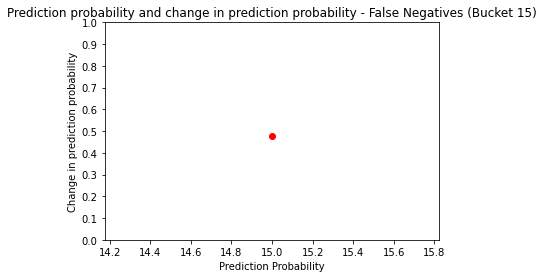

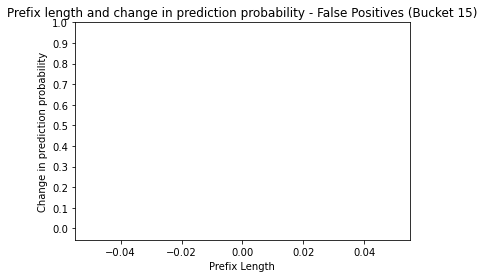

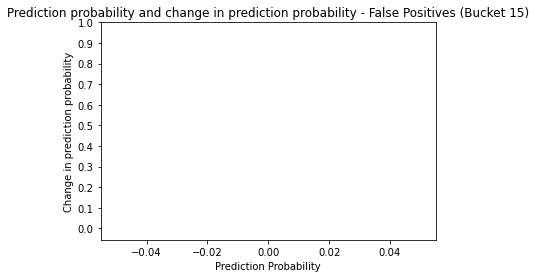

Bucket 16
Generating distributions for bucket
1 of 794 features
2 of 794 features
3 of 794 features
4 of 794 features
5 of 794 features
6 of 794 features
7 of 794 features
8 of 794 features
9 of 794 features
10 of 794 features
11 of 794 features
12 of 794 features
13 of 794 features
14 of 794 features
15 of 794 features
16 of 794 features
17 of 794 features
18 of 794 features
19 of 794 features
20 of 794 features
21 of 794 features
22 of 794 features
23 of 794 features
24 of 794 features
25 of 794 features
26 of 794 features
27 of 794 features
28 of 794 features
29 of 794 features
30 of 794 features
31 of 794 features
32 of 794 features
33 of 794 features
34 of 794 features
35 of 794 features
36 of 794 features
37 of 794 features
38 of 794 features
39 of 794 features
40 of 794 features
41 of 794 features
42 of 794 features
43 of 794 features
44 of 794 features
45 of 794 features
46 of 794 features
47 of 794 features
48 of 794 features
49 of 794 features
50 of 794 features
51 of 794 fea

492 of 794 features
493 of 794 features
494 of 794 features
495 of 794 features
496 of 794 features
497 of 794 features
498 of 794 features
499 of 794 features
500 of 794 features
501 of 794 features
502 of 794 features
503 of 794 features
504 of 794 features
505 of 794 features
506 of 794 features
507 of 794 features
508 of 794 features
509 of 794 features
510 of 794 features
511 of 794 features
512 of 794 features
513 of 794 features
514 of 794 features
515 of 794 features
516 of 794 features
517 of 794 features
518 of 794 features
519 of 794 features
520 of 794 features
521 of 794 features
522 of 794 features
523 of 794 features
524 of 794 features
525 of 794 features
526 of 794 features
527 of 794 features
528 of 794 features
529 of 794 features
530 of 794 features
531 of 794 features
532 of 794 features
533 of 794 features
534 of 794 features
535 of 794 features
536 of 794 features
537 of 794 features
538 of 794 features
539 of 794 features
540 of 794 features
541 of 794 features


Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 79
Creating distribution for feature 2 of 79
Creating distribution for feature 3 of 79
Creating distribution for feature 4 of 79
Creating distribution for feature 5 of 79
Creating distribution for feature 6 of 79
Creating distribution for feature 7 of 79
Creating distribution for feature 8 of 79
Creating distribution for feature 9 of 79
Creating distribution for feature 10 of 79
Creating distribution for feature 11 of 79
Creating distribution for feature 12 of 79
Creating distribution for feature 13 of 79
Creating distribution for feature 14 of 79
Creating distribution for feature 15 of 79
Creating distribution for feature 16 of 79
Creating distribution for feature 17 of 79
Creating distribution for feature 18 of 79
Creating distribution for feature 19 of 79
Creating distribution for feature 20 of 79
Creating distribution for feature 21 of 79
Creating distribution for feature 22 of 79
Creating di

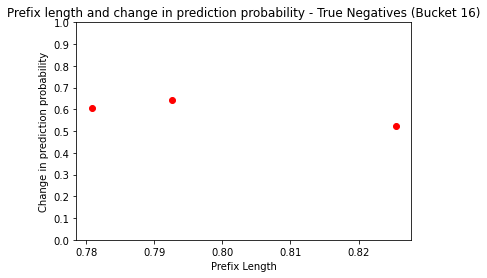

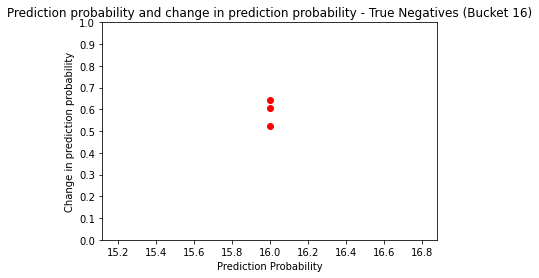

Category 2 of 4. Instance 1 of 5
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 79
Creating distribution for feature 2 of 79
Creating distribution for feature 3 of 79
Creating distribution for feature 4 of 79
Creating distribution for feature 5 of 79
Creating distribution for feature 6 of 79
Creating distribution for feature 7 of 79
Creating distribution for feature 8 of 79
Creating distribution for feature 9 of 79
Creating distribution for feature 10 of 79
Creating distribution for feature 11 of 79
Creating distribution for feature 12 of 79
Creating distribution for feature 13 of 79
Creating distribution for feature 14 of 79
Creating distribution for feature 15 of 79
Creating distribution for feature 16 of 79
Creating distribution for feature 17 of 79
Creating distribution for feature 18 of 79
Creating distribution for feature 19 of 79
Creating distribution for feature 20 of 79
Creating distribution for feature 21 of 79
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 79
Creating distribution for feature 2 of 79
Creating distribution for feature 3 of 79
Creating distribution for feature 4 of 79
Creating distribution for feature 5 of 79
Creating distribution for feature 6 of 79
Creating distribution for feature 7 of 79
Creating distribution for feature 8 of 79
Creating distribution for feature 9 of 79
Creating distribution for feature 10 of 79
Creating distribution for feature 11 of 79
Creating distribution for feature 12 of 79
Creating distribution for feature 13 of 79
Creating distribution for feature 14 of 79
Creating distribution for feature 15 of 79
Creating distribution for feature 16 of 79
Creating distribution for feature 17 of 79
Creating distribution for feature 18 of 79
Creating distribution for feature 19 of 79
Creating distribution for feature 20 of 79
Creating distribution for feature 21 of 79
Creating distribution for feature 22 of 79
Creating di

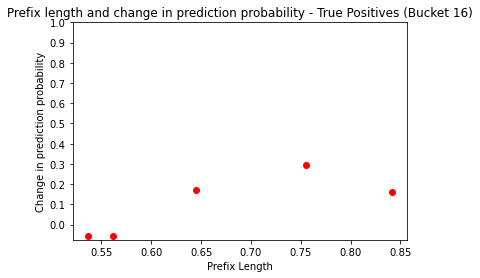

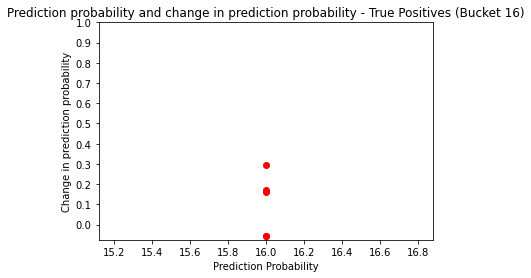

Category 3 of 4. Instance 1 of 2
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 79
Creating distribution for feature 2 of 79
Creating distribution for feature 3 of 79
Creating distribution for feature 4 of 79
Creating distribution for feature 5 of 79
Creating distribution for feature 6 of 79
Creating distribution for feature 7 of 79
Creating distribution for feature 8 of 79
Creating distribution for feature 9 of 79
Creating distribution for feature 10 of 79
Creating distribution for feature 11 of 79
Creating distribution for feature 12 of 79
Creating distribution for feature 13 of 79
Creating distribution for feature 14 of 79
Creating distribution for feature 15 of 79
Creating distribution for feature 16 of 79
Creating distribution for feature 17 of 79
Creating distribution for feature 18 of 79
Creating distribution for feature 19 of 79
Creating distribution for feature 20 of 79
Creating distribution for feature 21 of 79
Creating distribution

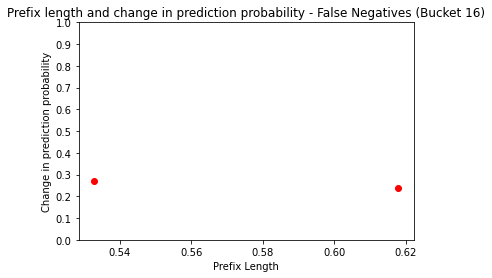

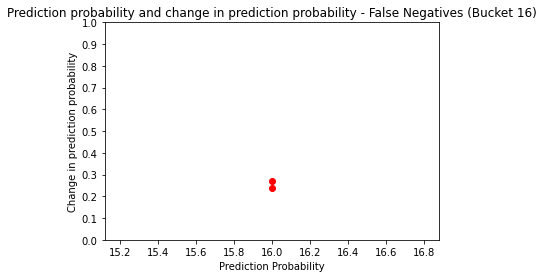

Category 4 of 4. Instance 1 of 1
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 79
Creating distribution for feature 2 of 79
Creating distribution for feature 3 of 79
Creating distribution for feature 4 of 79
Creating distribution for feature 5 of 79
Creating distribution for feature 6 of 79
Creating distribution for feature 7 of 79
Creating distribution for feature 8 of 79
Creating distribution for feature 9 of 79
Creating distribution for feature 10 of 79
Creating distribution for feature 11 of 79
Creating distribution for feature 12 of 79
Creating distribution for feature 13 of 79
Creating distribution for feature 14 of 79
Creating distribution for feature 15 of 79
Creating distribution for feature 16 of 79
Creating distribution for feature 17 of 79
Creating distribution for feature 18 of 79
Creating distribution for feature 19 of 79
Creating distribution for feature 20 of 79
Creating distribution for feature 21 of 79
Creating distribution

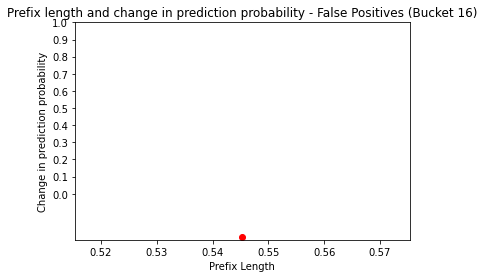

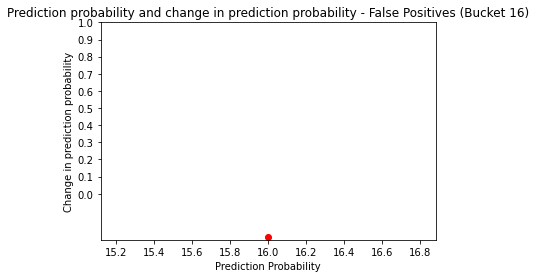

Bucket 17
Generating distributions for bucket
1 of 796 features
2 of 796 features
3 of 796 features
4 of 796 features
5 of 796 features
6 of 796 features
7 of 796 features
8 of 796 features
9 of 796 features
10 of 796 features
11 of 796 features
12 of 796 features
13 of 796 features
14 of 796 features
15 of 796 features
16 of 796 features
17 of 796 features
18 of 796 features
19 of 796 features
20 of 796 features
21 of 796 features
22 of 796 features
23 of 796 features
24 of 796 features
25 of 796 features
26 of 796 features
27 of 796 features
28 of 796 features
29 of 796 features
30 of 796 features
31 of 796 features
32 of 796 features
33 of 796 features
34 of 796 features
35 of 796 features
36 of 796 features
37 of 796 features
38 of 796 features
39 of 796 features
40 of 796 features
41 of 796 features
42 of 796 features
43 of 796 features
44 of 796 features
45 of 796 features
46 of 796 features
47 of 796 features
48 of 796 features
49 of 796 features
50 of 796 features
51 of 796 fea

449 of 796 features
450 of 796 features
451 of 796 features
452 of 796 features
453 of 796 features
454 of 796 features
455 of 796 features
456 of 796 features
457 of 796 features
458 of 796 features
459 of 796 features
460 of 796 features
461 of 796 features
462 of 796 features
463 of 796 features
464 of 796 features
465 of 796 features
466 of 796 features
467 of 796 features
468 of 796 features
469 of 796 features
470 of 796 features
471 of 796 features
472 of 796 features
473 of 796 features
474 of 796 features
475 of 796 features
476 of 796 features
477 of 796 features
478 of 796 features
479 of 796 features
480 of 796 features
481 of 796 features
482 of 796 features
483 of 796 features
484 of 796 features
485 of 796 features
486 of 796 features
487 of 796 features
488 of 796 features
489 of 796 features
490 of 796 features
491 of 796 features
492 of 796 features
493 of 796 features
494 of 796 features
495 of 796 features
496 of 796 features
497 of 796 features
498 of 796 features


Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 80
Creating distribution for feature 2 of 80
Creating distribution for feature 3 of 80
Creating distribution for feature 4 of 80
Creating distribution for feature 5 of 80
Creating distribution for feature 6 of 80
Creating distribution for feature 7 of 80
Creating distribution for feature 8 of 80
Creating distribution for feature 9 of 80
Creating distribution for feature 10 of 80
Creating distribution for feature 11 of 80
Creating distribution for feature 12 of 80
Creating distribution for feature 13 of 80
Creating distribution for feature 14 of 80
Creating distribution for feature 15 of 80
Creating distribution for feature 16 of 80
Creating distribution for feature 17 of 80
Creating distribution for feature 18 of 80
Creating distribution for feature 19 of 80
Creating distribution for feature 20 of 80
Creating distribution for feature 21 of 80
Creating distribution for feature 22 of 80
Creating di

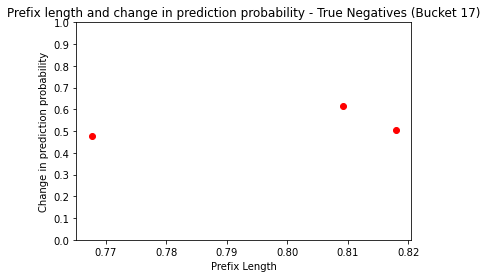

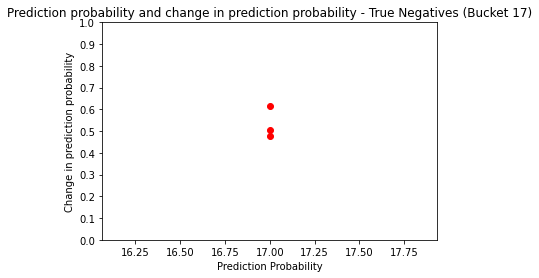

Category 2 of 4. Instance 1 of 4
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 80
Creating distribution for feature 2 of 80
Creating distribution for feature 3 of 80
Creating distribution for feature 4 of 80
Creating distribution for feature 5 of 80
Creating distribution for feature 6 of 80
Creating distribution for feature 7 of 80
Creating distribution for feature 8 of 80
Creating distribution for feature 9 of 80
Creating distribution for feature 10 of 80
Creating distribution for feature 11 of 80
Creating distribution for feature 12 of 80
Creating distribution for feature 13 of 80
Creating distribution for feature 14 of 80
Creating distribution for feature 15 of 80
Creating distribution for feature 16 of 80
Creating distribution for feature 17 of 80
Creating distribution for feature 18 of 80
Creating distribution for feature 19 of 80
Creating distribution for feature 20 of 80
Creating distribution for feature 21 of 80
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 80
Creating distribution for feature 2 of 80
Creating distribution for feature 3 of 80
Creating distribution for feature 4 of 80
Creating distribution for feature 5 of 80
Creating distribution for feature 6 of 80
Creating distribution for feature 7 of 80
Creating distribution for feature 8 of 80
Creating distribution for feature 9 of 80
Creating distribution for feature 10 of 80
Creating distribution for feature 11 of 80
Creating distribution for feature 12 of 80
Creating distribution for feature 13 of 80
Creating distribution for feature 14 of 80
Creating distribution for feature 15 of 80
Creating distribution for feature 16 of 80
Creating distribution for feature 17 of 80
Creating distribution for feature 18 of 80
Creating distribution for feature 19 of 80
Creating distribution for feature 20 of 80
Creating distribution for feature 21 of 80
Creating distribution for feature 22 of 80
Creating di

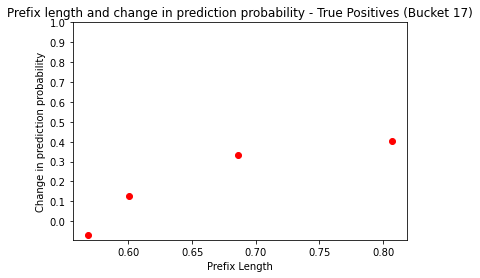

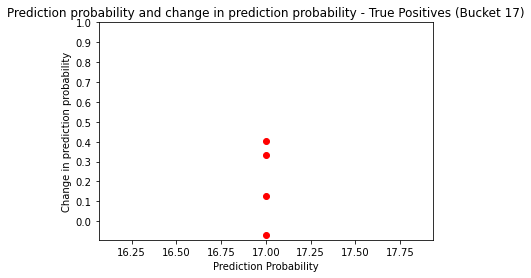

Category 3 of 4. Instance 1 of 1
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 80
Creating distribution for feature 2 of 80
Creating distribution for feature 3 of 80
Creating distribution for feature 4 of 80
Creating distribution for feature 5 of 80
Creating distribution for feature 6 of 80
Creating distribution for feature 7 of 80
Creating distribution for feature 8 of 80
Creating distribution for feature 9 of 80
Creating distribution for feature 10 of 80
Creating distribution for feature 11 of 80
Creating distribution for feature 12 of 80
Creating distribution for feature 13 of 80
Creating distribution for feature 14 of 80
Creating distribution for feature 15 of 80
Creating distribution for feature 16 of 80
Creating distribution for feature 17 of 80
Creating distribution for feature 18 of 80
Creating distribution for feature 19 of 80
Creating distribution for feature 20 of 80
Creating distribution for feature 21 of 80
Creating distribution

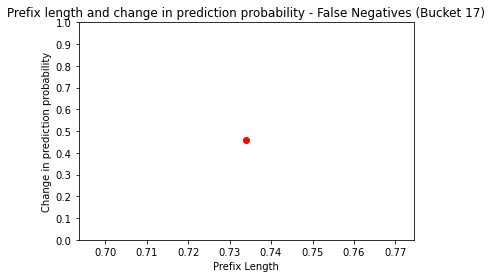

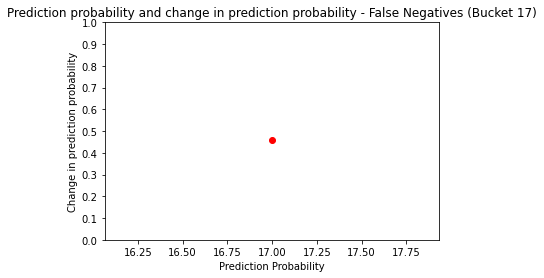

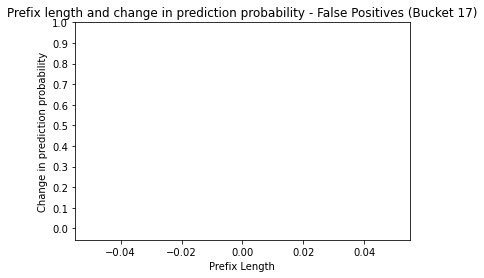

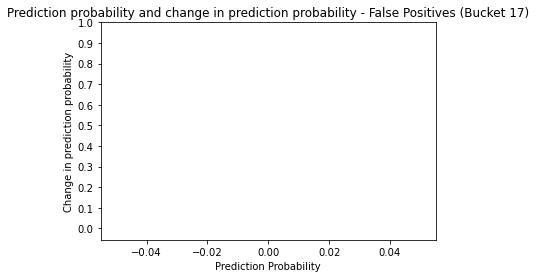

Bucket 18
Generating distributions for bucket
1 of 861 features
2 of 861 features
3 of 861 features
4 of 861 features
5 of 861 features
6 of 861 features
7 of 861 features
8 of 861 features
9 of 861 features
10 of 861 features
11 of 861 features
12 of 861 features
13 of 861 features
14 of 861 features
15 of 861 features
16 of 861 features
17 of 861 features
18 of 861 features
19 of 861 features
20 of 861 features
21 of 861 features
22 of 861 features
23 of 861 features
24 of 861 features
25 of 861 features
26 of 861 features
27 of 861 features
28 of 861 features
29 of 861 features
30 of 861 features
31 of 861 features
32 of 861 features
33 of 861 features
34 of 861 features
35 of 861 features
36 of 861 features
37 of 861 features
38 of 861 features
39 of 861 features
40 of 861 features
41 of 861 features
42 of 861 features
43 of 861 features
44 of 861 features
45 of 861 features
46 of 861 features
47 of 861 features
48 of 861 features
49 of 861 features
50 of 861 features
51 of 861 fea

490 of 861 features
491 of 861 features
492 of 861 features
493 of 861 features
494 of 861 features
495 of 861 features
496 of 861 features
497 of 861 features
498 of 861 features
499 of 861 features
500 of 861 features
501 of 861 features
502 of 861 features
503 of 861 features
504 of 861 features
505 of 861 features
506 of 861 features
507 of 861 features
508 of 861 features
509 of 861 features
510 of 861 features
511 of 861 features
512 of 861 features
513 of 861 features
514 of 861 features
515 of 861 features
516 of 861 features
517 of 861 features
518 of 861 features
519 of 861 features
520 of 861 features
521 of 861 features
522 of 861 features
523 of 861 features
524 of 861 features
525 of 861 features
526 of 861 features
527 of 861 features
528 of 861 features
529 of 861 features
530 of 861 features
531 of 861 features
532 of 861 features
533 of 861 features
534 of 861 features
535 of 861 features
536 of 861 features
537 of 861 features
538 of 861 features
539 of 861 features


Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 86
Creating distribution for feature 2 of 86
Creating distribution for feature 3 of 86
Creating distribution for feature 4 of 86
Creating distribution for feature 5 of 86
Creating distribution for feature 6 of 86
Creating distribution for feature 7 of 86
Creating distribution for feature 8 of 86
Creating distribution for feature 9 of 86
Creating distribution for feature 10 of 86
Creating distribution for feature 11 of 86
Creating distribution for feature 12 of 86
Creating distribution for feature 13 of 86
Creating distribution for feature 14 of 86
Creating distribution for feature 15 of 86
Creating distribution for feature 16 of 86
Creating distribution for feature 17 of 86
Creating distribution for feature 18 of 86
Creating distribution for feature 19 of 86
Creating distribution for feature 20 of 86
Creating distribution for feature 21 of 86
Creating distribution for feature 22 of 86
Creating di

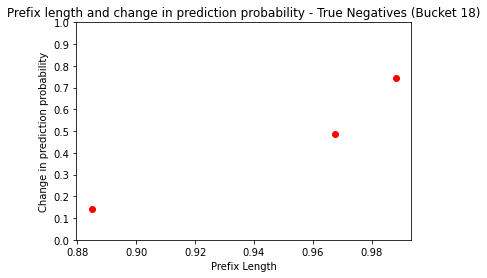

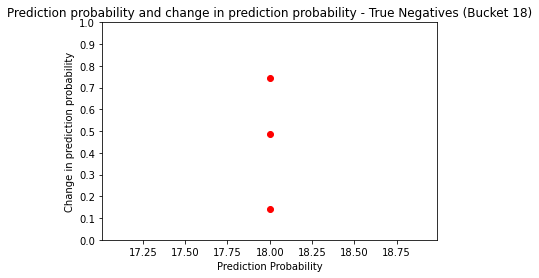

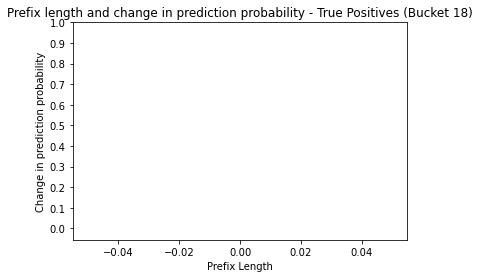

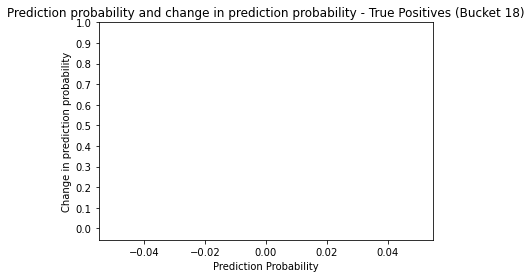

Category 3 of 4. Instance 1 of 3
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 86
Creating distribution for feature 2 of 86
Creating distribution for feature 3 of 86
Creating distribution for feature 4 of 86
Creating distribution for feature 5 of 86
Creating distribution for feature 6 of 86
Creating distribution for feature 7 of 86
Creating distribution for feature 8 of 86
Creating distribution for feature 9 of 86
Creating distribution for feature 10 of 86
Creating distribution for feature 11 of 86
Creating distribution for feature 12 of 86
Creating distribution for feature 13 of 86
Creating distribution for feature 14 of 86
Creating distribution for feature 15 of 86
Creating distribution for feature 16 of 86
Creating distribution for feature 17 of 86
Creating distribution for feature 18 of 86
Creating distribution for feature 19 of 86
Creating distribution for feature 20 of 86
Creating distribution for feature 21 of 86
Creating distribution

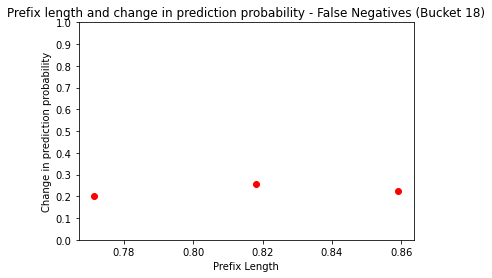

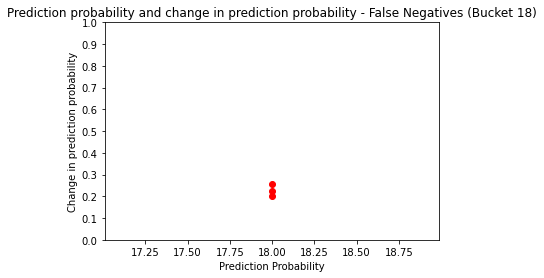

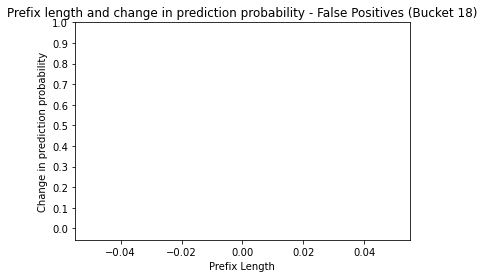

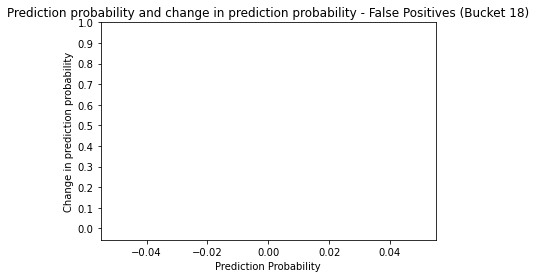

Bucket 19
Generating distributions for bucket
1 of 890 features
2 of 890 features
3 of 890 features
4 of 890 features
5 of 890 features
6 of 890 features
7 of 890 features
8 of 890 features
9 of 890 features
10 of 890 features
11 of 890 features
12 of 890 features
13 of 890 features
14 of 890 features
15 of 890 features
16 of 890 features
17 of 890 features
18 of 890 features
19 of 890 features
20 of 890 features
21 of 890 features
22 of 890 features
23 of 890 features
24 of 890 features
25 of 890 features
26 of 890 features
27 of 890 features
28 of 890 features
29 of 890 features
30 of 890 features
31 of 890 features
32 of 890 features
33 of 890 features
34 of 890 features
35 of 890 features
36 of 890 features
37 of 890 features
38 of 890 features
39 of 890 features
40 of 890 features
41 of 890 features
42 of 890 features
43 of 890 features
44 of 890 features
45 of 890 features
46 of 890 features
47 of 890 features
48 of 890 features
49 of 890 features
50 of 890 features
51 of 890 fea

488 of 890 features
489 of 890 features
490 of 890 features
491 of 890 features
492 of 890 features
493 of 890 features
494 of 890 features
495 of 890 features
496 of 890 features
497 of 890 features
498 of 890 features
499 of 890 features
500 of 890 features
501 of 890 features
502 of 890 features
503 of 890 features
504 of 890 features
505 of 890 features
506 of 890 features
507 of 890 features
508 of 890 features
509 of 890 features
510 of 890 features
511 of 890 features
512 of 890 features
513 of 890 features
514 of 890 features
515 of 890 features
516 of 890 features
517 of 890 features
518 of 890 features
519 of 890 features
520 of 890 features
521 of 890 features
522 of 890 features
523 of 890 features
524 of 890 features
525 of 890 features
526 of 890 features
527 of 890 features
528 of 890 features
529 of 890 features
530 of 890 features
531 of 890 features
532 of 890 features
533 of 890 features
534 of 890 features
535 of 890 features
536 of 890 features
537 of 890 features


Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 3
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 89
Creating distribution for feature 2 of 89
Creating distribution for feature 3 of 89
Creating distribution for feature 4 of 89
Creating distribution for feature 5 of 89
Creating distribution for feature 6 of 89
Creating distribution for feature 7 of 89
Creating distribution for feature 8 of 89
Creating distribution for feature 9 of 89
Creating distribution for feature 10 of 89
Creating distribution for feature 11 of 89
Creating distribution for feature 12 of 89
Creating distribution for feature 13 of 89
Creating distribution for feature 14 of 89
Creating distribution for feature 15 of 89
Creating distribution for feature 16 of 89
Creating distribution for feature 17 of 89
Creating distribution for feat

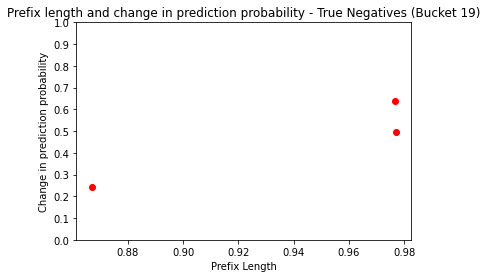

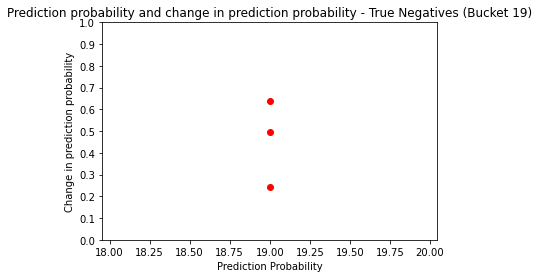

Category 2 of 4. Instance 1 of 1
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 89
Creating distribution for feature 2 of 89
Creating distribution for feature 3 of 89
Creating distribution for feature 4 of 89
Creating distribution for feature 5 of 89
Creating distribution for feature 6 of 89
Creating distribution for feature 7 of 89
Creating distribution for feature 8 of 89
Creating distribution for feature 9 of 89
Creating distribution for feature 10 of 89
Creating distribution for feature 11 of 89
Creating distribution for feature 12 of 89
Creating distribution for feature 13 of 89
Creating distribution for feature 14 of 89
Creating distribution for feature 15 of 89
Creating distribution for feature 16 of 89
Creating distribution for feature 17 of 89
Creating distribution for feature 18 of 89
Creating distribution for feature 19 of 89
Creating distribution for feature 20 of 89
Creating distribution for feature 21 of 89
Creating distribution

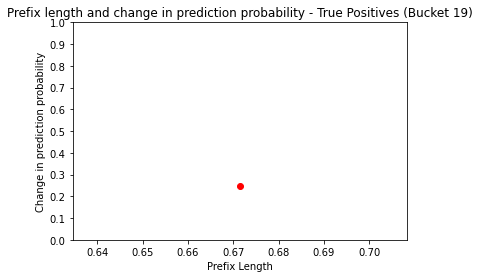

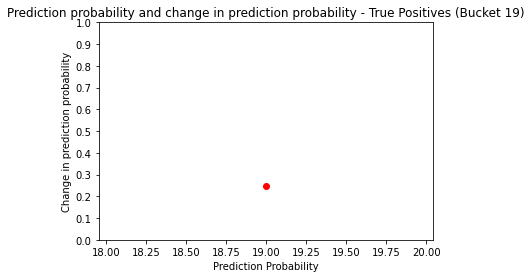

Category 3 of 4. Instance 1 of 3
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 89
Creating distribution for feature 2 of 89
Creating distribution for feature 3 of 89
Creating distribution for feature 4 of 89
Creating distribution for feature 5 of 89
Creating distribution for feature 6 of 89
Creating distribution for feature 7 of 89
Creating distribution for feature 8 of 89
Creating distribution for feature 9 of 89
Creating distribution for feature 10 of 89
Creating distribution for feature 11 of 89
Creating distribution for feature 12 of 89
Creating distribution for feature 13 of 89
Creating distribution for feature 14 of 89
Creating distribution for feature 15 of 89
Creating distribution for feature 16 of 89
Creating distribution for feature 17 of 89
Creating distribution for feature 18 of 89
Creating distribution for feature 19 of 89
Creating distribution for feature 20 of 89
Creating distribution for feature 21 of 89
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 89
Creating distribution for feature 2 of 89
Creating distribution for feature 3 of 89
Creating distribution for feature 4 of 89
Creating distribution for feature 5 of 89
Creating distribution for feature 6 of 89
Creating distribution for feature 7 of 89
Creating distribution for feature 8 of 89
Creating distribution for feature 9 of 89
Creating distribution for feature 10 of 89
Creating distribution for feature 11 of 89
Creating distribution for feature 12 of 89
Creating distribution for feature 13 of 89
Creating distribution for feature 14 of 89
Creating distribution for feature 15 of 89
Creating distribution for feature 16 of 89
Creating distribution for feature 17 of 89
Creating distribution for feature 18 of 89
Creating distribution for feature 19 of 89
Creating distribution for feature 20 of 89
Creating distribution for feature 21 of 89
Creating distribution for feature 22 of 89
Creating di

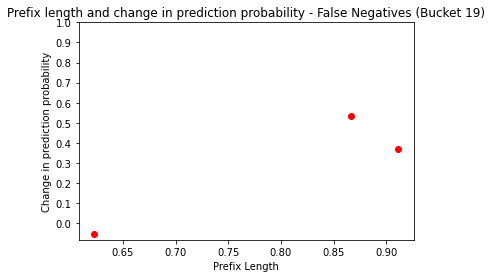

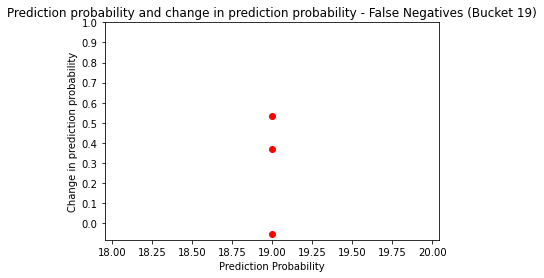

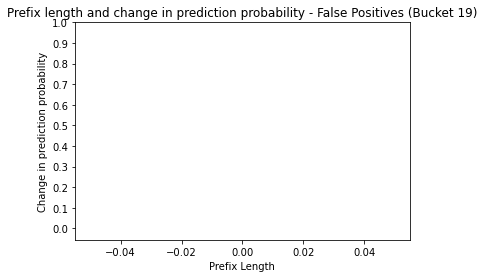

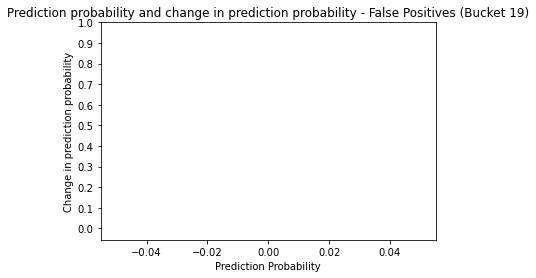

Bucket 20
Generating distributions for bucket
1 of 844 features
2 of 844 features
3 of 844 features
4 of 844 features
5 of 844 features
6 of 844 features
7 of 844 features
8 of 844 features
9 of 844 features
10 of 844 features
11 of 844 features
12 of 844 features
13 of 844 features
14 of 844 features
15 of 844 features
16 of 844 features
17 of 844 features
18 of 844 features
19 of 844 features
20 of 844 features
21 of 844 features
22 of 844 features
23 of 844 features
24 of 844 features
25 of 844 features
26 of 844 features
27 of 844 features
28 of 844 features
29 of 844 features
30 of 844 features
31 of 844 features
32 of 844 features
33 of 844 features
34 of 844 features
35 of 844 features
36 of 844 features
37 of 844 features
38 of 844 features
39 of 844 features
40 of 844 features
41 of 844 features
42 of 844 features
43 of 844 features
44 of 844 features
45 of 844 features
46 of 844 features
47 of 844 features
48 of 844 features
49 of 844 features
50 of 844 features
51 of 844 fea

529 of 844 features
530 of 844 features
531 of 844 features
532 of 844 features
533 of 844 features
534 of 844 features
535 of 844 features
536 of 844 features
537 of 844 features
538 of 844 features
539 of 844 features
540 of 844 features
541 of 844 features
542 of 844 features
543 of 844 features
544 of 844 features
545 of 844 features
546 of 844 features
547 of 844 features
548 of 844 features
549 of 844 features
550 of 844 features
551 of 844 features
552 of 844 features
553 of 844 features
554 of 844 features
555 of 844 features
556 of 844 features
557 of 844 features
558 of 844 features
559 of 844 features
560 of 844 features
561 of 844 features
562 of 844 features
563 of 844 features
564 of 844 features
565 of 844 features
566 of 844 features
567 of 844 features
568 of 844 features
569 of 844 features
570 of 844 features
571 of 844 features
572 of 844 features
573 of 844 features
574 of 844 features
575 of 844 features
576 of 844 features
577 of 844 features
578 of 844 features


Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 84
Creating distribution for feature 2 of 84
Creating distribution for feature 3 of 84
Creating distribution for feature 4 of 84
Creating distribution for feature 5 of 84
Creating distribution for feature 6 of 84
Creating distribution for feature 7 of 84
Creating distribution for feature 8 of 84
Creating distribution for feature 9 of 84
Creating distribution for feature 10 of 84
Creating distribution for feature 11 of 84
Creating distribution for feature 12 of 84
Creating distribution for feature 13 of 84
Creating distribution for feature 14 of 84
Creating distribution for feature 15 of 84
Creating distribution for feature 16 of 84
Creating distribution for feature 17 of 84
Creating distribution for feature 18 of 84
Creating distribution for feature 19 of 84
Creating distribution for feature 20 of 84
Creating distribution for feature 21 of 84
Creating distribution for feature 22 of 84
Creating di

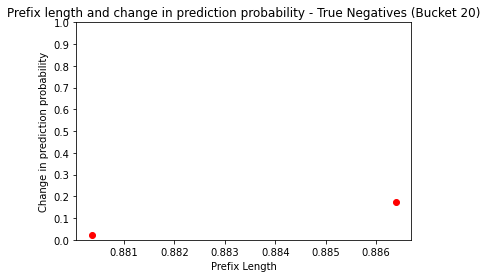

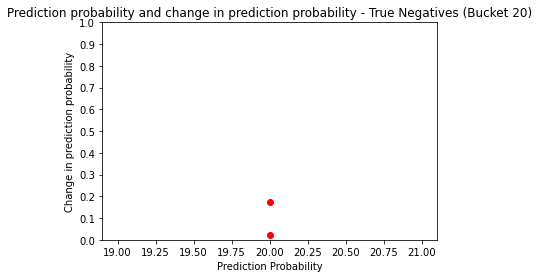

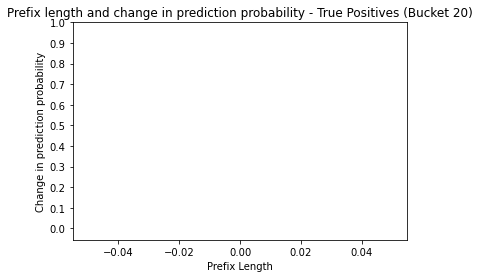

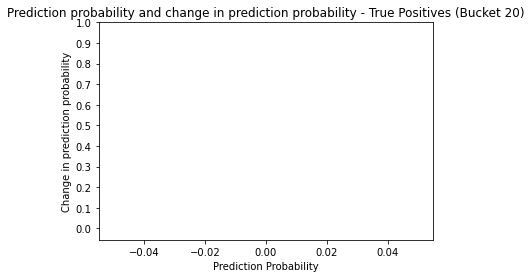

Category 3 of 4. Instance 1 of 3
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 84
Creating distribution for feature 2 of 84
Creating distribution for feature 3 of 84
Creating distribution for feature 4 of 84
Creating distribution for feature 5 of 84
Creating distribution for feature 6 of 84
Creating distribution for feature 7 of 84
Creating distribution for feature 8 of 84
Creating distribution for feature 9 of 84
Creating distribution for feature 10 of 84
Creating distribution for feature 11 of 84
Creating distribution for feature 12 of 84
Creating distribution for feature 13 of 84
Creating distribution for feature 14 of 84
Creating distribution for feature 15 of 84
Creating distribution for feature 16 of 84
Creating distribution for feature 17 of 84
Creating distribution for feature 18 of 84
Creating distribution for feature 19 of 84
Creating distribution for feature 20 of 84
Creating distribution for feature 21 of 84
Creating distribution

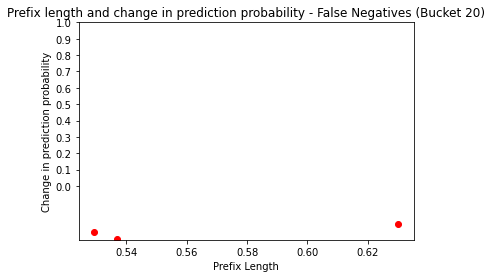

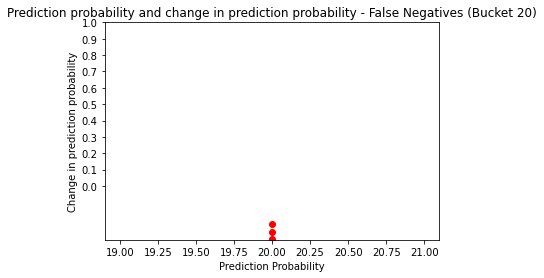

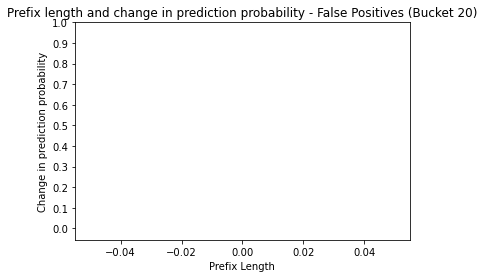

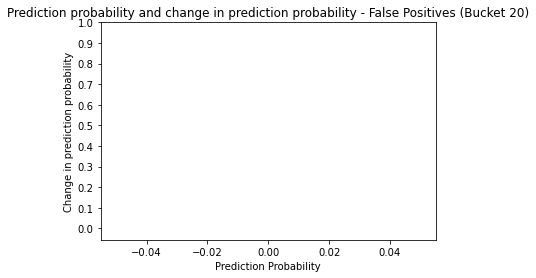

In [10]:
if generate_model_shap:
    for dataset_name in datasets:

        dataset_manager = DatasetManager(dataset_name)

        for ii in range(n_iter):
            num_buckets = len([name for name in os.listdir(os.path.join(PATH,'%s/%s_%s/models'% (dataset_ref, cls_method, method_name)))])-1
            
            if num_buckets < max_prefix:
                max_prefix = num_buckets

            print(max_prefix)
            
            buckets = range(0, max_prefix, gap)

            all_shap_changes = []
            all_lens = []
            all_probas = []
            all_case_ids = []

            pos_shap_changes = []
            pos_probas = []
            pos_nr_events = []
            pos_case_ids = []

            neg_shap_changes = []
            neg_probas = []
            neg_nr_events = []
            neg_case_ids = []

            for bucket in buckets:
                bucketID = bucket+1
                print ('Bucket', bucketID)

                #import everything needed to sort and predict
                feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls = joblib.load(cls_path)
                feature_combiner = joblib.load(feat_comb_path)

                #import data for bucket
                X_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                Y_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                with open (X_test_path, 'rb') as f:
                    dt_test_bucket = pickle.load(f)
                with open (Y_test_path, 'rb') as f:
                    test_y = pickle.load(f)
                #with open (X_test_path, 'rb') as f:
                #    dt_test_bucket = pickle.load(f)
                #with open (Y_test_path, 'rb') as f:
                #    test_y = pickle.load(f)

                #import previously identified samples
                tn_path = os.path.join(PATH, "%s/%s_%s/samples/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                tp_path = os.path.join(PATH, "%s/%s_%s/samples/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fn_path = os.path.join(PATH, "%s/%s_%s/samples/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fp_path = os.path.join(PATH, "%s/%s_%s/samples/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                sample_instances = []

                with open (tn_path, 'rb') as f:
                    tn_list = pickle.load(f)
                with open (tp_path, 'rb') as f:
                    tp_list = pickle.load(f)
                with open (fn_path, 'rb') as f:
                    fn_list = pickle.load(f)
                with open (fp_path, 'rb') as f:
                    fp_list = pickle.load(f)

                #save results to a list
                sample_instances.append(tn_list)
                sample_instances.append(tp_list)
                sample_instances.append(fn_list)
                sample_instances.append(fp_list)

                tree_explainer = shap.TreeExplainer(cls)
                test_x = feature_combiner.fit_transform(dt_test_bucket)
                feat_list = feature_combiner.get_feature_names()
                type_list = ['True Negatives', 'True Positives', 'False Negatives', 'False Positives']
                max_feat = round(len(feat_list)*0.1)
                #print(max_feat)
                
                print("Generating distributions for bucket")
                distribs = generate_distributions(tree_explainer, feat_list, test_x)

                for i_type in range(len(sample_instances)):
                    changes = []
                    probas = []
                    nr_events = []
                    case_ids = []

                    for n in range(len(sample_instances[i_type])):
                        print("Category %s of %s. Instance %s of %s" %(i_type+1, len(sample_instances), n+1, len(sample_instances[i_type])))
                        instance = sample_instances[i_type][n]

                        ind = instance['predicted']
                        case_ids.append(instance['caseID'])
                        p1 = instance['proba']
                        probas.append(p1)
                        nr_events.append(instance['nr_events'])
                        input_ = instance['input']

                        test_x_group = feature_combiner.fit_transform(input_) 
                        #test_x=np.transpose(test_x_group[0])
                        #print(test_x)
                        #print(p1)

                        print("Creating explanations")
                        exp, rel_exp = create_samples(tree_explainer, exp_iter, test_x_group, feat_list, top = max_feat)

                        features = []
                        shap_vals = []
                        
                        print("Identifying relevant features")
                        for explanation in rel_exp:
                            features.extend([feat[0] for feat in explanation])
                            shap_vals.extend([feat for feat in explanation])

                        counter = Counter(features).most_common(max_feat)

                        feats = [feat[0] for feat in counter]

                        rel_feats = []
                        for feat in feats:
                            vals = [i[1] for i in shap_vals if i[0] == feat]
                            #print(feat, vals)
                            val = np.mean(vals)
                            rel_feats.append((feat, val))

                        intervals = []
                        for item in rel_feats:
                            feat = item [0]
                            val = item[1]

                            print("Creating distribution for feature", rel_feats.index(item)+1, "of", len(rel_feats))

                            n = feat_list.index(feat)
                            feat_dict = distribs[n]

                            if feat_dict['Feature Name'] != feat:
                                for each in distribs:
                                    if feat_dict['Feature Name'] == feat:
                                        feat_dict = each

                            bins = feat_dict['bins']
                            mins = feat_dict['mins']
                            maxes = feat_dict['maxes']
                            #print (feat, val, bins, mins, maxes)

                            i = 0
                            while val > bins[i] and i < len(bins)-1:
                                idx = i
                                i+=1
                            #print (i)
                            if mins[i] != None:
                                min_val = mins[i]
                                max_val = maxes[i]
                            else:
                                j = i
                                while mins[j] == None and j > 0:
                                    min_val = mins[j-1]
                                    max_val = maxes[j-1]
                                    j = j-1

                            interval = max_val - min_val
                            if interval == 0:
                                interval = 1

                            index = feat_list.index(feat)
                            int_min = max_val
                            int_max = max_val + interval
                            intervals.append((feat, index, int_min, int_max))


                        diffs = []

                        for iteration in range(exp_iter):
                            print("Pertubing - Run", iteration+1)
                            alt_x = np.copy(test_x_group)
                            #print("original:", alt_x)
                            for each in intervals:
                                new_val = random.uniform(each[2], each[3])
                                alt_x[0][each[1]] = new_val
                            p2 = cls.predict_proba(alt_x)[0][ind]
                            diff = p1-p2
                            diffs.append(diff)

                        changes.append(np.mean(diffs))

                        instance['shap_fid_change'] = diffs
                        #print("RMSE for instance:", np.std(diffs))


                        if ind == 0:
                            pos_shap_changes.append(abs(diff))#np.std(diffs))
                            pos_probas.append(p1)
                            pos_nr_events.append(instance['nr_events'])
                            pos_case_ids.append(instance['caseID'])
                        else:
                            neg_shap_changes.append(abs(diff))#np.std(diffs))
                            neg_probas.append(p1)
                            neg_nr_events.append(instance['nr_events'])
                            neg_case_ids.append(instance['caseID'])

                    fig, ax = plt.subplots()
                    ax.plot(probas, changes, 'ro', label = "SHAP")
                    ax.set_xlabel("Prefix Length")
                    ax.set_ylabel("Change in prediction probability")
                    #ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prefix length and change in prediction probability - %s (Bucket %s)" %(type_list[i_type], bucketID))
                    plt.show()

                    fig2, ax2 = plt.subplots()
                    ax2.plot(nr_events, changes, 'ro', label = "SHAP")
                    ax2.set_xlabel("Prediction Probability")
                    ax2.set_ylabel("Change in prediction probability")
                    #ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prediction probability and change in prediction probability - %s (Bucket %s)" %(type_list[i_type], bucketID))
                    plt.show()

                    all_shap_changes.extend(changes)
                    all_lens.extend(nr_events)
                    all_probas.extend(probas)
                    all_case_ids.extend(case_ids)

                #Save dictionaries updated with scores
                with open(tn_path, 'wb') as f:
                    pickle.dump(sample_instances[0], f)
                with open(tp_path, 'wb') as f:
                    pickle.dump(sample_instances[1], f)
                with open(fn_path, 'wb') as f:
                    pickle.dump(sample_instances[2], f)
                with open(fp_path, 'wb') as f:
                    pickle.dump(sample_instances[3], f)

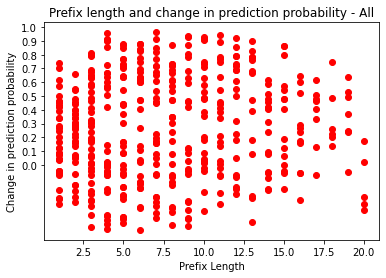

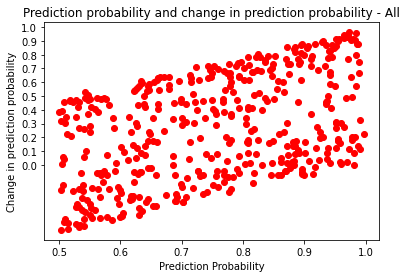

In [11]:
fig, ax = plt.subplots()
ax.plot(all_lens, all_shap_changes, 'ro', label = "SHAP")
ax.set_xlabel("Prefix Length")
ax.set_ylabel("Change in prediction probability")
#ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prefix length and change in prediction probability - All")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(all_probas, all_shap_changes, 'ro', label = "SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - All")
plt.show()

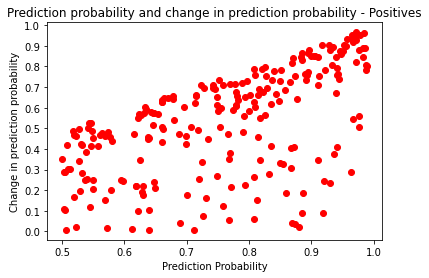

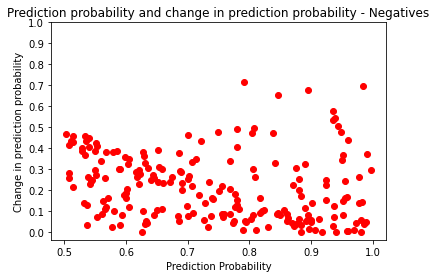

In [12]:
fig2, ax2 = plt.subplots()
ax2.plot(pos_probas, pos_shap_changes, 'ro', label = "SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Positives")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(neg_probas, neg_shap_changes, 'ro', label = "SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Negatives")
plt.show()

Bucket 1
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pert

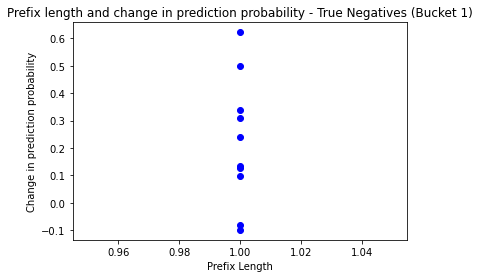

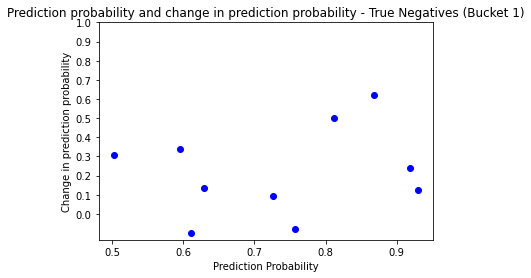

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - R

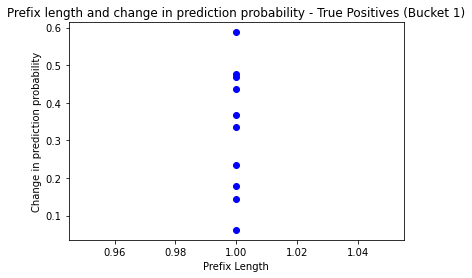

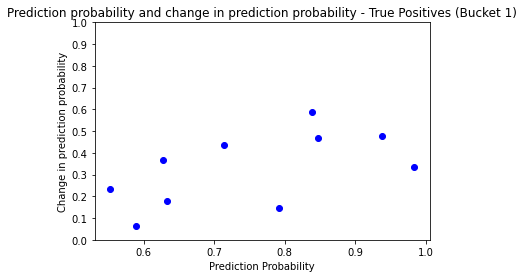

Category 3 of 4. Instance 1 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run

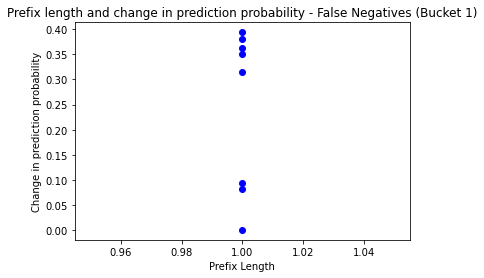

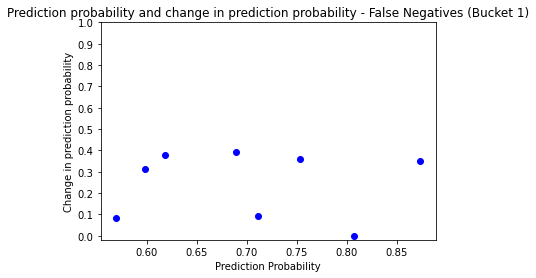

Category 4 of 4. Instance 1 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run

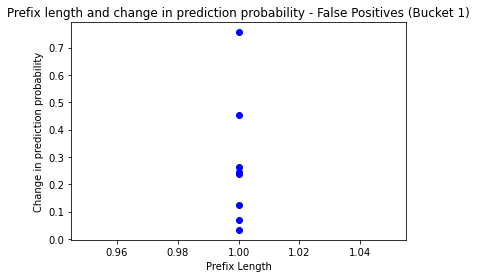

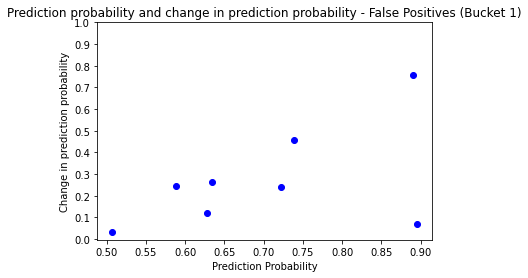

Bucket 2
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distri

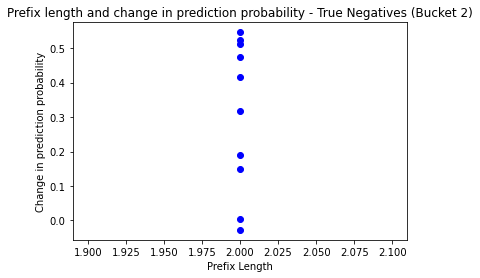

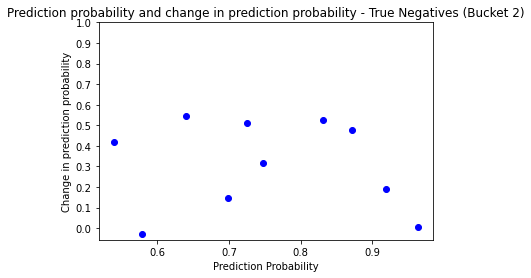

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution fo

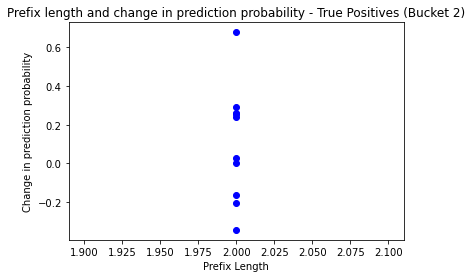

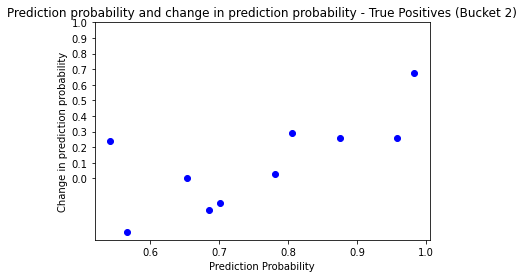

Category 3 of 4. Instance 1 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for 

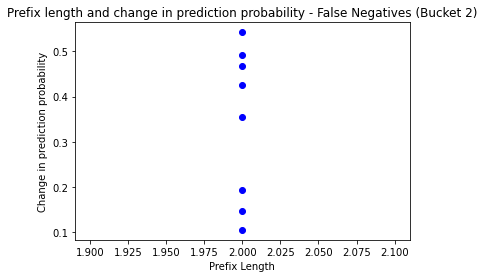

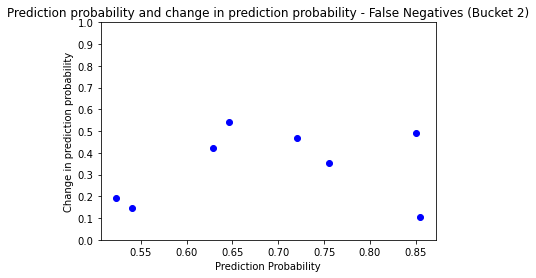

Category 4 of 4. Instance 1 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for 

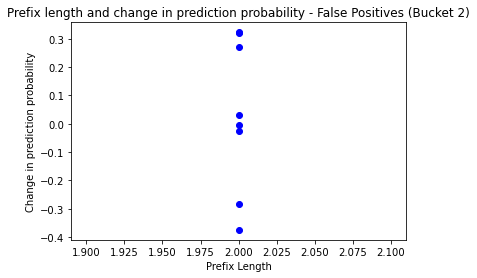

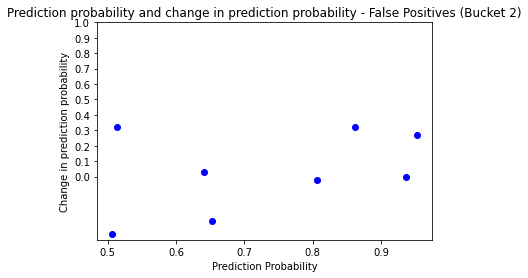

Bucket 3
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Pertubing - Run 1
Pertubing - Run 2
Pertub

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - R

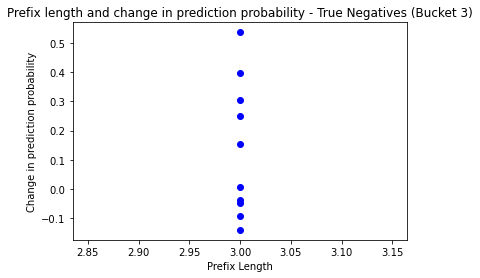

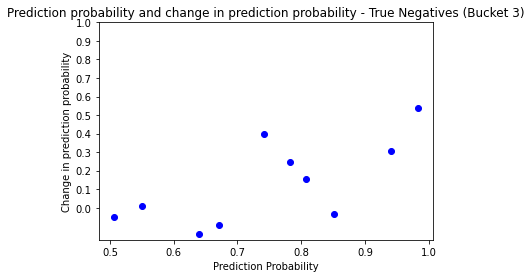

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - R

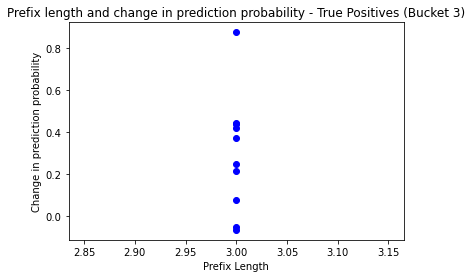

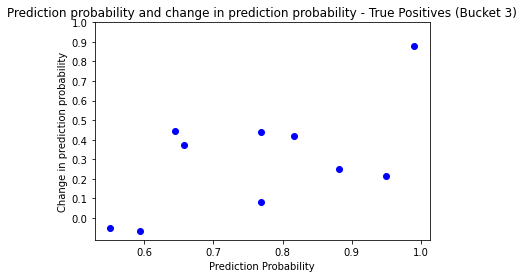

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - R

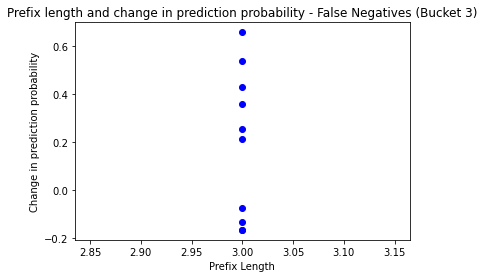

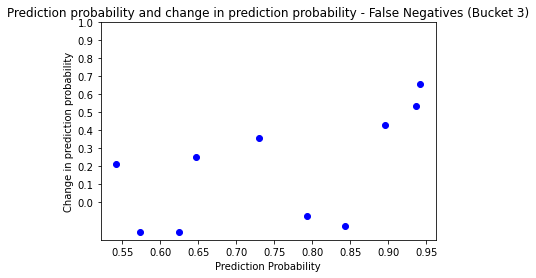

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - R

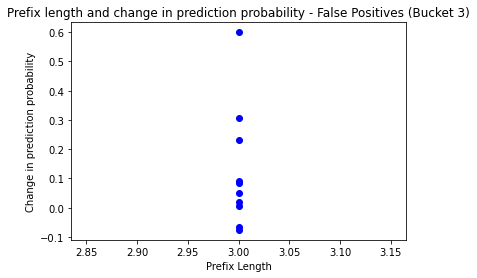

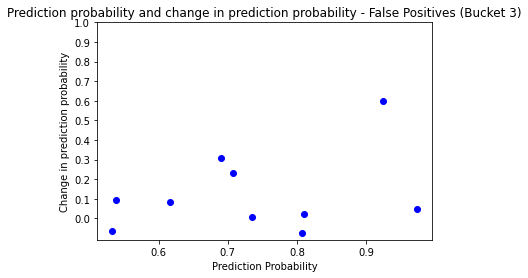

Bucket 4
Category 1 of 4. Instance 1 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creati

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

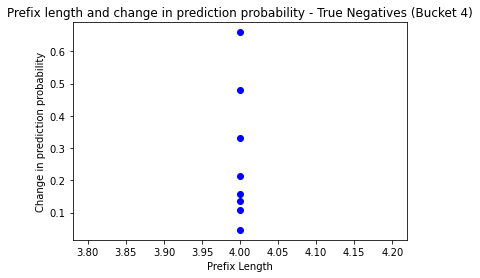

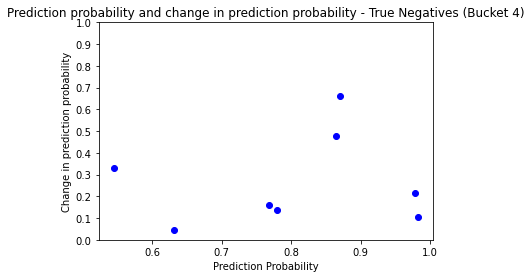

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distr

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

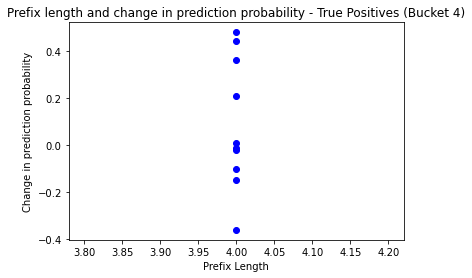

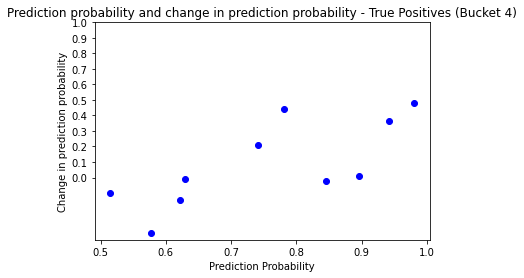

Category 3 of 4. Instance 1 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

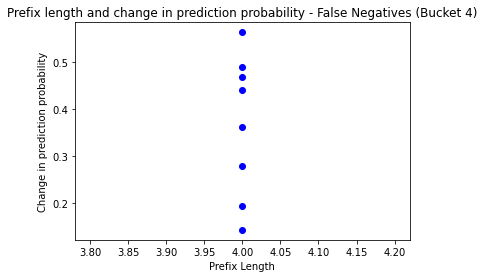

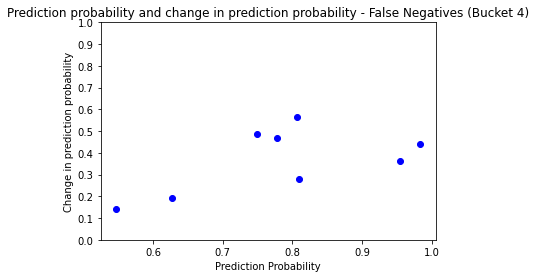

Category 4 of 4. Instance 1 of 7
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

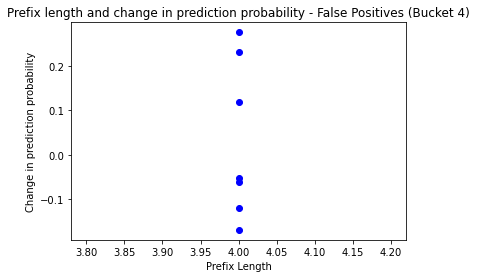

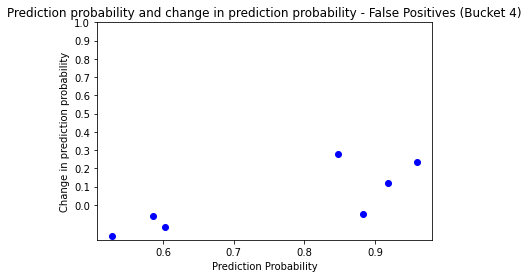

Bucket 5
Category 1 of 4. Instance 1 of 9
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creati

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

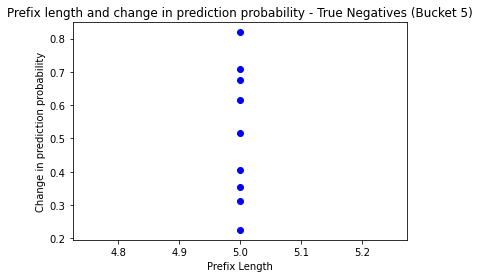

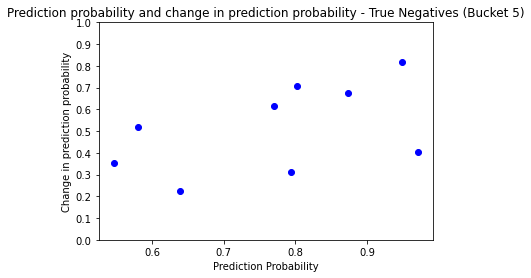

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distr

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

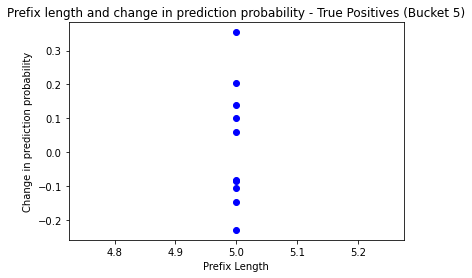

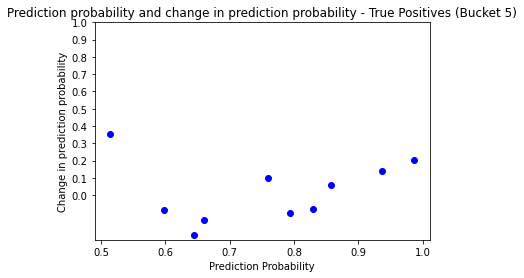

Category 3 of 4. Instance 1 of 7
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

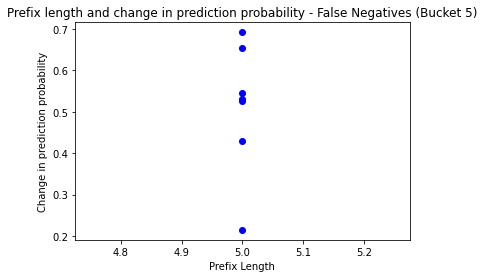

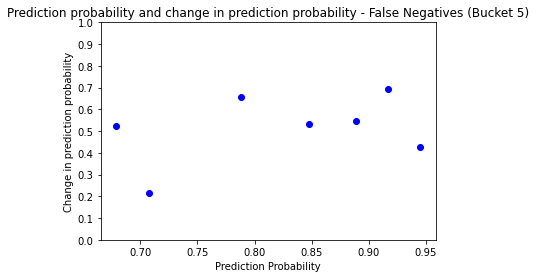

Category 4 of 4. Instance 1 of 9
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

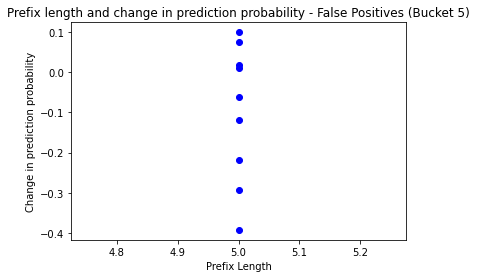

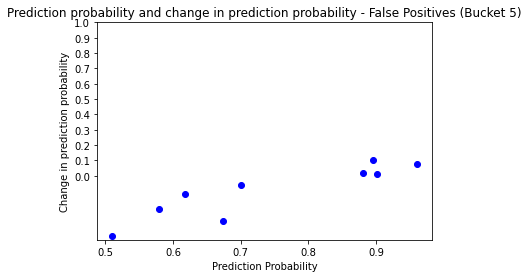

Bucket 6
Category 1 of 4. Instance 1 of 7
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creati

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

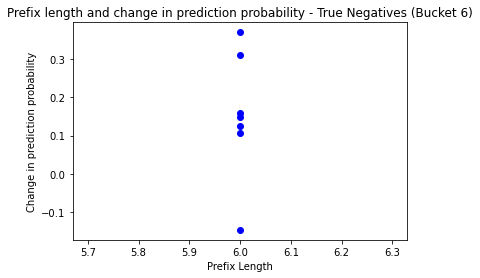

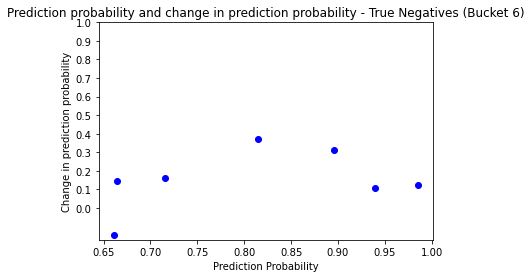

Category 2 of 4. Instance 1 of 7
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

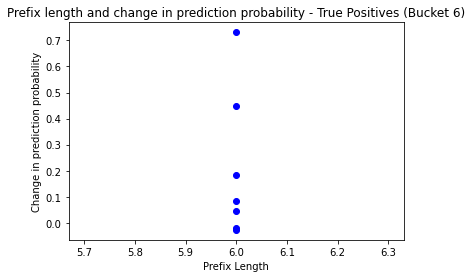

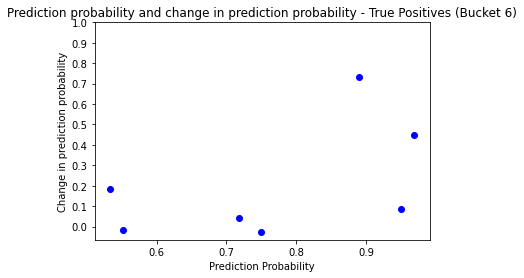

Category 3 of 4. Instance 1 of 9
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

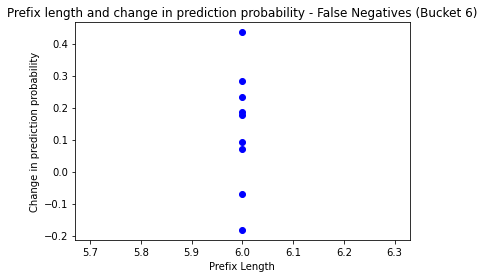

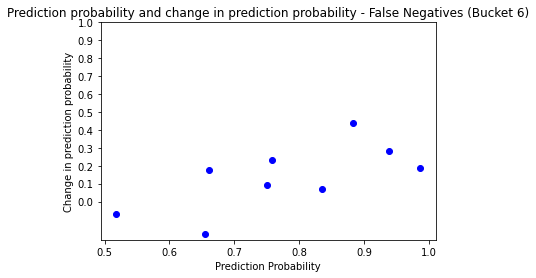

Category 4 of 4. Instance 1 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

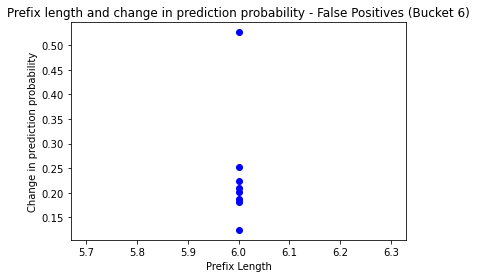

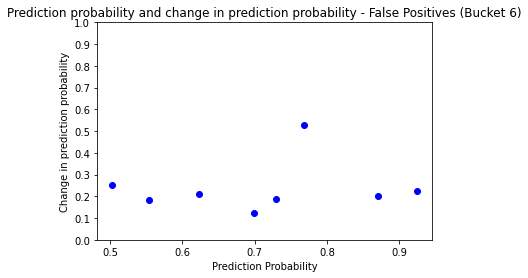

Bucket 7
Category 1 of 4. Instance 1 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creati

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

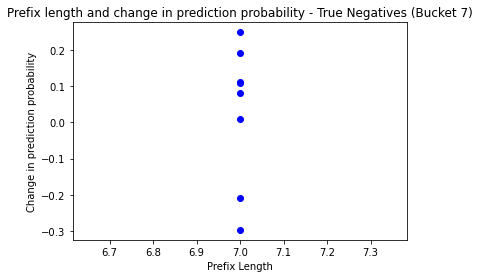

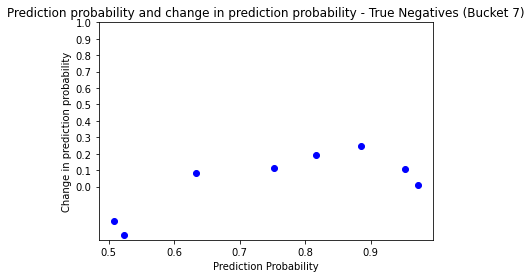

Category 2 of 4. Instance 1 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

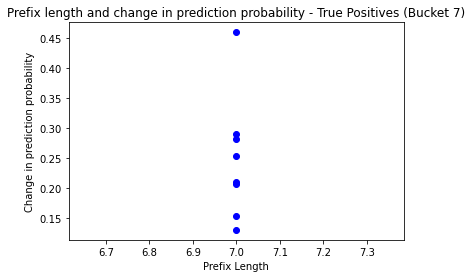

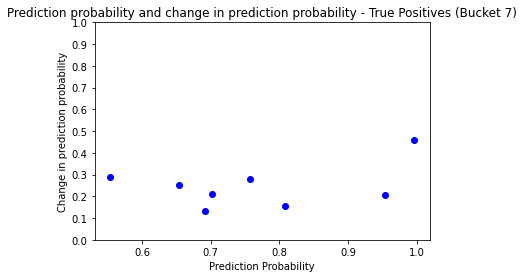

Category 3 of 4. Instance 1 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

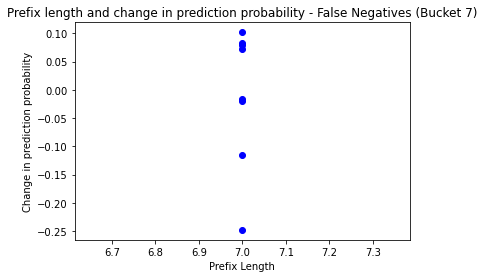

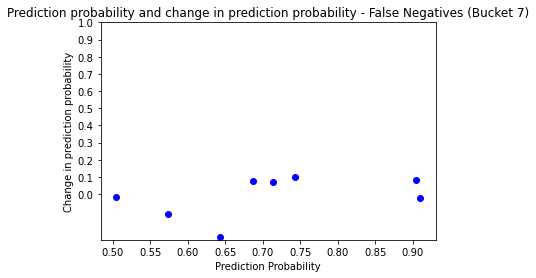

Category 4 of 4. Instance 1 of 7
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

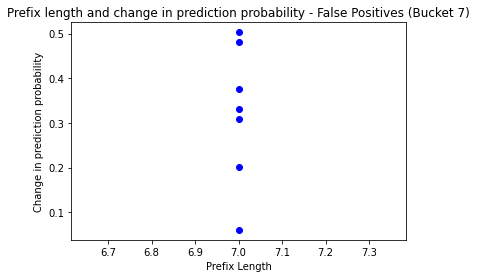

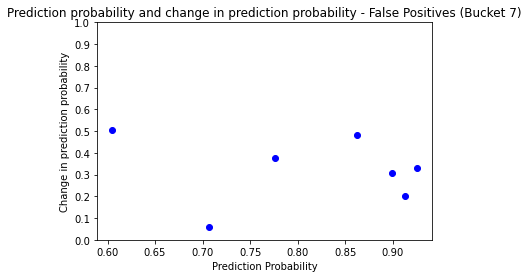

Bucket 8
Category 1 of 4. Instance 1 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creati

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

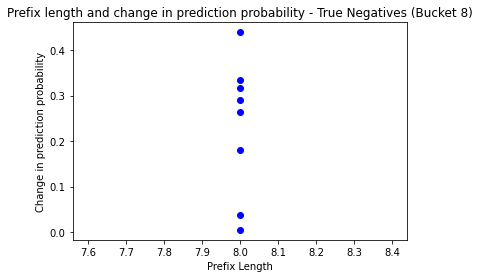

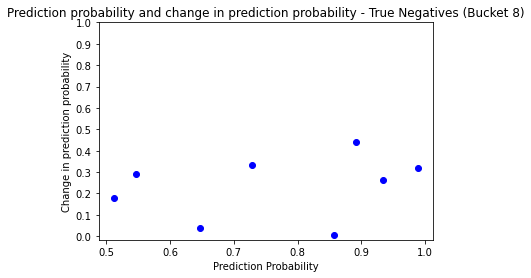

Category 2 of 4. Instance 1 of 6
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

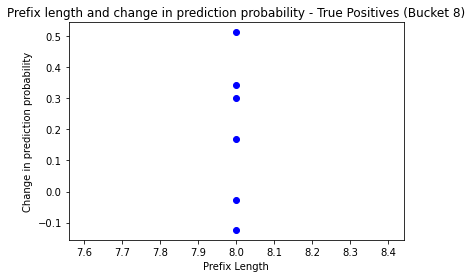

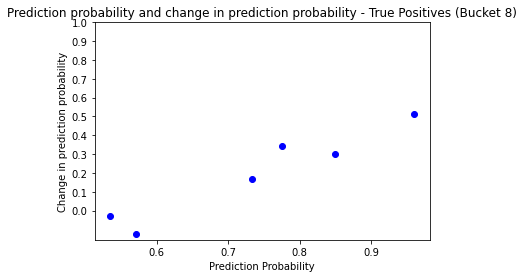

Category 3 of 4. Instance 1 of 9
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

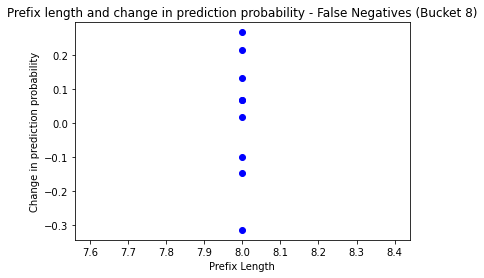

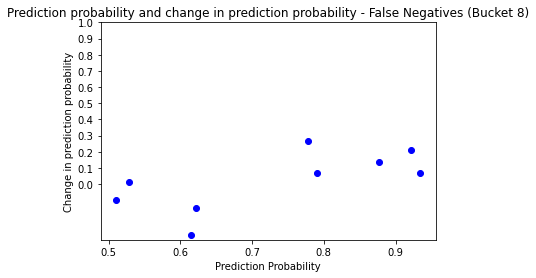

Category 4 of 4. Instance 1 of 5
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

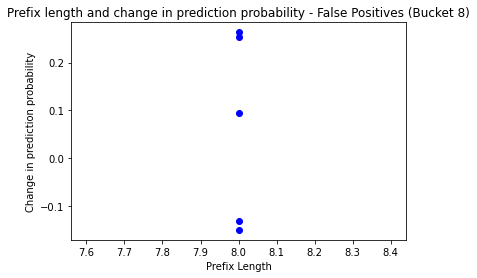

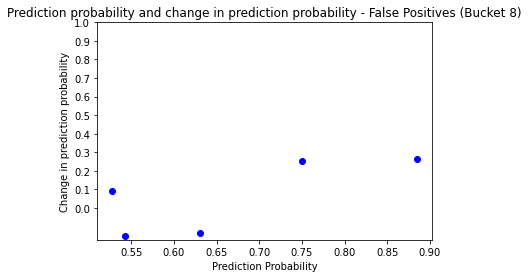

Bucket 9
Category 1 of 4. Instance 1 of 6
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creati

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

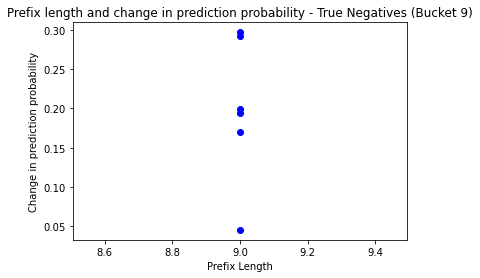

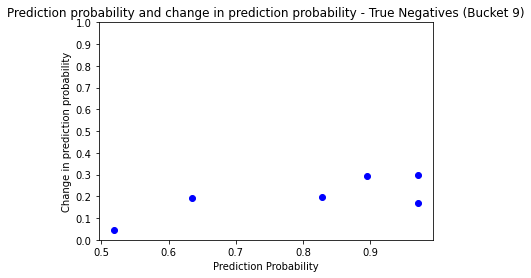

Category 2 of 4. Instance 1 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

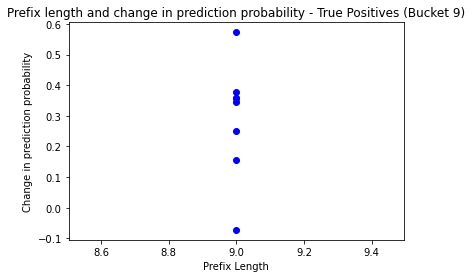

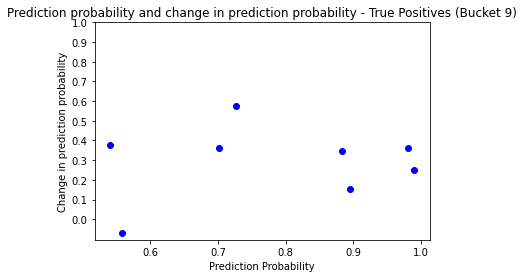

Category 3 of 4. Instance 1 of 5
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

In [ ]:
if generate_lime:
    for dataset_name in datasets:

        dataset_manager = DatasetManager(dataset_name)

        for ii in range(n_iter):
            num_buckets = len([name for name in os.listdir(os.path.join(PATH,'%s/%s_%s/models'% (dataset_ref, cls_method, method_name)))])-1
            
            if num_buckets < max_prefix:
                max_prefix = num_buckets
            buckets = range(0, max_prefix, gap)

            all_lime_changes = []
            all_lens = []
            all_probas = []
            all_case_ids = []

            pos_lime_changes = []
            pos_probas = []
            pos_nr_events = []
            pos_case_ids = []

            neg_lime_changes = []
            neg_probas = []
            neg_nr_events = []
            neg_case_ids = []

            for bucket in buckets:
                bucketID = bucket+1
                print ('Bucket', bucketID)

                #import everything needed to sort and predict
                feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls = joblib.load(cls_path)
                feature_combiner = joblib.load(feat_comb_path)

                #import data for bucket
                X_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                Y_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                with open (X_train_path, 'rb') as f:
                    dt_train_bucket = pickle.load(f)
                with open (Y_train_path, 'rb') as f:
                    train_y = pickle.load(f)
                #with open (X_test_path, 'rb') as f:
                #    dt_test_bucket = pickle.load(f)
                #with open (Y_test_path, 'rb') as f:
                #    test_y = pickle.load(f)

                #import previously identified samples
                tn_path = os.path.join(PATH, "%s/%s_%s/samples/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                tp_path = os.path.join(PATH, "%s/%s_%s/samples/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fn_path = os.path.join(PATH, "%s/%s_%s/samples/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fp_path = os.path.join(PATH, "%s/%s_%s/samples/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                sample_instances = []

                with open (tn_path, 'rb') as f:
                    tn_list = pickle.load(f)
                with open (tp_path, 'rb') as f:
                    tp_list = pickle.load(f)
                with open (fn_path, 'rb') as f:
                    fn_list = pickle.load(f)
                with open (fp_path, 'rb') as f:
                    fp_list = pickle.load(f)

                #save results to a list
                sample_instances.append(tn_list)
                sample_instances.append(tp_list)
                sample_instances.append(fn_list)
                sample_instances.append(fp_list)
                
                #get the training data as a matrix
                trainingdata = feature_combiner.fit_transform(dt_train_bucket);
                #importance = generate_global_explanations(trainingdata,train_y, cls, feature_combiner)

                feat_list = feature_combiner.get_feature_names()
                max_feat = round(len(feat_list)*0.1)
                class_names=['regular','deviant']# regular is 0, deviant is 1, 0 is left, 1 is right
                lime_explainer = lime.lime_tabular.LimeTabularExplainer(trainingdata, feature_names = feat_list, 
                                                                        class_names=class_names, discretize_continuous=True)
                type_list = ['True Negatives', 'True Positives', 'False Negatives', 'False Positives']

                for i in list(range(len(sample_instances))):
                    changes = []
                    probas = []
                    nr_events = []
                    case_ids = []

                    for j in list(range(len(sample_instances[i]))):
                        print("Category %s of %s. Instance %s of %s" %(i+1, len(sample_instances), j+1, len(sample_instances[i])))
                        instance = sample_instances[i][j]

                        ind = instance['predicted']
                        case_ids.append(instance['caseID'])
                        p1 = instance['proba']
                        probas.append(p1)
                        #print("proba:", p1)
                        nr_events.append(instance['nr_events'])
                        input_ = instance['input']

                        test_x_group = feature_combiner.fit_transform(input_) 
                        test_x=np.transpose(test_x_group[0])
                        #print(test_x)
                        #print(p1)

                        explanations = []
                        for iteration in range(exp_iter):
                            lime_exp = generate_lime_explanations(lime_explainer, test_x, cls, input_, max_feat = max_feat)
                            explanation = lime_exp.as_list()
                            explanations.extend(explanation)

                        features = []
                        for explanation in explanations:
                            features.append(explanation[0])

                        counter = Counter(features)
                        check_dup = []
                        for feat in feat_list:
                            for feature in counter:
                                if feat in feature:
                                    check_dup.append(feat)

                        dup_counter = Counter(check_dup)
                        duplicated = [feat for feat in dup_counter if dup_counter[feat] > 1]

                        for each in duplicated:
                            dpls = []
                            vals = []
                            for feat in counter.keys():
                                if each in feat:
                                    dpls.append(feat)
                                    vals.append(counter[feat])
                            keepval = vals.index(max(vals))
                            for n in range(len(dpls)):
                                if n != keepval:
                                    del counter[dpls[n]]

                        rel_feat = counter.most_common(max_feat)

                        intervals = []

                        for item in rel_feat:
                            print("Creating distribution for feature", rel_feat.index(item))
                            feat = item[0]
                            #print(item)
                            #print(feat)
                            for n in range(len(feat_list)):
                                if feat_list[n] in feat:
                                    if ("<" or "<=") in feat and (">" or ">=") in feat:
                                        two_sided = True
                                        parts = feat.split(' ')
                                        l_bound = float(parts[0])
                                        u_bound = float(parts[-1])
                                        interval = u_bound - l_bound
                                        new_min = u_bound
                                        new_max = u_bound + interval
                                    else:
                                        two_sided = False
                                        parts = feat.split(' ')
                                        if parts[-2] == "<=" or parts[-2] == "<":
                                            u_bound = float(parts[-1])
                                            if u_bound != 0:
                                                interval = math.ceil(u_bound*1.1)
                                            else:
                                                interval = 5
                                            new_min = u_bound
                                            new_max = u_bound + interval
                                        elif parts[-2] == ">=" or parts[-2] == ">":
                                            l_bound = float(parts[-1])
                                            if l_bound != 0:
                                                interval = math.ceil(l_bound*1.1)
                                            else:
                                                interval = 5
                                            new_max = l_bound
                                            new_min = l_bound - interval
                                        else:
                                            bound = float(parts[-1])
                                            interval = math.ceil((bound*1.1)/2)
                                            new_min = bound
                                            new_max = bound+interval
                                    feature_name = feat_list[n]
                                    index = n
                                    int_min = new_min
                                    int_max = new_max
                                    intervals.append((feature_name, index, int_min, int_max))

                        diffs = []
                        for iteration in range(exp_iter):
                            print("Pertubing - Run", iteration+1)
                            alt_x = np.copy(test_x_group)
                            #print("original:", alt_x)
                            for each in intervals:
                                new_val = random.uniform(each[2], each[3])
                                alt_x[0][each[1]] = new_val
                            p2 = cls.predict_proba(alt_x)[0][ind]
                            diff = p1-p2
                            diffs.append(diff)

                        changes.append(np.mean(diffs))
                        
                        instance['lime_fid_change'] = diffs
                        #print("RMSE for instance:", np.std(diffs))


                        if ind == 0:
                            pos_lime_changes.append(abs(diff))#np.std(diffs))
                            pos_probas.append(p1)
                            pos_nr_events.append(instance['nr_events'])
                            pos_case_ids.append(instance['caseID'])
                        else:
                            neg_lime_changes.append(abs(diff))#np.std(diffs))
                            neg_probas.append(p1)
                            neg_nr_events.append(instance['nr_events'])
                            neg_case_ids.append(instance['caseID'])

                    fig, ax = plt.subplots()
                    ax.plot(nr_events, changes, 'bo', label = "LIME")
                    ax.set_xlabel("Prefix Length")
                    ax.set_ylabel("Change in prediction probability")
                    #ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    #plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prefix length and change in prediction probability - %s (Bucket %s)" %(type_list[i], bucketID))
                    plt.show()

                    fig2, ax2 = plt.subplots()
                    ax2.plot(probas, changes, 'bo', label = "LIME")
                    ax2.set_xlabel("Prediction Probability")
                    ax2.set_ylabel("Change in prediction probability")
                    #ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prediction probability and change in prediction probability - %s (Bucket %s)" %(type_list[i], bucketID))
                    plt.show()

                    all_lime_changes.extend(changes)
                    all_lens.extend(nr_events)
                    all_probas.extend(probas)
                    all_case_ids.extend(case_ids)

                #Save dictionaries updated with scores
                with open(tn_path, 'wb') as f:
                    pickle.dump(sample_instances[0], f)
                with open(tp_path, 'wb') as f:
                    pickle.dump(sample_instances[1], f)
                with open(fn_path, 'wb') as f:
                    pickle.dump(sample_instances[2], f)
                with open(fp_path, 'wb') as f:
                    pickle.dump(sample_instances[3], f)

In [ ]:
fig, ax = plt.subplots()
ax.plot(all_lens, all_lime_changes, 'bo', label = "LIME")
ax.set_xlabel("Prefix Length")
ax.set_ylabel("Change in prediction probability")
#ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prefix length and change in prediction probability - All")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(all_probas, all_lime_changes, 'bo', label = "LIME")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - All")
plt.show()

In [ ]:
fig2, ax2 = plt.subplots()
ax2.plot(pos_probas, pos_lime_changes, 'bo', label = "LIME")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Negatives")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(neg_probas, neg_lime_changes, 'bo', label = "LIME")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Positives")
plt.show()

In [ ]:
lime_fid_score = sum(all_lime_changes)/len(all_lime_changes)
shap_fid_score = sum(all_shap_changes)/len(all_shap_changes)

print("LIME Fidelity Score: %s \nSHAP Fidelity Score: %s" %(lime_fid_score, shap_fid_score))

In [ ]:
lime_fid_score = sum(pos_lime_changes)/len(pos_lime_changes)
shap_fid_score = sum(pos_shap_changes)/len(pos_shap_changes)

print("Positive predictions: \nLIME Fidelity Score: %s \nSHAP Fidelity Score: %s" %(lime_fid_score, shap_fid_score))

lime_fid_score = sum(neg_lime_changes)/len(neg_lime_changes)
shap_fid_score = sum(neg_shap_changes)/len(neg_shap_changes)

print("Negative predictions: \nLIME Fidelity Score: %s \nSHAP Fidelity Score: %s" %(lime_fid_score, shap_fid_score))